In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import json

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate


import xgboost
from xgboost import XGBRegressor, XGBClassifier

from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import seaborn as sns

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

# Create the colormap
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')
SM_cmap = create_cyan_to_black_cmap(mcolors.to_rgb('coral'), 'black', cmap_name = 'SM_cmap')

In [3]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [4]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

In [5]:
BPs2plot = [2,5,8,11,14]
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

# custom functions

In [6]:
def MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, B_expected, S_expected):
   
    pspb_B_data = np.median([im / (1 - im) for im in pred_XG_SM])
    pspb_S_data = np.median([im / (1 - im) for im in pred_XG_NP])
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5



def MLL_aprox_discovery_KDE(pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected):
   
    pspb_B_data = np.median(pS_B_data/pB_B_data)
    pspb_S_data = np.median(pS_S_data/pB_S_data)
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5


# Reading the data

In [7]:
ttgamma_cross = 0.144 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

Wgamma_cross = 0.944 * 1000 #[fb]
Wgamma_NLO   = 2.37 # k-factor [14 TeV]

Wjets_cross = 168.12 * 1000 #[fb]
Wjets_NLO   = 1.27 # k-factor [14 TeV]

In [8]:
Wgamma_fidcross  = 110.02191836496351
Wjets_fidcross   = 108.33785910195228
ttgamma_fidcross = 6.999814656000001
B_fidcross_tot   = Wgamma_fidcross + Wjets_fidcross + ttgamma_fidcross
B_fidcross_tot

225.35959212291579

In [9]:
Wjets_aceptancia_init   = Wjets_fidcross / (Wjets_cross * 1000 * Wjets_NLO)
Wgamma_aceptancia_init  = Wgamma_fidcross / (Wgamma_cross * 1000 * Wgamma_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * 1000 * ttgamma_NLO)

In [10]:
Wgamma_expected  = 11002.191836496351
Wjets_expected   = 10833.785910195227
ttgamma_expected = 699.9814656000001
B_expected = (ttgamma_expected + Wjets_expected + Wgamma_expected)

In [11]:
sample = 60_000 # Number of signal and background events to train and validate

Wgamma_sample  = int(round(sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_sample   = int(round(sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))

print(Wgamma_sample)
print(Wjets_sample)
print(ttgamma_sample)

29292
28844
1864


In [12]:
##############
# input data #
##############

# photon -> (pT, eta, phi, num_photon) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi, num_leptons, num_taus) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, HT_had, num_jets)  HT: sum of Pt of all partciles, HT_had: sum PT of all the jets, number of jets (b-tag or not)


######
# SM #
######

# W gamma + W gamma jet #
# Dominant # Np es el W jet el dominant??

datFolderWgamma = '../data/Wgamma/'

photon_Wgamma  = np.loadtxt(datFolderWgamma + 'photon_6.dat', delimiter=' ')
jet_Wgamma     = np.loadtxt(datFolderWgamma + 'jet_6.dat', delimiter=' ')
lepton_Wgamma  = np.loadtxt(datFolderWgamma + 'lepton_6.dat', delimiter=' ')
MET_Wgamma     = np.loadtxt(datFolderWgamma + 'MET_6.dat', delimiter=' ')
hadinfo_Wgamma = np.loadtxt(datFolderWgamma + 'hadinfo_6.dat', delimiter=' ')


# W jet + W jet jet #

datFolderWjets = '../data/Wjets/'

photon_Wjets  = np.loadtxt(datFolderWjets + 'photon_6.dat', delimiter=' ')
jet_Wjets     = np.loadtxt(datFolderWjets + 'jet_6.dat', delimiter=' ')
lepton_Wjets  = np.loadtxt(datFolderWjets + 'lepton_6.dat', delimiter=' ')
MET_Wjets     = np.loadtxt(datFolderWjets + 'MET_6.dat', delimiter=' ')
hadinfo_Wjets = np.loadtxt(datFolderWjets + 'hadinfo_6.dat', delimiter=' ')


# tt gamma + tt gamma jet #

datFolderttgamma = '../data/ttGamma/'
 
photon_ttgamma  = np.loadtxt(datFolderttgamma + 'photon_6.dat', delimiter=' ')
jet_ttgamma     = np.loadtxt(datFolderttgamma + 'jet_6.dat', delimiter=' ')
lepton_ttgamma  = np.loadtxt(datFolderttgamma + 'lepton_6.dat', delimiter=' ')
MET_ttgamma     = np.loadtxt(datFolderttgamma + 'MET_6.dat', delimiter=' ')
hadinfo_ttgamma = np.loadtxt(datFolderttgamma + 'hadinfo_6.dat', delimiter=' ')


photon_SM  = np.concatenate([photon_Wgamma[:Wgamma_sample], photon_Wjets[:Wjets_sample], photon_ttgamma[:ttgamma_sample]])
jet_SM     = np.concatenate([jet_Wgamma[:Wgamma_sample], jet_Wjets[:Wjets_sample], jet_ttgamma[:ttgamma_sample]]) 
lepton_SM  = np.concatenate([lepton_Wgamma[:Wgamma_sample], lepton_Wjets[:Wjets_sample], lepton_ttgamma[:ttgamma_sample]])
MET_SM     = np.concatenate([MET_Wgamma[:Wgamma_sample], MET_Wjets[:Wjets_sample], MET_ttgamma[:ttgamma_sample]])
hadinfo_SM = np.concatenate([hadinfo_Wgamma[:Wgamma_sample], hadinfo_Wjets[:Wjets_sample], hadinfo_ttgamma[:ttgamma_sample]])


In [13]:
bkg_flag = np.zeros(len(photon_SM))

bkg_flag[:Wgamma_sample] = 1
bkg_flag[Wgamma_sample:(Wgamma_sample + Wjets_sample)] = 2
bkg_flag[(Wgamma_sample + Wjets_sample):len(photon_SM)] = 3

In [14]:
wjets_pool  = len(photon_Wjets[Wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / Wjets_fidcross)

Wgamma_pool_sample  = int(round(pool_sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_pool_sample   = int(round(pool_sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))

print(Wgamma_pool_sample)
print(Wjets_pool_sample)
print(ttgamma_pool_sample)

18217
17939
1159


In [15]:
photon_SM_pool  = np.concatenate([photon_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  photon_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  photon_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])
jet_SM_pool     = np.concatenate([jet_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  jet_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  jet_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]]) 
lepton_SM_pool  = np.concatenate([lepton_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  lepton_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  lepton_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])
MET_SM_pool     = np.concatenate([MET_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  MET_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  MET_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])
hadinfo_SM_pool = np.concatenate([hadinfo_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  hadinfo_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  hadinfo_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])

In [16]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

bkg_flag_pool[:Wgamma_pool_sample] = 1
bkg_flag_pool[Wgamma_pool_sample:(Wgamma_pool_sample + Wjets_pool_sample)] = 2
bkg_flag_pool[(Wgamma_pool_sample + Wjets_pool_sample):] = 3

In [17]:
print(photon_Wjets.shape)
print(photon_ttgamma.shape)
print(photon_Wgamma.shape)

(46783, 4)
(499416, 4)
(673720, 4)


In [18]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_6.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_6.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_6.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_6.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_6.dat', delimiter=' ') )

In [19]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (60000, 5)
BP1 (210768, 5)
BP2 (220621, 5)
BP3 (224270, 5)
BP4 (268160, 5)
BP5 (254511, 5)
BP6 (218307, 5)
BP7 (302978, 5)
BP8 (279921, 5)
BP9 (244546, 5)
BP10 (330992, 5)
BP11 (302374, 5)
BP12 (268335, 5)
BP13 (356324, 5)
BP14 (324324, 5)
BP15 (288862, 5)


In [20]:
cross_section_bps    = np.asarray([190, 189, 189, 92, 92, 92, 49, 48, 48, 27, 27, 27, 16, 16, 16])
branching_ratios_bps = np.asarray([0.14, 0.37, 0.73, 0.15, 0.36, 0.67, 0.16, 0.36, 0.62, 0.17, 0.35, 0.58, 0.16, 0.32, 0.52])

signal_cross        = cross_section_bps * branching_ratios_bps *  0.2134 # fb
signal_init_sim_eve = np.asarray([1836673, 2e6, 2400081, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6])
#signal_cut_ev       = np.asarray([238160,246196,242249,301575,266047,203155,315960,280065,225958,326687,292051,244271,334782,301215,258277]) #OLD
signal_cut_ev       = np.asarray([210768, 220621, 224270, 268160, 254511, 218307, 302978, 279921, 244546, 330992, 302374, 268335, 356324, 324324, 288862])
signal_NLO          = 1.25

cross       = signal_cross * signal_NLO
aceptancia  = signal_cut_ev / (1. * signal_init_sim_eve)
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [0.81425212 2.05771304 3.43901743 0.49356859 1.1242718  1.79475315
 0.31681198 0.64513953 0.97066177 0.20263041 0.3811103  0.56045857
 0.12166327 0.22147437 0.32054438]
Events expected:  [ 81.42521191 205.77130384 343.90174266  49.3568592  112.42718012
 179.47531491  31.68119755  64.51395271  97.0661765   20.26304062
  38.11102998  56.04585686  12.16632666  22.14743731  32.05443842]


In [21]:
# other variables, individual channels:

ST_Wgamma = photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

MET_sig_Wgamma = np.divide( MET_Wgamma[:,0], np.sqrt(hadinfo_Wgamma[:,0]) )

m_eff_Wgamma = MET_Wgamma[:,0] + photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

phi_MET_photon_Wgamma = np.absolute( MET_Wgamma[:,2] - photon_Wgamma[:,2] )
phi_MET_jet_Wgamma    = np.absolute( MET_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_MET_lepton_Wgamma = np.absolute( MET_Wgamma[:,2] - lepton_Wgamma[:,2] )

mT_photon_Wgamma = np.sqrt( (2*photon_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_photon_Wgamma)) )
mT_jet_Wgamma    = np.sqrt( (2*jet_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_jet_Wgamma)) )
mT_lepton_Wgamma = np.sqrt( (2*lepton_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_lepton_Wgamma)) )

phi_photon_jet_Wgamma    = np.absolute( photon_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_photon_lepton_Wgamma = np.absolute( photon_Wgamma[:,2] - lepton_Wgamma[:,2] )
phi_lepton_jet_Wgamma    = np.absolute( lepton_Wgamma[:,2] - jet_Wgamma[:,2] )

phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]
phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi]
phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]

deltaR_photon_jet_Wgamma    = np.sqrt( (photon_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_photon_jet_Wgamma)**2 )
deltaR_photon_lepton_Wgamma = np.sqrt( (photon_Wgamma[:,1]-lepton_Wgamma[:,1])**2 + (phi_photon_lepton_Wgamma)**2 )
deltaR_lepton_jet_Wgamma    = np.sqrt( (lepton_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_lepton_jet_Wgamma)**2 )

ST_Wjets = photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

MET_sig_Wjets = np.divide( MET_Wjets[:,0],np.sqrt(hadinfo_Wjets[:,0]) )

m_eff_Wjets = MET_Wjets[:,0] + photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

phi_MET_photon_Wjets = np.absolute( MET_Wjets[:,2] - photon_Wjets[:,2] )
phi_MET_jet_Wjets    = np.absolute( MET_Wjets[:,2] - jet_Wjets[:,2] )
phi_MET_lepton_Wjets = np.absolute( MET_Wjets[:,2] - lepton_Wjets[:,2] )

mT_photon_Wjets = np.sqrt( (2*photon_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_photon_Wjets)) )
mT_jet_Wjets    = np.sqrt( (2*jet_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_jet_Wjets)) )
mT_lepton_Wjets = np.sqrt( (2*lepton_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_lepton_Wjets)) )

phi_photon_jet_Wjets    = np.absolute( photon_Wjets[:,2] - jet_Wjets[:,2] )
phi_photon_lepton_Wjets = np.absolute( photon_Wjets[:,2] - lepton_Wjets[:,2] )
phi_lepton_jet_Wjets    = np.absolute( lepton_Wjets[:,2] - jet_Wjets[:,2] )

phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]       = (2.* np.pi) - phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]
phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi] = (2.* np.pi) - phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi]
phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]

deltaR_photon_jet_Wjets    = np.sqrt( (photon_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_photon_jet_Wjets)**2 )
deltaR_photon_lepton_Wjets = np.sqrt( (photon_Wjets[:,1]-lepton_Wjets[:,1])**2 + (phi_photon_lepton_Wjets)**2 )
deltaR_lepton_jet_Wjets    = np.sqrt( (lepton_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_lepton_jet_Wjets)**2 )



ST_ttgamma = photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

MET_sig_ttgamma = np.divide( MET_ttgamma[:,0],np.sqrt(hadinfo_ttgamma[:,0]) )

m_eff_ttgamma = MET_ttgamma[:,0] + photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

phi_MET_photon_ttgamma = np.absolute( MET_ttgamma[:,2] - photon_ttgamma[:,2] )
phi_MET_jet_ttgamma    = np.absolute( MET_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_MET_lepton_ttgamma = np.absolute( MET_ttgamma[:,2] - lepton_ttgamma[:,2] )

mT_photon_ttgamma = np.sqrt( (2*photon_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_photon_ttgamma)) )
mT_jet_ttgamma    = np.sqrt( (2*jet_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_jet_ttgamma)) )
mT_lepton_ttgamma = np.sqrt( (2*lepton_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_lepton_ttgamma)) )

phi_photon_jet_ttgamma    = np.absolute( photon_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_photon_lepton_ttgamma = np.absolute( photon_ttgamma[:,2] - lepton_ttgamma[:,2] )
phi_lepton_jet_ttgamma    = np.absolute( lepton_ttgamma[:,2] - jet_ttgamma[:,2] )

phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]
phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi]
phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]

deltaR_photon_jet_ttgamma    = np.sqrt( (photon_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_photon_jet_ttgamma)**2 )
deltaR_photon_lepton_ttgamma = np.sqrt( (photon_ttgamma[:,1]-lepton_ttgamma[:,1])**2 + (phi_photon_lepton_ttgamma)**2 )
deltaR_lepton_jet_ttgamma    = np.sqrt( (lepton_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_lepton_jet_ttgamma)**2 )



# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [22]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

In [23]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [24]:
print(photon_SM.shape)
print(photon_SM_pool.shape)
print(photon_NP[0].shape)

(60000, 4)
(37315, 4)
(210768, 4)


# Analysis

## training

In [25]:
# LOW LEVEL VARIABLES ----------------------

print(photon_SM.shape)
print(jet_SM.shape)
print(lepton_SM.shape)
print(MET_SM.shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------
print(hadinfo_SM.shape)
print(ST_SM.shape)
print(MET_sig_SM.shape)
print(m_eff_SM.shape)
print(mT_photon_SM.shape)
print(mT_jet_SM.shape)
print(mT_lepton_SM.shape)
#-------------------------------------------

(60000, 4)
(60000, 3)
(60000, 5)
(60000, 3)
(60000, 3)
(60000,)
(60000,)
(60000,)
(60000,)
(60000,)
(60000,)


In [557]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 9

# LOW LEVEL VARIABLES ----------------------


print(photon_NP[bp].shape)
print(jet_NP[bp].shape)
print(lepton_NP[bp].shape)
print(MET_NP[bp].shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------

print(hadinfo_NP[bp].shape)
print(ST_NP[bp].shape)
print(MET_sig_NP[bp].shape)
print(m_eff_NP[bp].shape)
print(mT_photon_NP[bp].shape)
print(mT_jet_NP[bp].shape)
print(mT_lepton_NP[bp].shape)
#-------------------------------------------

(330992, 4)
(330992, 3)
(330992, 5)
(330992, 3)
(330992, 3)
(330992,)
(330992,)
(330992,)
(330992,)
(330992,)
(330992,)


In [558]:
nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
nobs

60000

In [559]:
df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']
#np.random.seed(28890)

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
#df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])

#%df[lst[22]]= np.concatenate([phi_MET_photon_SM[SM_indices], phi_MET_photon_NP[bp][:nobs]])
#%df[lst[23]]= np.concatenate([phi_MET_jet_SM[SM_indices], phi_MET_jet_NP[bp][:nobs]])
#%df[lst[24]]= np.concatenate([phi_MET_lepton_SM[SM_indices], phi_MET_lepton_NP[bp][:nobs]])

#%df[lst[25]]= np.concatenate([deltaR_photon_jet_SM[SM_indices], deltaR_photon_jet_NP[bp][:nobs]])
#%df[lst[26]]= np.concatenate([deltaR_photon_lepton_SM[SM_indices], deltaR_photon_lepton_NP[bp][:nobs]])
#%df[lst[27]]= np.concatenate([deltaR_lepton_jet_SM[SM_indices], deltaR_lepton_jet_NP[bp][:nobs]])


df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

df_array = np.asarray(df)
df

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1
0,15.22,-1.698,0.040,1.0,313.42,0.255,-2.756,27.50,-0.128,1.325,...,594.99,552.27,5.0,356.14,18.060531,52.990522,734.060371,67.782693,1.0,0.0
1,15.42,0.518,0.745,1.0,395.81,-0.075,-2.198,165.92,0.520,0.745,...,714.28,532.94,3.0,577.15,9.129681,0.674726,618.129033,2.213272,2.0,0.0
2,22.24,-0.381,2.563,1.0,289.05,-1.530,-0.478,46.18,0.272,2.820,...,380.91,312.49,2.0,357.47,12.863713,9.334335,538.732163,14.202811,1.0,0.0
3,12.34,-1.227,0.919,1.0,234.80,0.619,-2.135,122.67,-1.181,0.930,...,498.27,363.26,3.0,369.81,9.945362,10.919170,455.779580,32.621296,2.0,0.0
4,380.23,-1.795,1.320,1.0,580.08,-0.044,-1.210,12.14,-1.011,1.259,...,972.45,580.08,1.0,972.45,10.479689,441.107959,811.800042,81.779132,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,38.91,1.926,0.586,1.0,338.98,0.033,-0.069,65.91,0.478,-2.780,...,476.67,371.85,2.0,443.80,15.411235,215.022129,675.284897,69.955271,0.0,1.0
119996,22.67,-1.886,1.230,1.0,162.67,1.133,-0.662,43.32,-1.577,0.716,...,455.60,389.61,4.0,228.66,15.806669,113.349481,467.037233,198.350183,0.0,1.0
119997,136.03,-1.343,-2.482,1.0,810.71,-0.136,0.615,29.65,0.108,2.829,...,1152.41,986.73,2.0,976.39,21.592378,74.975747,1534.549496,105.820984,0.0,1.0
119998,25.38,2.175,0.160,1.0,502.79,1.057,0.303,16.08,2.138,-0.418,...,724.17,682.71,3.0,544.25,13.791690,194.087577,860.749053,148.728772,0.0,1.0


In [560]:
df_test = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
#df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])

#%df_test[lst[22]]= np.concatenate([phi_MET_photon_SM_pool[SM_indices], phi_MET_photon_NP[bp][nobs:]])
#%df_test[lst[23]]= np.concatenate([phi_MET_jet_SM_pool[SM_indices], phi_MET_jet_NP[bp][nobs:]])
#%df_test[lst[24]]= np.concatenate([phi_MET_lepton_SM_pool[SM_indices], phi_MET_lepton_NP[bp][nobs:]])

#%df_test[lst[25]]= np.concatenate([deltaR_photon_jet_SM_pool[SM_indices], deltaR_photon_jet_NP[bp][nobs:]])
#%df_test[lst[26]]= np.concatenate([deltaR_photon_lepton_SM_pool[SM_indices], deltaR_photon_lepton_NP[bp][nobs:]])
#%df_test[lst[27]]= np.concatenate([deltaR_lepton_jet_SM_pool[SM_indices], deltaR_lepton_jet_NP[bp][nobs:]])


df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

df_test_array = np.asarray(df_test)
df_test

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1
0,108.86,1.260,-3.091,1.0,176.64,1.598,1.927,37.44,0.521,-0.346,...,322.94,176.64,1.0,322.94,12.012444,278.129619,382.891369,42.040429,1.0,0.0
1,13.70,-1.281,2.335,1.0,254.92,-0.605,-0.461,28.92,-0.565,2.781,...,297.54,254.92,1.0,297.54,13.335577,21.865247,484.180468,4.403849,1.0,0.0
2,23.70,-1.903,-0.806,1.0,517.58,-0.293,2.665,125.57,-1.590,-0.136,...,715.64,566.37,3.0,666.85,14.220165,34.091533,887.340932,67.266406,2.0,0.0
3,49.80,0.362,0.164,1.0,181.98,-0.267,-2.282,65.12,-0.703,0.057,...,518.45,403.53,5.0,296.90,10.094206,69.639781,408.975189,91.892133,1.0,0.0
4,15.02,-0.035,-0.107,1.0,603.87,-0.493,-2.914,60.82,-0.238,-0.405,...,1019.28,943.44,4.0,679.71,23.090465,4.524386,1320.259160,71.855677,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308302,38.85,-1.510,2.373,1.0,139.50,-0.445,3.069,23.17,-0.629,-1.821,...,354.74,241.78,3.0,201.52,13.048366,183.791068,370.315921,115.644439,0.0,1.0
308303,18.79,2.073,1.561,1.0,257.66,-2.680,-2.292,20.68,0.170,-0.073,...,524.47,485.00,4.0,297.13,16.139688,74.293713,613.723944,60.778604,0.0,1.0
308304,80.86,-1.390,-0.657,1.0,287.22,-1.783,-3.098,21.00,-1.714,2.236,...,443.46,341.60,3.0,389.08,10.945229,124.749301,510.628319,114.935302,0.0,1.0
308305,41.27,-0.011,1.685,1.0,499.04,0.122,-1.174,64.08,0.615,-1.687,...,1148.86,1043.51,4.0,604.39,10.321631,142.745250,735.487491,218.862349,0.0,1.0


In [561]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
#%test_size  = int(0.15 * nobs)
val_size   = nobs - train_size #%- test_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
#%test_indices  = random_indices[train_size:(train_size + test_size)]
#%val_indices   = random_indices[(train_size + test_size):]
val_indices   = random_indices[train_size:]

In [562]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [563]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [564]:
X_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_mon_train    = df_array[train_indices, -1]

X_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_mon_test    = df_test_array[:, -1]

X_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_mon_val    = df_array[val_indices, -1]

In [565]:
ind_signal_train  = np.where(bkg_flag_train == 0)[0]
ind_wgamma_train  = np.where(bkg_flag_train == 1)[0] # W gamma
ind_wjets_train   = np.where(bkg_flag_train == 2)[0] # W jets
ind_ttgamma_train = np.where(bkg_flag_train == 3)[0] # tt gamma

if(len(ind_signal_train) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_train), S_expected[bp]))

if(len(ind_wgamma_train) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_train), Wgamma_expected))
if(len(ind_ttgamma_train) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_train), ttgamma_expected))
if(len(ind_wjets_train) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_train), Wjets_expected))

In [566]:
ind_signal_test  = np.where(bkg_flag_test == 0)[0]
ind_wgamma_test  = np.where(bkg_flag_test == 1)[0] # W gamma
ind_wjets_test   = np.where(bkg_flag_test == 2)[0] # W jets
ind_ttgamma_test = np.where(bkg_flag_test == 3)[0] # tt gamma

if(len(ind_signal_test) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_test), S_expected[bp]))

if(len(ind_wgamma_test) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_test), Wgamma_expected))
if(len(ind_ttgamma_test) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_test), ttgamma_expected))
if(len(ind_wjets_test) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_test), Wjets_expected))

In [567]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(X_train)

X_mon_train = x_scaler.transform(X_train)
X_mon_test  = x_scaler.transform(X_test)
X_mon_val   = x_scaler.transform(X_val)

In [568]:
ind_signal  = np.where(bkg_flag_val == 0)[0]
ind_wgamma  = np.where(bkg_flag_val == 1)[0] # W gamma
ind_wjets   = np.where(bkg_flag_val == 2)[0] # W jets
ind_ttgamma = np.where(bkg_flag_val == 3)[0] # tt gamma

In [569]:
if(len(ind_signal) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal), S_expected[bp]))

if(len(ind_wgamma) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma), Wgamma_expected))
if(len(ind_ttgamma) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma), ttgamma_expected))
if(len(ind_wjets) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets), Wjets_expected))

There are less Wgamma events 5779 than expected 11002.191836496351
There are less Wjets events 5812 than expected 10833.785910195227


In [570]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
classifier.fit(X_mon_train, y_mon_train, 
               eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
               verbose  =True)

[0]	validation_0-logloss:0.64717	validation_1-logloss:0.64744
[1]	validation_0-logloss:0.60897	validation_1-logloss:0.60952
[2]	validation_0-logloss:0.57672	validation_1-logloss:0.57736
[3]	validation_0-logloss:0.54923	validation_1-logloss:0.55010
[4]	validation_0-logloss:0.52553	validation_1-logloss:0.52677
[5]	validation_0-logloss:0.50512	validation_1-logloss:0.50659
[6]	validation_0-logloss:0.48738	validation_1-logloss:0.48895
[7]	validation_0-logloss:0.47139	validation_1-logloss:0.47318
[8]	validation_0-logloss:0.45679	validation_1-logloss:0.45868
[9]	validation_0-logloss:0.44480	validation_1-logloss:0.44696
[10]	validation_0-logloss:0.43383	validation_1-logloss:0.43624
[11]	validation_0-logloss:0.42390	validation_1-logloss:0.42631
[12]	validation_0-logloss:0.41549	validation_1-logloss:0.41810
[13]	validation_0-logloss:0.40741	validation_1-logloss:0.41006
[14]	validation_0-logloss:0.40001	validation_1-logloss:0.40281
[15]	validation_0-logloss:0.39387	validation_1-logloss:0.39695
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0.0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [571]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

In [572]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (96000, 22)
y_mon_train :  (96000,)
X_mon_val :  (24000, 22)
y_mon_val :  (24000,)
X_mon_test :  (308307, 22)
y_mon_test :  (308307,)



In [573]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total   = np.zeros(nvals) 
fpr_total   = np.zeros(nvals) 
tpr_ttgamma = np.zeros(nvals) 
fpr_ttgamma = np.zeros(nvals) 
tpr_wgamma  = np.zeros(nvals) 
fpr_wgamma  = np.zeros(nvals) 
tpr_wjets   = np.zeros(nvals) 
fpr_wjets   = np.zeros(nvals) 

for ith, th in enumerate(np.linspace(0,1, nvals)):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))
    auc_total = auc(fpr_total, tpr_total)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_wgamma = auc(fpr_wgamma, tpr_wgamma)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
    auc_wjets = auc(fpr_wjets, tpr_wjets)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

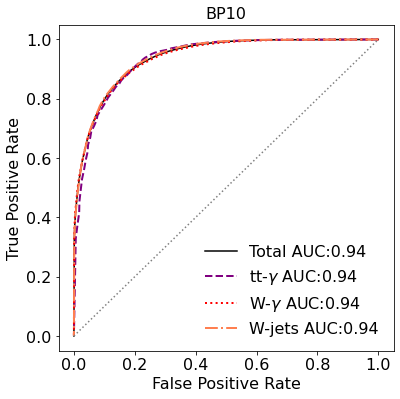

In [574]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
plt.plot(fpr_ttgamma, tpr_ttgamma, c = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$ AUC:{:.2f}'.format(auc_ttgamma))
plt.plot(fpr_wgamma, tpr_wgamma, c = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$ AUC:{:.2f}'.format(auc_wgamma))
plt.plot(fpr_wjets, tpr_wjets, c = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets AUC:{:.2f}'.format(auc_wjets))
plt.legend(frameon=False,fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"BP" + str(bp + 1),fontsize=16)

plt.savefig('../graph/ROC_BP' + str(bp + 1) + '_All_MET200.png', bbox_inches='tight')

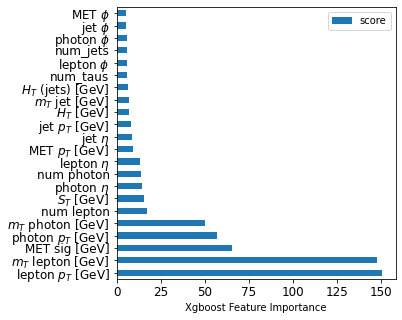

In [575]:
fig, ax = plt.subplots(figsize = (5,5))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("Xgboost Feature Importance")
ax.set_yticklabels(np.asarray(lst)[np.argsort(values)[::-1]])

plt.savefig('../graph/BP' + str(bp + 1) + '_featureImportance_All_MET200.png', bbox_inches='tight')

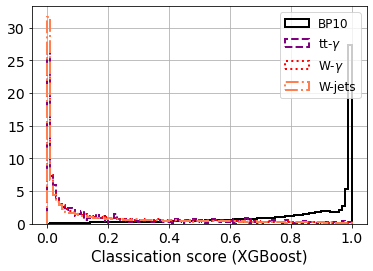

In [576]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'BP' + str(bp + 1), lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('../graph/MLOutput_dist_BP' + str(bp + 1) + '_All_MET200.png', bbox_inches="tight")

In [577]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [578]:
len(np.where(bkg_flag_test != 0)[0])

37315

In [579]:
len(np.where(bkg_flag_test == 0)[0])

270992

In [580]:
S_expected[bp]

20.263040622000005

In [581]:
S_expected[bp] / np.sqrt(B_expected)

0.13498199228216518

In [582]:
print('MLL aproximated Z:')
print( MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, int(B_expected), int(S_expected[bp]))) 

MLL aproximated Z:
nan


/tmp/ipykernel_15927/1019789035.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return (f0 + fB + fS)**0.5


## Sequential selection criteria

In [583]:
nbins = 10
indices_aux = np.arange(len(df_test_array))
        
n_np0      = len(np.where(df_test_array[:, 22] == 0)[0])
n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 2), size = 100, replace = True)
random_vars = np.concatenate((np.random.choice(range(len(df_test.columns) - 3), size = len(df_test.columns) - 3, replace = False), random_vars))
#random_vars = list(np.argsort(values)[::-1])*10

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    Z_sup = np.zeros(nbins)
    Z_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        n_np      = len(np.where(df_test_array[indices_sup, 22] == 0)[0])
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])

        ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)


        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_sup[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])

        ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_inf[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut = np.argmax(np.asarray(Z))
    #print('Z = ' + str(Z[max_cut]))
    indices_aux = indices[max_cut]
    max_cut = np.argmax((Z_inf, Z_sup))
    if max_cut >= len(Z_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(Z_sup)]) + '; Z = ' + str(Z_sup[max_cut - len(Z_inf)]))
    #%    indices_aux = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cuts[max_cut - len(Z_sup)]) )[0]]
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(Z_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(Z_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; Z = ' + str(Z_inf[max_cut]))
    #%    indices_aux = indices_aux[np.where( (df_array[indices_aux,ivar] <= cuts[max_cut]) )[0]]
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
    
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])

ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
if (B_expected_aux > 5) and (S_expected_aux > 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))

jet $\eta$ <= 3.3306666666666667; Z = 0.1332632680643623
lepton $p_T$ [GeV] <= 140.30555555555554; Z = 0.14590509962667172
num lepton <= 1.0; Z = 0.14619716846787847
MET sig [GeV] >= 9.54413578359809; Z = 0.15286666935456408
$H_T$ [GeV] <= 1495.17; Z = 0.1531494697117854
lepton $\phi$ <= 3.142; Z = 0.1531494697117854
jet $p_T$ [GeV] <= 970.7433333333332; Z = 0.15322913481719247
num_jets <= 6.555555555555555; Z = 0.1537349063337559
MET $\phi$ <= 3.142; Z = 0.1537349063337559
$S_T$ [GeV] <= 1097.8233333333333; Z = 0.1538558278821995
$m_T$ photon [GeV] <= 912.0434067726508; Z = 0.15395176006671857
photon $\eta$ <= 2.369; Z = 0.15395176006671857
photon $p_T$ [GeV] <= 503.20666666666665; Z = 0.15400232283575768
jet $\phi$ <= 3.141; Z = 0.15400232283575768
lepton $\eta$ <= 2.499; Z = 0.15400232283575768
photon $\phi$ <= 3.142; Z = 0.15400232283575768
MET $p_T$ [GeV] <= 1315.06; Z = 0.15400232283575768
num photon <= 3.0; Z = 0.15400232283575768
$H_T$ (jets) [GeV] <= 1462.75; Z = 0.15400232283

In [584]:
sup_cuts

{'jet $\\eta$': 3.33,
 'lepton $p_T$ [GeV]': 53.43,
 'num lepton': 1.0,
 'MET sig [GeV]': 27.1031984034085,
 '$H_T$ [GeV]': 1184.2355555555555,
 'lepton $\\phi$': 3.142,
 'jet $p_T$ [GeV]': 759.09,
 'num_jets': 6.0,
 'MET $\\phi$': 3.142,
 '$S_T$ [GeV]': 1026.06,
 '$m_T$ photon [GeV]': 758.0501241536962,
 'photon $\\eta$': 2.369,
 'photon $p_T$ [GeV]': 328.08,
 'jet $\\phi$': 3.141,
 'lepton $\\eta$': 2.496,
 'photon $\\phi$': 3.142,
 'MET $p_T$ [GeV]': 552.3933333333334,
 'num photon': 2.0,
 '$H_T$ (jets) [GeV]': 772.96,
 'num_taus': 2.0,
 '$m_T$ jet [GeV]': 1291.9102012687158,
 '$m_T$ lepton [GeV]': 334.38891360144976}

In [585]:
inf_cuts

{'jet $\\eta$': -3.519777777777778,
 'lepton $p_T$ [GeV]': -999999,
 'num lepton': -999999,
 'MET sig [GeV]': 9.54413578359809,
 '$H_T$ [GeV]': -999999,
 'lepton $\\phi$': -999999,
 'jet $p_T$ [GeV]': -999999,
 'num_jets': -999999,
 'MET $\\phi$': -999999,
 '$S_T$ [GeV]': -999999,
 '$m_T$ photon [GeV]': -999999,
 'photon $\\eta$': -999999,
 'photon $p_T$ [GeV]': -999999,
 'jet $\\phi$': -999999,
 'lepton $\\eta$': -999999,
 'photon $\\phi$': -999999,
 'MET $p_T$ [GeV]': -999999,
 'num photon': -999999,
 '$H_T$ (jets) [GeV]': -999999,
 'num_taus': -999999,
 '$m_T$ jet [GeV]': 244.52696297160142,
 '$m_T$ lepton [GeV]': 92.6485734144519}

In [586]:
write = True
if write:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts_MET200.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open('../data/cuts/BP' + str(bp+1) + '_infCuts_MET200.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts_MET200.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open('../data/cuts/BP' + str(bp+1) + '_infCuts_MET200.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

In [587]:
indices_aux = np.arange(len(df_test_array))

variables = list(sup_cuts.keys())
for i in range(len(variables)):
    ind_var = np.where(df_test.columns == variables[i])[0][0]
    indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                            (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                           )[0]]


In [588]:
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])

ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))



Z =  0.49321936086667173
Expected Background = 146
Expected Signal = 6


In [589]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,23] == 0)[0]
NP_test_pool = np.where(df_test_array[:,23] == 1)[0]

q0_exp = np.zeros(nexperiments)
B_observed_exp = np.zeros(nexperiments)
S_observed_exp = np.zeros(nexperiments)
for nexp in tqdm(range(nexperiments)):
    # Let's create a pseudo-experiment
    SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
    NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
    indices_aux = np.concatenate((NP_indices, SM_indices))

    #%print('At the beggining')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')
    # Let's make the cuts

    variables = list(sup_cuts.keys())
    for i in range(len(variables)):
        #print(variables[i] + '<=' + str(sup_cuts[variables[i]]))
        #print(variables[i] + '>=' + str(inf_cuts[variables[i]]))
        ind_var = np.where(df_test.columns == variables[i])[0][0]
        indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                               )[0]]

        #%print('Total:' + str(len(indices_aux)))
        #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
        #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
        #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
        #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
        #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    # Let's calculate everything
    
    n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

    n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
    n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
    n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])

    #%print('At the end')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 22] == 0)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')

    #S_expected_aux = n_np
    S_observed_exp[nexp] = n_np

    # Formula discovery
    B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets
    
    N_observed = n_np + n_ttgamma + n_wgamma + n_wjets
    if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
        q0_exp[nexp] = -2 * N_observed * np.log(B_expected_aux / N_observed) -2 * (N_observed - B_expected_aux)
        #Z_exp[nexp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
        #%print('\n')
        #%print('Z = ', Z_exp[nexp])
        #%print('Expected Background = ' + str(B_expected_aux))
        #%print('Expected Signal = ' + str(S_expected_aux))
    else:
        q0_exp[nexp] = -99
        #print('Expected Background = ' + str(B_observed_exp))
        #print('Expected Signal = ' + str(S_observed_exp))
    #%print('------------------------------------------')
        

100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 216.19it/s]


(array([ 46., 295., 623., 575., 318., 108.,  31.,   2.,   1.,   1.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

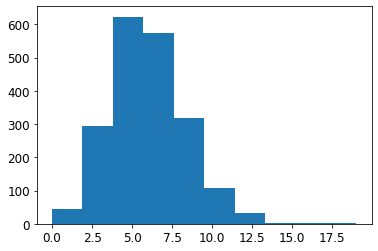

In [590]:
plt.hist(S_observed_exp)

In [591]:
print('Final results: for BP ' + str(bp+1) + '\n ')
print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))

Final results: for BP 10
 
Z = 0.584048435846551; Z_std = 0.7733433762423032
B_exp = 146.6805; B_exp_std = 7.716179090067829
S_exp = 5.805; S_exp_std = 2.4359751640770066


In [592]:
np.asarray(lst)[np.argsort(values)[::-1]][:4]

array(['lepton $p_T$ [GeV]', '$m_T$ lepton [GeV]', 'MET sig [GeV]',
       'photon $p_T$ [GeV]'], dtype='<U18')

In [593]:
imp_vars = np.asarray(lst)[np.argsort(values)[::-1]][:4]
imp_vars = np.array(['lepton $p_T$ [GeV]', '$m_T$ lepton [GeV]','MET sig [GeV]', '$m_T$ photon [GeV]'])


In [594]:
imp_vars

array(['lepton $p_T$ [GeV]', '$m_T$ lepton [GeV]', 'MET sig [GeV]',
       '$m_T$ photon [GeV]'], dtype='<U18')

In [595]:
imp_vars_labels = ['$p_T^{\ell_{1}}$', '$m_T^{\ell_1}$',
                  '$E_T^{miss}/\sqrt{H_T}$', '$m_T^{\gamma_1}$']

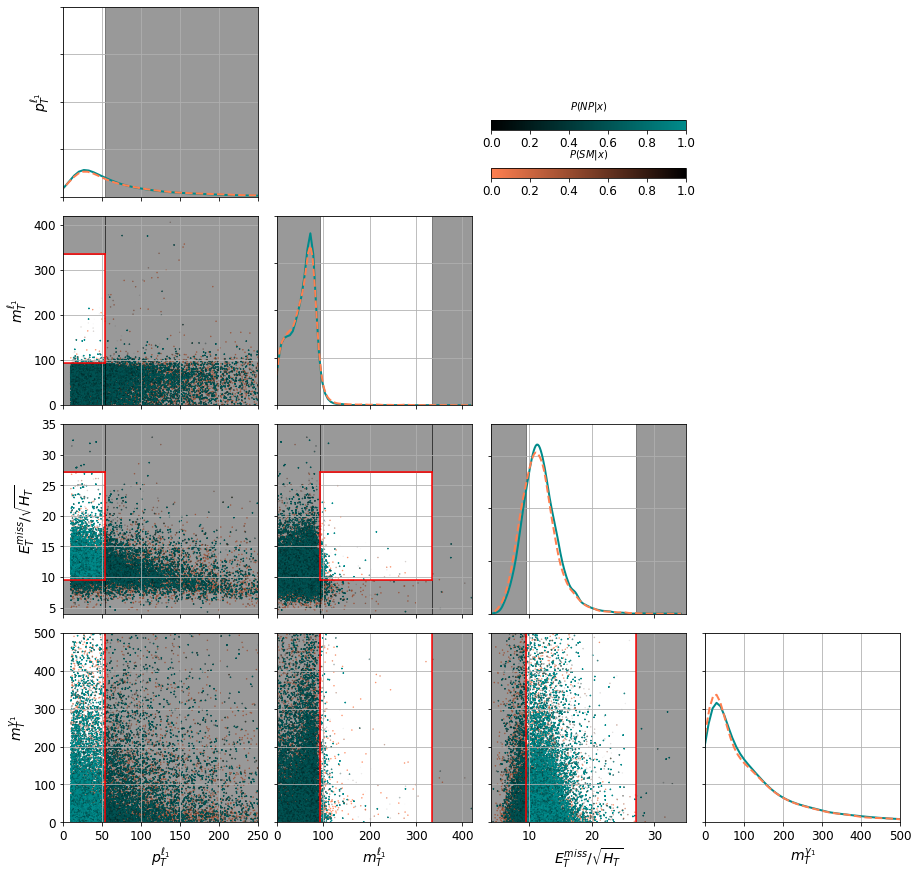

In [596]:
SM = df_test.loc[df_test['bkg_flag_pool'] != 0]
NP = df_test.loc[df_test['bkg_flag_pool'] == 1]

pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

rand_ind = np.random.choice(range(len(NP)), size =  10000, replace = False)
NP = NP.iloc[rand_ind]
pred_XG_NP = pred_XG_NP[rand_ind]

rand_ind = np.random.choice(range(len(SM)), size =  10000, replace = False)
SM = SM.iloc[rand_ind]
pred_XG_SM = pred_XG_SM[rand_ind]

limites = [[0,250], [0,420], [4,35], [0,500]]
ylimites = [[0,0.08], [0,0.02], [0,0.18], [0,0.01]]

fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = '--')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].set_ylim(ylimites[i])
            else:
                im_SM = ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 0.8, marker = '.', 
                                        c = pred_XG_SM, cmap = SM_cmap, vmin = 0, vmax = 1, alpha = (1-pred_XG_SM))
                im_NP = ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 0.8, marker = '*', 
                                        c = pred_XG_NP, cmap = NP_cmap, vmin = 0, vmax = 1, alpha = pred_XG_NP)
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = sup_cuts[imp_vars[j]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = -1, x2 = inf_cuts[imp_vars[j]], color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = sup_cuts[imp_vars[i]], y2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = -1, y2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel(imp_vars_labels[0], fontsize = 14)
ax[3,1].set_xlabel(imp_vars_labels[1], fontsize = 14)
ax[3,2].set_xlabel(imp_vars_labels[2], fontsize = 14)
ax[3,3].set_xlabel(imp_vars_labels[3], fontsize = 14)

ax[0,0].set_ylabel(imp_vars_labels[0], fontsize = 14)
ax[1,0].set_ylabel(imp_vars_labels[1], fontsize = 14)
ax[2,0].set_ylabel(imp_vars_labels[2], fontsize = 14)
ax[3,0].set_ylabel(imp_vars_labels[3], fontsize = 14)

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])

cbar_SM = plt.colorbar(im_SM, ax = ax[0,2], orientation = 'horizontal')
cbar_SM.set_label('$P(SM|x)$', labelpad=-50)
cbar_NP = plt.colorbar(im_NP, ax = ax[0,2], orientation = 'horizontal')
cbar_NP.set_label('$P(NP|x)$', labelpad=-50)

plt.savefig('../graph/BP' + str(bp+1) + '/ImpVars_dist_MET200.pdf')

## BinnedLikelihood

In [597]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(37315,)
(270992,)


In [598]:
B_expected = int(B_expected)

In [599]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, int(B_expected), range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  135 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  135
range of our data:  [[0, 1]]


In [600]:
# Z Poisson Bin Likelihood (Asimov data set)
D_or_E = 'discovery'
store_Z_asimov = []

Z_asimov = Z_BL_asimov(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), 25, range_dat, MIN_EVS, linear_bins=True) 
store_Z_asimov.append( Z_asimov )
    
    
print('\n FINAL RESULT for BP' + str(bp+1) + ':\n')
print(store_Z_asimov)


 FINAL RESULT for BP10:

[0.9706547718677011]


B_expected:  22535
S_expected:  20.263040622000005

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


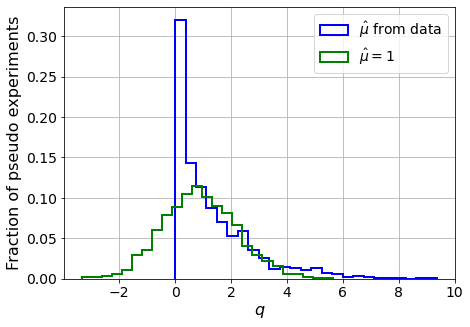

muhat mean:  0.9979250000000001
Z_bins:  0.9242206987593006
std Z_bins:  0.7921721364194517
Z_bins mu=0:  0.9262762177665688
std Z_bins mu=0:  0.718590082221114

--------


 FINAL RESULT:

[[0.9242206987593006, 0.7921721364194517, 0.9979250000000001, 0.9262762177665688, 0.718590082221114]]


In [601]:
# requested number of pseudo experiments
num_pseudo = 2000

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

B_expected:  22535
S_expected:  20.263040622000005

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


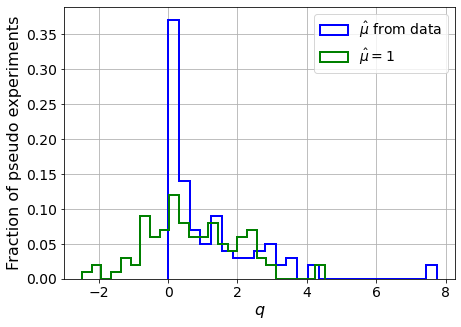

muhat mean:  0.8969009298395165
Z_bins:  0.7596611779663035
std Z_bins:  0.9603889455933634
Z_bins mu=0:  0.7339918281750933
std Z_bins mu=0:  0.9062764869893215

--------


 FINAL RESULT:

[[0.7596611779663035, 0.9603889455933634, 0.8969009298395165, 0.7339918281750933, 0.9062764869893215]]


In [602]:
# requested number of pseudo experiments
num_pseudo = 100

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

## loop pseudo exps. Fix ML and KDE

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  2711.37220722
  2605.76672645  2471.96687306  2306.72883689  2125.62295396
  1898.01806677  1601.62075194  1251.22505673   832.27001277
   322.35403716  -285.61482491 -1023.87015973 -2093.690537  ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf


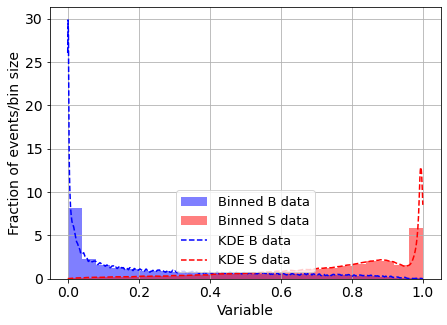

KDE Kernel:  epanechnikov
Background bandwidth:  0.0031053121543406503
Signal bandwidth:  0.008287452507534925


In [175]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        20000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

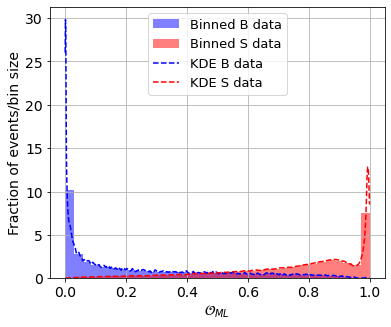

In [176]:
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

# points
s_vals = np.linspace(min_val,max_val,1000)

# evaluate the PDFs for each value of s
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# normalize
dens_bkg = dens_bkg / norm_factor_SM
dens_sig = dens_sig / norm_factor_NP

plt.figure(figsize=(6,5))

plt.hist(pred_XG_SM, 35, range=[min_val,max_val], density=True, color='blue',alpha=0.5, linewidth=2, label=r'Binned B data');
plt.hist(pred_XG_NP, 35, range=[min_val,max_val], density=True, color='red',alpha=0.5, linewidth=2, label=r'Binned S data');

plt.plot(s_vals, dens_bkg, color='blue',label=r'KDE B data',linestyle='dashed');
plt.plot(s_vals, dens_sig, color='red',label=r'KDE S data',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yscale('log')
plt.xlabel("$\mathcal{O}_{ML}$",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)

plt.savefig('../graph/KDE_fit_BP' + str(bp+1) + '_MET200.pdf')

In [177]:
print(norm_factor_SM)
print(norm_factor_NP)

266.14753662758187
100.28423277903755


In [178]:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

This may take a while...
1 done
2 done


In [179]:
# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP
   

3 done
4 done


(array([58814., 60445.,  2955.,  2069.,  1720.,  1353.,  1268.,  3061.,
         5951., 13132.]),
 array([ 0.01698118,  1.30242448,  2.58786778,  3.87331107,  5.15875437,
         6.44419767,  7.72964097,  9.01508427, 10.30052756, 11.58597086,
        12.87141416]),
 [<matplotlib.patches.Polygon at 0x7efd5342bd60>])

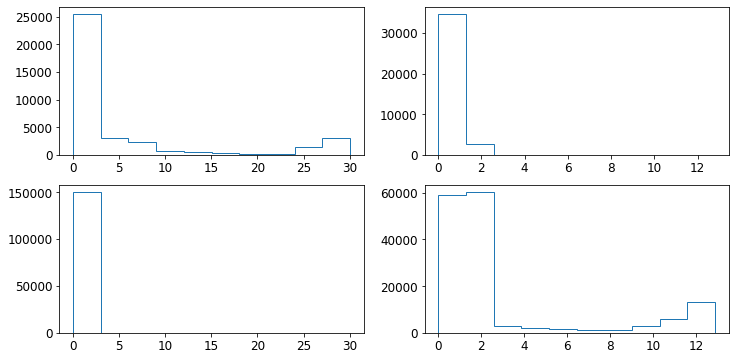

In [180]:
fig,ax = plt.subplots(2,2, figsize = (12,6))

ax[0,0].hist(pB_B_data, histtype = 'step')
ax[0,1].hist(pS_B_data, histtype = 'step')

ax[1,0].hist(pB_S_data, histtype = 'step')
ax[1,1].hist(pS_S_data, histtype = 'step')

In [181]:
# indeces (to later build a random pseudo experiment)
indices_B = [i for i in range(len(pS_B_data))]
indices_S = [i for i in range(len(pS_S_data))]
        
        

In [182]:
# loop over the number of pseudo experiments
#np.random.seed(91218)
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(3): 
    print(iloop)
    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(200)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )
            
    

    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

0


  4%|██▋                                                                 | 8/200 [00:02<00:52,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3720336407504086
<p_{s}(Sdata)> = 2.964722663540827
<p_{b}(Bdata)> = 5.592528319237187
<p_{s}(Bdata)> = 0.40504091570382283


100%|██████████████████████████████████████████████████████████████████| 200/200 [00:58<00:00,  3.42it/s]


1


100%|██████████████████████████████████████████████████████████████████| 200/200 [01:02<00:00,  3.21it/s]


2


 48%|████████████████████████████████▏                                  | 96/200 [00:27<00:28,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5363417464870184
<p_{s}(Sdata)> = 2.1614090995550552
<p_{b}(Bdata)> = 5.595212159875739
<p_{s}(Bdata)> = 0.4057559256839425


 50%|█████████████████████████████████▏                                 | 99/200 [00:28<00:27,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5139697625411936
<p_{s}(Sdata)> = 2.532399185603165
<p_{b}(Bdata)> = 5.623472240825144
<p_{s}(Bdata)> = 0.4034399653275438


100%|██████████████████████████████████████████████████████████████████| 200/200 [00:57<00:00,  3.49it/s]


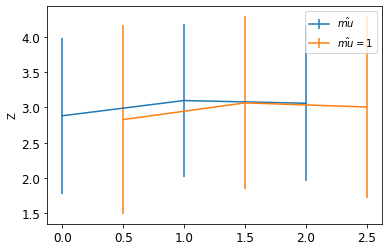

In [185]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP' + str(bp+1) + '_KDEfijo_MET200.pdf')

In [192]:
print('Z_MLL BP' + str(bp+1) + ': ' + str(np.mean(Z_MLL)) + ' +/- ' + str(np.std(Z_MLL))+
      ' +/- ' + str(np.mean(Z_MLL_std)))

Z_MLL BP1: 3.013632929980421 +/- 0.09409184220745251 +/- 1.098003789029043


## Loop varying KDE

In [ ]:
B_expected

In [ ]:
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(20):
    print(iloop)
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(50)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

In [ ]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP6_50000_KDEvariable__MET200.pdf')

## loop varying ML

In [603]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

0
AUC:0.939420091584755
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


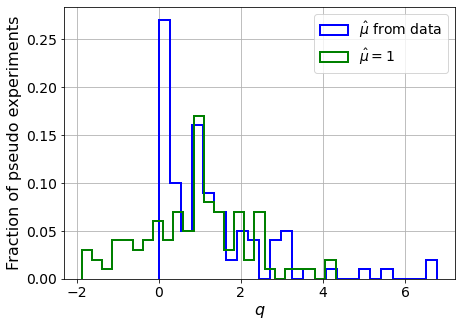

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  7980.57539754  7835.94319427  7633.84948062
  7366.38041973  7031.95457547  6598.82543082  6074.61816616
  5437.30954878  4664.14688775  3731.14973294  2652.62043494
  1380.12556877   -91.86113514 -1732.73326519 -3844.23802171]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  9712.38817827  9497.94793835


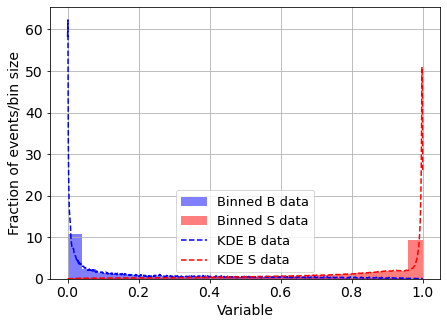

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done
3 done
4 done


  0%|▏                                                                  | 6/2000 [00:01<11:00,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2753573374488022
<p_{s}(Sdata)> = 6.3996612923012055
<p_{b}(Bdata)> = 12.626068626060345
<p_{s}(Bdata)> = 0.28194346291889766
There are events with p(s)=0


  0%|▎                                                                  | 9/2000 [00:02<08:26,  3.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26552287766028754
<p_{s}(Sdata)> = 6.533159292923687
<p_{b}(Bdata)> = 12.502357686599048
<p_{s}(Bdata)> = 0.2810291189432736


  1%|▍                                                                 | 12/2000 [00:03<09:07,  3.63it/s]

There are events with p(s)=0


  1%|▋                                                                 | 20/2000 [00:05<09:21,  3.52it/s]

There are events with p(s)=0


  1%|▊                                                                 | 23/2000 [00:06<06:45,  4.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21673882293623453
<p_{s}(Sdata)> = 13.30380388093467
<p_{b}(Bdata)> = 12.44567802095456
<p_{s}(Bdata)> = 0.28208537226803143
muhat = 2.1
<p_{b}(Sdata)> = 0.24031182720105188
<p_{s}(Sdata)> = 18.838875985042673
<p_{b}(Bdata)> = 12.618127182432298
<p_{s}(Bdata)> = 0.28691260215017145


  1%|▊                                                                 | 25/2000 [00:06<08:06,  4.06it/s]

There are events with p(s)=0


  1%|▉                                                                 | 28/2000 [00:07<06:53,  4.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2769237989033591
<p_{s}(Sdata)> = 10.146236923198925
<p_{b}(Bdata)> = 12.538423238896671
<p_{s}(Bdata)> = 0.2825697842913006


  2%|█                                                                 | 32/2000 [00:08<08:22,  3.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35700600974585445
<p_{s}(Sdata)> = 5.704481396951406
<p_{b}(Bdata)> = 12.724597153567757
<p_{s}(Bdata)> = 0.28580651119703976


  2%|█                                                                 | 34/2000 [00:08<07:10,  4.57it/s]

There are events with p(s)=0


  2%|█▏                                                                | 36/2000 [00:09<08:42,  3.76it/s]

There are events with p(s)=0


  2%|█▎                                                                | 38/2000 [00:10<11:16,  2.90it/s]

There are events with p(s)=0


  2%|█▍                                                                | 42/2000 [00:11<08:18,  3.93it/s]

There are events with p(s)=0


  2%|█▌                                                                | 46/2000 [00:12<12:20,  2.64it/s]

There are events with p(s)=0


  2%|█▌                                                                | 47/2000 [00:13<12:58,  2.51it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.22581151402247113
<p_{s}(Sdata)> = 14.745920300552704
<p_{b}(Bdata)> = 12.736624836544168
<p_{s}(Bdata)> = 0.2886857924919316


  3%|█▋                                                                | 51/2000 [00:13<08:25,  3.86it/s]

There are events with p(s)=0


  3%|█▉                                                                | 59/2000 [00:16<07:26,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26539772378212806
<p_{s}(Sdata)> = 7.431561140220022
<p_{b}(Bdata)> = 12.698483278056111
<p_{s}(Bdata)> = 0.28074879853238766


  3%|██                                                                | 62/2000 [00:16<05:53,  5.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24013705522658227
<p_{s}(Sdata)> = 5.308001048057835
<p_{b}(Bdata)> = 12.520997597542621
<p_{s}(Bdata)> = 0.2868756965164195
muhat = -0.1
<p_{b}(Sdata)> = 0.37399455019959804
<p_{s}(Sdata)> = 6.102572097394877
<p_{b}(Bdata)> = 12.60631710005929
<p_{s}(Bdata)> = 0.2768415191673136


  3%|██                                                                | 64/2000 [00:17<06:11,  5.21it/s]

There are events with p(s)=0


  3%|██▏                                                               | 65/2000 [00:17<06:40,  4.83it/s]

There are events with p(s)=0


  4%|██▌                                                               | 79/2000 [00:21<09:19,  3.44it/s]

There are events with p(s)=0


  4%|██▋                                                               | 80/2000 [00:21<09:23,  3.41it/s]

There are events with p(s)=0


  5%|███▏                                                              | 96/2000 [00:25<06:23,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3546147645199091
<p_{s}(Sdata)> = 1.3016437304421515
<p_{b}(Bdata)> = 12.559179665061684
<p_{s}(Bdata)> = 0.2817592611571803
There are events with p(s)=0
There are events with p(s)=0


  5%|███▏                                                              | 97/2000 [00:25<07:42,  4.12it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.29956555257520645
<p_{s}(Sdata)> = 6.955826892944886
<p_{b}(Bdata)> = 12.637390038667961
<p_{s}(Bdata)> = 0.2783894371538498


  5%|███▍                                                             | 107/2000 [00:28<08:07,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2178190893173876
<p_{s}(Sdata)> = 8.604783123755608
<p_{b}(Bdata)> = 12.763467624101978
<p_{s}(Bdata)> = 0.27580671920163263
There are events with p(s)=0


  6%|███▋                                                             | 112/2000 [00:29<07:37,  4.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2528751613243418
<p_{s}(Sdata)> = 7.560505663576978
<p_{b}(Bdata)> = 12.491023613527455
<p_{s}(Bdata)> = 0.2768081871850791
There are events with p(s)=0


  6%|███▉                                                             | 122/2000 [00:31<05:58,  5.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19531152422653547
<p_{s}(Sdata)> = 14.562749874061018
<p_{b}(Bdata)> = 12.60297150581495
<p_{s}(Bdata)> = 0.2949566149864664
There are events with p(s)=0


  7%|████▎                                                            | 131/2000 [00:34<07:57,  3.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22777542463608932
<p_{s}(Sdata)> = 6.445144477176143
<p_{b}(Bdata)> = 12.392669506419566
<p_{s}(Bdata)> = 0.27555342656960935


  7%|████▎                                                            | 133/2000 [00:34<06:53,  4.51it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20916450710213805
<p_{s}(Sdata)> = 15.648332329756437
<p_{b}(Bdata)> = 12.676951612478222
<p_{s}(Bdata)> = 0.28883694223283424


  7%|████▍                                                            | 137/2000 [00:35<08:54,  3.49it/s]

There are events with p(s)=0


  7%|████▍                                                            | 138/2000 [00:36<08:42,  3.56it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.18838501915144779
<p_{s}(Sdata)> = 19.0226100664225
<p_{b}(Bdata)> = 12.644653269608172
<p_{s}(Bdata)> = 0.2781127564576312


  7%|████▌                                                            | 140/2000 [00:36<07:12,  4.30it/s]

There are events with p(s)=0


  7%|████▌                                                            | 142/2000 [00:37<08:34,  3.61it/s]

There are events with p(s)=0


  8%|████▉                                                            | 151/2000 [00:39<05:17,  5.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26659074948290207
<p_{s}(Sdata)> = 5.842421506064274
<p_{b}(Bdata)> = 12.49153952460203
<p_{s}(Bdata)> = 0.27756431901063483
muhat = -0.1
<p_{b}(Sdata)> = 0.44200551779360425
<p_{s}(Sdata)> = 0.8777834405545929
<p_{b}(Bdata)> = 12.650743247555056
<p_{s}(Bdata)> = 0.2789738799631249


  8%|████▉                                                            | 153/2000 [00:39<06:56,  4.44it/s]

There are events with p(s)=0


  8%|█████                                                            | 155/2000 [00:40<08:13,  3.74it/s]

There are events with p(s)=0


  8%|█████                                                            | 156/2000 [00:40<09:19,  3.29it/s]

There are events with p(s)=0


  8%|█████▏                                                           | 158/2000 [00:41<08:39,  3.54it/s]

There are events with p(s)=0


  8%|█████▏                                                           | 160/2000 [00:41<07:30,  4.08it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2732702323548725
<p_{s}(Sdata)> = 6.428382986927627
<p_{b}(Bdata)> = 12.61698909970078
<p_{s}(Bdata)> = 0.280113860298344


  8%|█████▎                                                           | 164/2000 [00:42<06:29,  4.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2559469336431022
<p_{s}(Sdata)> = 9.341638891190584
<p_{b}(Bdata)> = 12.543322086404896
<p_{s}(Bdata)> = 0.2724570401079032
There are events with p(s)=0


  8%|█████▍                                                           | 166/2000 [00:42<07:13,  4.23it/s]

There are events with p(s)=0


  8%|█████▍                                                           | 168/2000 [00:43<09:01,  3.38it/s]

There are events with p(s)=0


  9%|█████▊                                                           | 179/2000 [00:47<08:11,  3.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3270051434429338
<p_{s}(Sdata)> = 7.047684384702034
<p_{b}(Bdata)> = 12.470561747187158
<p_{s}(Bdata)> = 0.28352789025840014


 10%|██████▍                                                          | 197/2000 [00:50<03:45,  8.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23090915886118937
<p_{s}(Sdata)> = 6.3578437524163
<p_{b}(Bdata)> = 12.646528793405574
<p_{s}(Bdata)> = 0.28123472152364776
muhat = -0.1
<p_{b}(Sdata)> = 0.2864567130578543
<p_{s}(Sdata)> = 7.82507119319933
<p_{b}(Bdata)> = 12.801982746907452
<p_{s}(Bdata)> = 0.2748171216954406


 11%|██████▉                                                          | 214/2000 [00:54<07:43,  3.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25119614409353813
<p_{s}(Sdata)> = 14.475193214193197
<p_{b}(Bdata)> = 12.094184266652643
<p_{s}(Bdata)> = 0.29477439956070123


 12%|███████▌                                                         | 234/2000 [01:00<09:47,  3.01it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.1543610379078035
<p_{s}(Sdata)> = 20.27971152919733
<p_{b}(Bdata)> = 12.373664038375557
<p_{s}(Bdata)> = 0.29006307206144605


 12%|███████▉                                                         | 245/2000 [01:03<08:01,  3.65it/s]

There are events with p(s)=0


 13%|████████▎                                                        | 254/2000 [01:05<07:41,  3.78it/s]

There are events with p(s)=0


 13%|████████▎                                                        | 257/2000 [01:06<09:05,  3.19it/s]

There are events with p(s)=0


 13%|████████▌                                                        | 265/2000 [01:08<07:28,  3.87it/s]

There are events with p(s)=0


 13%|████████▋                                                        | 266/2000 [01:09<08:02,  3.60it/s]

There are events with p(s)=0


 14%|████████▊                                                        | 272/2000 [01:10<05:18,  5.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18235050357005306
<p_{s}(Sdata)> = 9.413492570263644
<p_{b}(Bdata)> = 12.460407340844794
<p_{s}(Bdata)> = 0.2804540085800344
muhat = -0.1
<p_{b}(Sdata)> = 0.25106051944584007
<p_{s}(Sdata)> = 6.774443814960639
<p_{b}(Bdata)> = 12.273095999018423
<p_{s}(Bdata)> = 0.2808314039350317


 14%|████████▊                                                        | 273/2000 [01:10<07:21,  3.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17562016629019694
<p_{s}(Sdata)> = 20.123597462249986
<p_{b}(Bdata)> = 12.50120001319885
<p_{s}(Bdata)> = 0.28950563036308485


 14%|████████▉                                                        | 276/2000 [01:11<07:15,  3.96it/s]

There are events with p(s)=0


 14%|█████████▎                                                       | 286/2000 [01:14<07:09,  3.99it/s]

There are events with p(s)=0


 15%|█████████▍                                                       | 292/2000 [01:16<08:32,  3.33it/s]

There are events with p(s)=0


 15%|█████████▌                                                       | 295/2000 [01:17<09:34,  2.97it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17858723911406332
<p_{s}(Sdata)> = 16.588633446304147
<p_{b}(Bdata)> = 12.49376912032813
<p_{s}(Bdata)> = 0.28824384529618835


 15%|█████████▊                                                       | 301/2000 [01:18<07:52,  3.60it/s]

There are events with p(s)=0


 15%|█████████▉                                                       | 305/2000 [01:20<07:32,  3.75it/s]

There are events with p(s)=0


 15%|█████████▉                                                       | 306/2000 [01:20<09:09,  3.09it/s]

There are events with p(s)=0


 15%|█████████▉                                                       | 307/2000 [01:20<09:16,  3.04it/s]

There are events with p(s)=0


 15%|██████████                                                       | 308/2000 [01:21<10:37,  2.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24009599427454498
<p_{s}(Sdata)> = 3.0737011290690868
<p_{b}(Bdata)> = 12.33885822839866
<p_{s}(Bdata)> = 0.2814691202849437


 16%|██████████▍                                                      | 321/2000 [01:24<05:45,  4.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27539838409169226
<p_{s}(Sdata)> = 4.729285798140404
<p_{b}(Bdata)> = 12.595023294550023
<p_{s}(Bdata)> = 0.27925730436723917
muhat = -0.1
<p_{b}(Sdata)> = 0.26438241200501417
<p_{s}(Sdata)> = 2.55920697495675
<p_{b}(Bdata)> = 12.364640426151675
<p_{s}(Bdata)> = 0.2822245976589077
There are events with p(s)=0


 16%|██████████▌                                                      | 324/2000 [01:25<08:09,  3.43it/s]

There are events with p(s)=0


 17%|███████████▏                                                     | 343/2000 [01:31<07:30,  3.68it/s]

There are events with p(s)=0


 17%|███████████▎                                                     | 349/2000 [01:32<07:08,  3.86it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.256004939447287
<p_{s}(Sdata)> = 8.242912011163963
<p_{b}(Bdata)> = 12.730280840420834
<p_{s}(Bdata)> = 0.27665968596365353


 18%|███████████▍                                                     | 353/2000 [01:33<04:38,  5.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2691772623092834
<p_{s}(Sdata)> = 7.2056571494071635
<p_{b}(Bdata)> = 12.543038344240292
<p_{s}(Bdata)> = 0.27702089655564316
There are events with p(s)=0
There are events with p(s)=0


 18%|███████████▌                                                     | 356/2000 [01:33<05:26,  5.03it/s]

There are events with p(s)=0


 18%|███████████▋                                                     | 359/2000 [01:34<04:38,  5.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3081079911580544
<p_{s}(Sdata)> = 6.014294875448277
<p_{b}(Bdata)> = 12.417223561920153
<p_{s}(Bdata)> = 0.283648432734212
muhat = -0.1
<p_{b}(Sdata)> = 0.34766703994186826
<p_{s}(Sdata)> = 8.084136195588375
<p_{b}(Bdata)> = 12.413656517465803
<p_{s}(Bdata)> = 0.27929240469116984


 18%|███████████▋                                                     | 360/2000 [01:34<04:41,  5.82it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.14077706819329694
<p_{s}(Sdata)> = 17.986118490003424
<p_{b}(Bdata)> = 12.598062162770754
<p_{s}(Bdata)> = 0.29520778568814704


 18%|███████████▉                                                     | 369/2000 [01:37<07:57,  3.42it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.4519992759081261
<p_{s}(Sdata)> = 3.6678242573076076
<p_{b}(Bdata)> = 12.497361409371832
<p_{s}(Bdata)> = 0.2784155665787563


 19%|████████████▏                                                    | 374/2000 [01:38<05:32,  4.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24421718699010012
<p_{s}(Sdata)> = 11.256683874460267
<p_{b}(Bdata)> = 12.563695817268865
<p_{s}(Bdata)> = 0.27116128440164017
muhat = -0.1
<p_{b}(Sdata)> = 0.22984628169612792
<p_{s}(Sdata)> = 6.165600238761482
<p_{b}(Bdata)> = 12.566442206932182
<p_{s}(Bdata)> = 0.2769184019223654


 19%|████████████▎                                                    | 379/2000 [01:39<04:01,  6.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3600672078826545
<p_{s}(Sdata)> = 1.17862688753176
<p_{b}(Bdata)> = 12.650376245175138
<p_{s}(Bdata)> = 0.28704274332266905


 19%|████████████▌                                                    | 387/2000 [01:41<07:53,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25514828573420895
<p_{s}(Sdata)> = 7.916082105087757
<p_{b}(Bdata)> = 12.223056336616704
<p_{s}(Bdata)> = 0.28404282820921695


 20%|████████████▊                                                    | 396/2000 [01:43<05:54,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23780871263091777
<p_{s}(Sdata)> = 7.357363948182835
<p_{b}(Bdata)> = 12.653752078201371
<p_{s}(Bdata)> = 0.28383008156647005


 20%|█████████████                                                    | 401/2000 [01:44<05:20,  4.99it/s]

There are events with p(s)=0


 20%|█████████████▏                                                   | 404/2000 [01:45<05:43,  4.65it/s]

There are events with p(s)=0


 20%|█████████████▎                                                   | 409/2000 [01:46<08:27,  3.13it/s]

There are events with p(s)=0


 21%|█████████████▍                                                   | 412/2000 [01:47<08:07,  3.25it/s]

There are events with p(s)=0


 21%|█████████████▍                                                   | 415/2000 [01:48<06:34,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21016152213812744
<p_{s}(Sdata)> = 5.0721364983792
<p_{b}(Bdata)> = 12.253402920864351
<p_{s}(Bdata)> = 0.2802021475102057
There are events with p(s)=0


 21%|█████████████▌                                                   | 419/2000 [01:49<06:38,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2867483014801831
<p_{s}(Sdata)> = 12.035525136671941
<p_{b}(Bdata)> = 12.588059638890604
<p_{s}(Bdata)> = 0.27825462218165997


 21%|█████████████▊                                                   | 425/2000 [01:50<06:57,  3.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30994094743434886
<p_{s}(Sdata)> = 6.752599955802066
<p_{b}(Bdata)> = 12.423088824168076
<p_{s}(Bdata)> = 0.279163652486733


 22%|██████████████▏                                                  | 435/2000 [01:53<05:31,  4.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24232299733929208
<p_{s}(Sdata)> = 5.349364439894732
<p_{b}(Bdata)> = 12.61356883527001
<p_{s}(Bdata)> = 0.2782716941862696


 22%|██████████████▏                                                  | 438/2000 [01:54<06:07,  4.25it/s]

There are events with p(s)=0


 22%|██████████████▌                                                  | 449/2000 [01:57<06:31,  3.97it/s]

There are events with p(s)=0


 23%|██████████████▊                                                  | 455/2000 [01:58<04:40,  5.51it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2288542474277289
<p_{s}(Sdata)> = 7.351464659857379
<p_{b}(Bdata)> = 12.560019518753014
<p_{s}(Bdata)> = 0.3022151821773868
muhat = -0.1
<p_{b}(Sdata)> = 0.33512344886184847
<p_{s}(Sdata)> = 4.109004511005213
<p_{b}(Bdata)> = 12.520799951304744
<p_{s}(Bdata)> = 0.27807571013933097
muhat = 2.1
<p_{b}(Sdata)> = 0.2326228188877311
<p_{s}(Sdata)> = 11.739895588236436
<p_{b}(Bdata)> = 12.856839545128157
<p_{s}(Bdata)> = 0.29186612933726347


 23%|██████████████▊                                                  | 457/2000 [01:58<04:08,  6.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24511222330950883
<p_{s}(Sdata)> = 3.118988573354322
<p_{b}(Bdata)> = 12.386645456594538
<p_{s}(Bdata)> = 0.28424292204211293


 23%|██████████████▉                                                  | 459/2000 [01:58<04:33,  5.63it/s]

There are events with p(s)=0


 23%|██████████████▉                                                  | 461/2000 [01:59<05:35,  4.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2980817982271447
<p_{s}(Sdata)> = 4.050827706697052
<p_{b}(Bdata)> = 12.526442194410208
<p_{s}(Bdata)> = 0.28383416428749847


 23%|███████████████                                                  | 464/2000 [02:00<06:01,  4.25it/s]

There are events with p(s)=0


 23%|███████████████▏                                                 | 466/2000 [02:00<06:17,  4.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29472464926008757
<p_{s}(Sdata)> = 7.413876174776528
<p_{b}(Bdata)> = 12.76088357675375
<p_{s}(Bdata)> = 0.27918297018618965


 24%|███████████████▊                                                 | 485/2000 [02:04<04:23,  5.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39863156359933993
<p_{s}(Sdata)> = 4.345595376347484
<p_{b}(Bdata)> = 12.582200454959997
<p_{s}(Bdata)> = 0.283785286015335
muhat = -0.1
<p_{b}(Sdata)> = 0.20925321414059087
<p_{s}(Sdata)> = 6.916728464643726
<p_{b}(Bdata)> = 12.598133206661858
<p_{s}(Bdata)> = 0.2772487456345078


 24%|███████████████▊                                                 | 488/2000 [02:05<04:18,  5.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21078662693373107
<p_{s}(Sdata)> = 17.388339753987193
<p_{b}(Bdata)> = 12.272964679181674
<p_{s}(Bdata)> = 0.29471567044595487


 25%|███████████████▉                                                 | 491/2000 [02:05<05:06,  4.92it/s]

There are events with p(s)=0


 25%|████████████████                                                 | 494/2000 [02:06<07:19,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3158577154104267
<p_{s}(Sdata)> = 5.025208114867383
<p_{b}(Bdata)> = 12.715143876358912
<p_{s}(Bdata)> = 0.275517791931414


 25%|████████████████▎                                                | 501/2000 [02:08<04:59,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26103536134200955
<p_{s}(Sdata)> = 9.02633927943397
<p_{b}(Bdata)> = 12.502776085382047
<p_{s}(Bdata)> = 0.2772843260942932
There are events with p(s)=0


 25%|████████████████▍                                                | 505/2000 [02:09<04:51,  5.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26965427577187906
<p_{s}(Sdata)> = 4.699562225258744
<p_{b}(Bdata)> = 12.566019122453092
<p_{s}(Bdata)> = 0.2834630581391618
muhat = 2.1
<p_{b}(Sdata)> = 0.21607572799945413
<p_{s}(Sdata)> = 18.065116817700716
<p_{b}(Bdata)> = 12.864669388695715
<p_{s}(Bdata)> = 0.2795011184218343


 26%|█████████████████                                                | 525/2000 [02:15<08:42,  2.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33864102599299223
<p_{s}(Sdata)> = 5.931024795513748
<p_{b}(Bdata)> = 12.486938029711022
<p_{s}(Bdata)> = 0.2771931917237317


 26%|█████████████████▏                                               | 530/2000 [02:16<06:18,  3.89it/s]

There are events with p(s)=0


 27%|█████████████████▎                                               | 531/2000 [02:17<07:30,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30005074769969275
<p_{s}(Sdata)> = 6.842507113647638
<p_{b}(Bdata)> = 12.693421667276189
<p_{s}(Bdata)> = 0.27707077377143374


 27%|█████████████████▍                                               | 537/2000 [02:18<06:22,  3.82it/s]

There are events with p(s)=0


 27%|█████████████████▌                                               | 542/2000 [02:19<07:22,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2082501672339086
<p_{s}(Sdata)> = 4.473369666992835
<p_{b}(Bdata)> = 12.593852345925557
<p_{s}(Bdata)> = 0.2813704873321034


 27%|█████████████████▋                                               | 544/2000 [02:20<06:36,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22830885844943816
<p_{s}(Sdata)> = 10.162859049273905
<p_{b}(Bdata)> = 12.680141592313248
<p_{s}(Bdata)> = 0.2747594575842876


 28%|█████████████████▉                                               | 550/2000 [02:22<07:51,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2635661076746839
<p_{s}(Sdata)> = 7.626631861402059
<p_{b}(Bdata)> = 12.449295199926626
<p_{s}(Bdata)> = 0.27942946640699884


 28%|██████████████████                                               | 554/2000 [02:22<04:16,  5.63it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.21111417120020695
<p_{s}(Sdata)> = 6.836422718650711
<p_{b}(Bdata)> = 12.627084346730818
<p_{s}(Bdata)> = 0.27408571865306247
muhat = -0.1
<p_{b}(Sdata)> = 0.17823551515034597
<p_{s}(Sdata)> = 6.946609613222672
<p_{b}(Bdata)> = 12.836639646085798
<p_{s}(Bdata)> = 0.2734051227136795
There are events with p(s)=0


 28%|██████████████████▎                                              | 563/2000 [02:24<05:57,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19795496469160867
<p_{s}(Sdata)> = 9.548790910864481
<p_{b}(Bdata)> = 12.464016169341852
<p_{s}(Bdata)> = 0.2755544318848728


 28%|██████████████████▍                                              | 566/2000 [02:25<05:17,  4.51it/s]

There are events with p(s)=0


 28%|██████████████████▍                                              | 568/2000 [02:25<06:25,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33467131365254776
<p_{s}(Sdata)> = 9.752041410927553
<p_{b}(Bdata)> = 12.752603666738672
<p_{s}(Bdata)> = 0.2783398357927868


 29%|██████████████████▌                                              | 573/2000 [02:26<03:52,  6.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26661612590641204
<p_{s}(Sdata)> = 9.257695112198572
<p_{b}(Bdata)> = 12.238284714323173
<p_{s}(Bdata)> = 0.2794300501404915
muhat = -0.1
<p_{b}(Sdata)> = 0.2087330357924676
<p_{s}(Sdata)> = 11.128393361586697
<p_{b}(Bdata)> = 12.531824483419454
<p_{s}(Bdata)> = 0.2791247638969034


 29%|███████████████████                                              | 586/2000 [02:30<05:33,  4.24it/s]

There are events with p(s)=0


 30%|███████████████████▏                                             | 590/2000 [02:31<06:23,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31462343827738376
<p_{s}(Sdata)> = 4.451487217574135
<p_{b}(Bdata)> = 12.45183243186655
<p_{s}(Bdata)> = 0.27837533940673836


 30%|███████████████████▏                                             | 592/2000 [02:31<05:34,  4.21it/s]

There are events with p(s)=0


 30%|███████████████████▋                                             | 605/2000 [02:35<06:55,  3.36it/s]

There are events with p(s)=0


 30%|███████████████████▋                                             | 606/2000 [02:35<06:26,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25462707029693227
<p_{s}(Sdata)> = 4.223501959197569
<p_{b}(Bdata)> = 12.665462232795857
<p_{s}(Bdata)> = 0.2759426483625251


 30%|███████████████████▊                                             | 610/2000 [02:36<04:04,  5.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24299132078633962
<p_{s}(Sdata)> = 3.294484381672379
<p_{b}(Bdata)> = 12.427845009679679
<p_{s}(Bdata)> = 0.2848736064984522
muhat = -0.1
<p_{b}(Sdata)> = 0.32895458823360524
<p_{s}(Sdata)> = 5.403422091776645
<p_{b}(Bdata)> = 12.72973772658243
<p_{s}(Bdata)> = 0.2857979199921947


 31%|███████████████████▉                                             | 612/2000 [02:37<05:17,  4.38it/s]

There are events with p(s)=0


 31%|████████████████████▍                                            | 627/2000 [02:41<04:47,  4.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2494300826222309
<p_{s}(Sdata)> = 9.357473297724592
<p_{b}(Bdata)> = 12.654692331570354
<p_{s}(Bdata)> = 0.28163623703149837


 31%|████████████████████▍                                            | 629/2000 [02:41<05:31,  4.14it/s]

There are events with p(s)=0


 32%|████████████████████▍                                            | 630/2000 [02:41<05:45,  3.97it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25444704006624225
<p_{s}(Sdata)> = 19.312518810772243
<p_{b}(Bdata)> = 12.591150444138897
<p_{s}(Bdata)> = 0.28910015662877525


 32%|████████████████████▋                                            | 637/2000 [02:43<03:33,  6.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2816343659660924
<p_{s}(Sdata)> = 6.998650336721141
<p_{b}(Bdata)> = 12.561011459767652
<p_{s}(Bdata)> = 0.2776567497025406
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.3596812353537533
<p_{s}(Sdata)> = 9.819565012660368
<p_{b}(Bdata)> = 12.634896560660891
<p_{s}(Bdata)> = 0.2768571166175604


 32%|████████████████████▉                                            | 645/2000 [02:45<07:01,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2229309274381509
<p_{s}(Sdata)> = 15.926529755807286
<p_{b}(Bdata)> = 12.693773102330477
<p_{s}(Bdata)> = 0.27971927840579774


 32%|█████████████████████                                            | 647/2000 [02:45<05:21,  4.21it/s]

There are events with p(s)=0


 32%|█████████████████████                                            | 649/2000 [02:46<05:48,  3.88it/s]

There are events with p(s)=0


 33%|█████████████████████▎                                           | 656/2000 [02:48<05:51,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39355973590754156
<p_{s}(Sdata)> = 6.630828658621402
<p_{b}(Bdata)> = 12.641874075729095
<p_{s}(Bdata)> = 0.2754836037694806


 33%|█████████████████████▍                                           | 660/2000 [02:49<04:45,  4.70it/s]

There are events with p(s)=0


 33%|█████████████████████▍                                           | 661/2000 [02:49<05:21,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2035151499688099
<p_{s}(Sdata)> = 5.644847237955286
<p_{b}(Bdata)> = 12.661187910786794
<p_{s}(Bdata)> = 0.28256777716919307


 33%|█████████████████████▌                                           | 665/2000 [02:50<04:16,  5.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2865069777267475
<p_{s}(Sdata)> = 7.016691297791405
<p_{b}(Bdata)> = 12.213156864953328
<p_{s}(Bdata)> = 0.28339512139299255


 33%|█████████████████████▋                                           | 667/2000 [02:50<04:00,  5.54it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.2725215104796988
<p_{s}(Sdata)> = 17.82970375560844
<p_{b}(Bdata)> = 12.392658350396609
<p_{s}(Bdata)> = 0.28783620686233735


 34%|█████████████████████▊                                           | 672/2000 [02:51<04:48,  4.61it/s]

There are events with p(s)=0


 34%|█████████████████████▉                                           | 676/2000 [02:52<05:56,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1973555776550218
<p_{s}(Sdata)> = 9.89983439114506
<p_{b}(Bdata)> = 12.628757205313516
<p_{s}(Bdata)> = 0.278816092773987


 34%|██████████████████████▎                                          | 687/2000 [02:55<05:05,  4.30it/s]

There are events with p(s)=0


 35%|██████████████████████▍                                          | 692/2000 [02:56<05:58,  3.65it/s]

There are events with p(s)=0


 35%|██████████████████████▋                                          | 697/2000 [02:58<05:26,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2698229474779883
<p_{s}(Sdata)> = 10.174829284528384
<p_{b}(Bdata)> = 12.660180542689911
<p_{s}(Bdata)> = 0.27736992075665057


 35%|██████████████████████▋                                          | 699/2000 [02:58<04:43,  4.59it/s]

There are events with p(s)=0


 35%|██████████████████████▊                                          | 702/2000 [02:58<04:09,  5.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26731842078114354
<p_{s}(Sdata)> = 2.513289473999168
<p_{b}(Bdata)> = 12.61299633846854
<p_{s}(Bdata)> = 0.2806854275953918
muhat = -0.1
<p_{b}(Sdata)> = 0.227809396492618
<p_{s}(Sdata)> = 10.076217706359948
<p_{b}(Bdata)> = 12.514122078927842
<p_{s}(Bdata)> = 0.28634418993616645


 35%|██████████████████████▉                                          | 706/2000 [03:00<05:24,  3.99it/s]

There are events with p(s)=0


 35%|███████████████████████                                          | 708/2000 [03:00<05:32,  3.89it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.5108099354125334
<p_{s}(Sdata)> = 15.035315150946348
<p_{b}(Bdata)> = 12.396539990518582
<p_{s}(Bdata)> = 0.2918390577149674


 36%|███████████████████████                                          | 711/2000 [03:01<05:24,  3.97it/s]

There are events with p(s)=0


 36%|███████████████████████▏                                         | 712/2000 [03:01<05:23,  3.98it/s]

There are events with p(s)=0


 36%|███████████████████████▏                                         | 713/2000 [03:01<05:19,  4.02it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.14049167773709767
<p_{s}(Sdata)> = 17.140811479248068
<p_{b}(Bdata)> = 12.632063797465692
<p_{s}(Bdata)> = 0.2936041008255726


 36%|███████████████████████▎                                         | 719/2000 [03:03<05:45,  3.71it/s]

There are events with p(s)=0


 36%|███████████████████████▍                                         | 721/2000 [03:03<06:09,  3.46it/s]

There are events with p(s)=0


 36%|███████████████████████▋                                         | 727/2000 [03:05<04:05,  5.18it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2771905866688815
<p_{s}(Sdata)> = 8.547628301954928
<p_{b}(Bdata)> = 12.444458114027245
<p_{s}(Bdata)> = 0.27697048865332546
muhat = -0.1
<p_{b}(Sdata)> = 0.17288977942196232
<p_{s}(Sdata)> = 11.229158855588253
<p_{b}(Bdata)> = 12.591017711252656
<p_{s}(Bdata)> = 0.27569152765402016


 36%|███████████████████████▋                                         | 728/2000 [03:05<03:57,  5.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28342633384678134
<p_{s}(Sdata)> = 12.026383771002815
<p_{b}(Bdata)> = 12.558105392977236
<p_{s}(Bdata)> = 0.285338545735638


 36%|███████████████████████▋                                         | 730/2000 [03:05<04:18,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3325683647192958
<p_{s}(Sdata)> = 1.9039056921410118
<p_{b}(Bdata)> = 12.544832561927839
<p_{s}(Bdata)> = 0.2794493819969945


 37%|███████████████████████▉                                         | 735/2000 [03:06<03:09,  6.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34689015436286424
<p_{s}(Sdata)> = 7.144025243322188
<p_{b}(Bdata)> = 12.507897274145595
<p_{s}(Bdata)> = 0.2785222312465132
muhat = -0.1
<p_{b}(Sdata)> = 0.4041928295311215
<p_{s}(Sdata)> = 7.615428704018354
<p_{b}(Bdata)> = 12.384579982242766
<p_{s}(Bdata)> = 0.28318301770361926


 37%|████████████████████████                                         | 739/2000 [03:07<05:08,  4.09it/s]

There are events with p(s)=0


 37%|████████████████████████▏                                        | 744/2000 [03:08<05:18,  3.94it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2461706966065255
<p_{s}(Sdata)> = 10.923682064327364
<p_{b}(Bdata)> = 12.5164111078051
<p_{s}(Bdata)> = 0.27576348462295525


 37%|████████████████████████▎                                        | 747/2000 [03:09<04:31,  4.61it/s]

There are events with p(s)=0


 38%|████████████████████████▍                                        | 752/2000 [03:11<06:15,  3.32it/s]

There are events with p(s)=0
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.16215034251373503
<p_{s}(Sdata)> = 22.92555764206173
<p_{b}(Bdata)> = 12.611325715405915
<p_{s}(Bdata)> = 0.2901146368160645


 38%|████████████████████████▌                                        | 755/2000 [03:11<04:41,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19834759732939697
<p_{s}(Sdata)> = 6.348849419508306
<p_{b}(Bdata)> = 12.396815534956577
<p_{s}(Bdata)> = 0.2843692663759449


 38%|████████████████████████▉                                        | 767/2000 [03:15<06:57,  2.95it/s]

There are events with p(s)=0


 38%|████████████████████████▉                                        | 768/2000 [03:15<06:53,  2.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2948006888323615
<p_{s}(Sdata)> = 7.125048928193053
<p_{b}(Bdata)> = 12.224307577726002
<p_{s}(Bdata)> = 0.28085874473340927


 39%|█████████████████████████                                        | 771/2000 [03:16<04:50,  4.23it/s]

There are events with p(s)=0


 39%|█████████████████████████▏                                       | 775/2000 [03:17<04:20,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26784414332863216
<p_{s}(Sdata)> = 3.3274956459732614
<p_{b}(Bdata)> = 12.638249561553225
<p_{s}(Bdata)> = 0.2790961644374434


 39%|█████████████████████████▍                                       | 781/2000 [03:18<05:38,  3.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21975229976945013
<p_{s}(Sdata)> = 12.59880848760806
<p_{b}(Bdata)> = 12.564305423359762
<p_{s}(Bdata)> = 0.29048948180034734


 40%|█████████████████████████▋                                       | 790/2000 [03:21<05:35,  3.61it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32018428208069366
<p_{s}(Sdata)> = 13.609558177938846
<p_{b}(Bdata)> = 12.570800201733547
<p_{s}(Bdata)> = 0.2938608743844873


 40%|█████████████████████████▉                                       | 797/2000 [03:22<03:38,  5.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27842372377943403
<p_{s}(Sdata)> = 5.207989907647532
<p_{b}(Bdata)> = 12.522481506658973
<p_{s}(Bdata)> = 0.2837241004688688
There are events with p(s)=0


 40%|██████████████████████████                                       | 800/2000 [03:22<02:54,  6.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2907277300198412
<p_{s}(Sdata)> = 3.29011263786996
<p_{b}(Bdata)> = 12.518847779458675
<p_{s}(Bdata)> = 0.27215664796989897
muhat = -0.1
<p_{b}(Sdata)> = 0.24700666931003373
<p_{s}(Sdata)> = 6.250566436489417
<p_{b}(Bdata)> = 12.470123237944426
<p_{s}(Bdata)> = 0.2818733269557524


 40%|██████████████████████████                                       | 802/2000 [03:23<02:57,  6.74it/s]

There are events with p(s)=0


 40%|██████████████████████████▏                                      | 804/2000 [03:23<03:00,  6.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.280260579485024
<p_{s}(Sdata)> = 12.256756739574366
<p_{b}(Bdata)> = 12.718309302506496
<p_{s}(Bdata)> = 0.27435806780287475
There are events with p(s)=0


 40%|██████████████████████████▏                                      | 807/2000 [03:24<04:40,  4.26it/s]

There are events with p(s)=0


 41%|██████████████████████████▎                                      | 811/2000 [03:25<03:48,  5.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3122746424176027
<p_{s}(Sdata)> = 5.291402238858396
<p_{b}(Bdata)> = 12.745099017518
<p_{s}(Bdata)> = 0.280571921521045


 41%|██████████████████████████▍                                      | 814/2000 [03:26<04:57,  3.99it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.1573562818532004
<p_{s}(Sdata)> = 12.746749609801212
<p_{b}(Bdata)> = 12.27964896614465
<p_{s}(Bdata)> = 0.27461663208167275


 41%|██████████████████████████▌                                      | 816/2000 [03:26<04:10,  4.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2612054445984576
<p_{s}(Sdata)> = 7.549663372794436
<p_{b}(Bdata)> = 12.620234682248043
<p_{s}(Bdata)> = 0.27969462761991787


 41%|██████████████████████████▌                                      | 819/2000 [03:26<03:37,  5.44it/s]

There are events with p(s)=0


 41%|██████████████████████████▊                                      | 824/2000 [03:28<04:10,  4.70it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20892646080566726
<p_{s}(Sdata)> = 11.606197351541255
<p_{b}(Bdata)> = 12.463403801553268
<p_{s}(Bdata)> = 0.2982218058713728
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2820246498837274
<p_{s}(Sdata)> = 9.3442428832389
<p_{b}(Bdata)> = 12.670084155095092
<p_{s}(Bdata)> = 0.27701340738905045


 41%|██████████████████████████▊                                      | 826/2000 [03:28<03:50,  5.09it/s]

There are events with p(s)=0


 41%|██████████████████████████▉                                      | 828/2000 [03:29<05:11,  3.76it/s]

There are events with p(s)=0


 42%|███████████████████████████▍                                     | 844/2000 [03:33<04:40,  4.12it/s]

There are events with p(s)=0


 42%|███████████████████████████▌                                     | 849/2000 [03:34<05:27,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5784976124536402
<p_{s}(Sdata)> = 9.933973342335987
<p_{b}(Bdata)> = 12.747147755748687
<p_{s}(Bdata)> = 0.27628310784828203
There are events with p(s)=0


 43%|███████████████████████████▊                                     | 856/2000 [03:36<05:07,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2558678784752918
<p_{s}(Sdata)> = 8.573318750028617
<p_{b}(Bdata)> = 12.593776663057644
<p_{s}(Bdata)> = 0.27491623890459616


 43%|███████████████████████████▉                                     | 860/2000 [03:37<05:26,  3.50it/s]

There are events with p(s)=0


 43%|███████████████████████████▉                                     | 861/2000 [03:37<05:05,  3.73it/s]

There are events with p(s)=0


 43%|████████████████████████████                                     | 865/2000 [03:38<06:06,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37840939421898856
<p_{s}(Sdata)> = 2.9042755856666473
<p_{b}(Bdata)> = 12.780090376730508
<p_{s}(Bdata)> = 0.28485070909520216


 44%|████████████████████████████▎                                    | 870/2000 [03:39<03:53,  4.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2047680207211071
<p_{s}(Sdata)> = 7.322010858965707
<p_{b}(Bdata)> = 12.708730955764818
<p_{s}(Bdata)> = 0.28210200232892635


 44%|████████████████████████████▎                                    | 871/2000 [03:40<04:00,  4.69it/s]

There are events with p(s)=0


 44%|████████████████████████████▌                                    | 880/2000 [03:42<05:00,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36235900656020137
<p_{s}(Sdata)> = 3.135151662829549
<p_{b}(Bdata)> = 12.385947320797081
<p_{s}(Bdata)> = 0.2797385035010936


 44%|████████████████████████████▋                                    | 882/2000 [03:43<04:59,  3.74it/s]

There are events with p(s)=0


 45%|████████████████████████████▉                                    | 892/2000 [03:46<05:56,  3.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24909415078541425
<p_{s}(Sdata)> = 8.589478597606497
<p_{b}(Bdata)> = 12.453671714446186
<p_{s}(Bdata)> = 0.27552624813330995


 45%|█████████████████████████████                                    | 895/2000 [03:47<03:56,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3976078903475485
<p_{s}(Sdata)> = 11.639085284234898
<p_{b}(Bdata)> = 12.574543887963223
<p_{s}(Bdata)> = 0.2738008963147884


 45%|█████████████████████████████▏                                   | 898/2000 [03:47<04:08,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3235865555812216
<p_{s}(Sdata)> = 6.302554640540853
<p_{b}(Bdata)> = 12.799816780236236
<p_{s}(Bdata)> = 0.2802624554173996


 45%|█████████████████████████████▎                                   | 901/2000 [03:48<04:10,  4.39it/s]

There are events with p(s)=0


 45%|█████████████████████████████▎                                   | 902/2000 [03:49<04:57,  3.70it/s]

There are events with p(s)=0


 45%|█████████████████████████████▍                                   | 905/2000 [03:49<05:23,  3.38it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.3193465422512841
<p_{s}(Sdata)> = 7.879709370160418
<p_{b}(Bdata)> = 12.62211729654048
<p_{s}(Bdata)> = 0.2780189721176472


 46%|█████████████████████████████▌                                   | 910/2000 [03:50<03:40,  4.93it/s]

There are events with p(s)=0


 46%|█████████████████████████████▋                                   | 912/2000 [03:51<03:06,  5.84it/s]

There are events with p(s)=0


 46%|█████████████████████████████▋                                   | 913/2000 [03:51<04:19,  4.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3047280385826494
<p_{s}(Sdata)> = 17.92741673792772
<p_{b}(Bdata)> = 12.463753414835885
<p_{s}(Bdata)> = 0.29039838761088116


 46%|█████████████████████████████▋                                   | 915/2000 [03:52<04:41,  3.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3078305788404109
<p_{s}(Sdata)> = 4.952769340546713
<p_{b}(Bdata)> = 12.46775818176448
<p_{s}(Bdata)> = 0.28250865397765546


 46%|█████████████████████████████▊                                   | 918/2000 [03:52<03:56,  4.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31468090659021775
<p_{s}(Sdata)> = 7.332060547564583
<p_{b}(Bdata)> = 12.384869561630202
<p_{s}(Bdata)> = 0.27956475077319004


 46%|█████████████████████████████▉                                   | 920/2000 [03:53<03:56,  4.57it/s]

There are events with p(s)=0


 46%|██████████████████████████████                                   | 925/2000 [03:54<03:29,  5.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2552211476181234
<p_{s}(Sdata)> = 6.285713302321267
<p_{b}(Bdata)> = 12.587849651084529
<p_{s}(Bdata)> = 0.2816996907862322
muhat = 2.1
<p_{b}(Sdata)> = 0.14760773064425492
<p_{s}(Sdata)> = 14.630515987689845
<p_{b}(Bdata)> = 12.556207856508253
<p_{s}(Bdata)> = 0.29316594031649434


 46%|██████████████████████████████▏                                  | 927/2000 [03:54<03:30,  5.11it/s]

There are events with p(s)=0


 47%|██████████████████████████████▎                                  | 931/2000 [03:55<03:32,  5.03it/s]

There are events with p(s)=0


 47%|██████████████████████████████▎                                  | 934/2000 [03:56<03:59,  4.45it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25519315635361267
<p_{s}(Sdata)> = 17.23062309997752
<p_{b}(Bdata)> = 12.616577148538854
<p_{s}(Bdata)> = 0.2848127022483925
There are events with p(s)=0


 47%|██████████████████████████████▍                                  | 937/2000 [03:56<03:50,  4.60it/s]

There are events with p(s)=0


 47%|██████████████████████████████▋                                  | 943/2000 [03:58<04:51,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6193218848173907
<p_{s}(Sdata)> = 3.840323862169202
<p_{b}(Bdata)> = 12.459463141963672
<p_{s}(Bdata)> = 0.286857982737847


 48%|███████████████████████████████                                  | 957/2000 [04:01<03:49,  4.55it/s]

There are events with p(s)=0


 48%|███████████████████████████████▏                                 | 959/2000 [04:02<04:30,  3.84it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1533114132616616
<p_{s}(Sdata)> = 19.615959365118144
<p_{b}(Bdata)> = 12.696927540259603
<p_{s}(Bdata)> = 0.2953557658060495


 48%|███████████████████████████████▎                                 | 964/2000 [04:03<03:51,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3694534232709951
<p_{s}(Sdata)> = 6.163183957840362
<p_{b}(Bdata)> = 12.548803581967489
<p_{s}(Bdata)> = 0.27697499408467796


 49%|███████████████████████████████▌                                 | 973/2000 [04:04<03:00,  5.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.322385000861682
<p_{s}(Sdata)> = 5.1818755868765844
<p_{b}(Bdata)> = 12.328900834583276
<p_{s}(Bdata)> = 0.28361952427069487


 49%|███████████████████████████████▋                                 | 975/2000 [04:05<02:47,  6.10it/s]

There are events with p(s)=0


 49%|████████████████████████████████                                 | 987/2000 [04:08<04:55,  3.43it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2182284803701578
<p_{s}(Sdata)> = 6.222990041222898
<p_{b}(Bdata)> = 12.474132808761535
<p_{s}(Bdata)> = 0.2818112281074777


 49%|████████████████████████████████▏                                | 989/2000 [04:08<04:27,  3.77it/s]

There are events with p(s)=0


 50%|████████████████████████████████▏                                | 991/2000 [04:09<04:01,  4.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19557042071353495
<p_{s}(Sdata)> = 10.277901126687532
<p_{b}(Bdata)> = 12.629487925435642
<p_{s}(Bdata)> = 0.2770670779075976


 50%|████████████████████████████████▎                                | 996/2000 [04:10<04:22,  3.82it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18298479864724523
<p_{s}(Sdata)> = 11.881278940173535
<p_{b}(Bdata)> = 12.583193380991238
<p_{s}(Bdata)> = 0.294593664034049
There are events with p(s)=0


 50%|████████████████████████████████▍                                | 998/2000 [04:11<03:55,  4.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1633497944495235
<p_{s}(Sdata)> = 5.512477859944642
<p_{b}(Bdata)> = 12.538074596473708
<p_{s}(Bdata)> = 0.2814245081611118


 50%|████████████████████████████████▏                               | 1005/2000 [04:12<03:56,  4.20it/s]

There are events with p(s)=0


 50%|████████████████████████████████▎                               | 1008/2000 [04:13<04:55,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23023821301374384
<p_{s}(Sdata)> = 3.5718685396701786
<p_{b}(Bdata)> = 12.635102521838505
<p_{s}(Bdata)> = 0.27384777592801895
There are events with p(s)=0


 51%|████████████████████████████████▍                               | 1013/2000 [04:14<04:01,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3000283273294003
<p_{s}(Sdata)> = 3.1612709378996184
<p_{b}(Bdata)> = 12.496720932003871
<p_{s}(Bdata)> = 0.27880771837264307


 51%|████████████████████████████████▌                               | 1018/2000 [04:15<03:02,  5.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2801767962718703
<p_{s}(Sdata)> = 3.916547570068529
<p_{b}(Bdata)> = 12.631963799174649
<p_{s}(Bdata)> = 0.2771939994757449


 51%|████████████████████████████████▋                               | 1020/2000 [04:16<03:18,  4.93it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.20477165720025475
<p_{s}(Sdata)> = 6.545420884180517
<p_{b}(Bdata)> = 12.40348624626947
<p_{s}(Bdata)> = 0.2766976555323479


 51%|████████████████████████████████▊                               | 1024/2000 [04:17<03:25,  4.74it/s]

There are events with p(s)=0


 51%|████████████████████████████████▊                               | 1025/2000 [04:17<03:36,  4.50it/s]

There are events with p(s)=0


 51%|████████████████████████████████▉                               | 1028/2000 [04:17<03:13,  5.02it/s]

There are events with p(s)=0


 52%|████████████████████████████████▉                               | 1030/2000 [04:18<04:08,  3.90it/s]

There are events with p(s)=0


 52%|████████████████████████████████▉                               | 1031/2000 [04:18<04:36,  3.50it/s]

There are events with p(s)=0


 52%|█████████████████████████████████                               | 1034/2000 [04:19<04:47,  3.36it/s]

There are events with p(s)=0


 52%|█████████████████████████████████▏                              | 1038/2000 [04:20<03:25,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.396052625131312
<p_{s}(Sdata)> = 3.0920569340615627
<p_{b}(Bdata)> = 12.407634970640856
<p_{s}(Bdata)> = 0.27650755542484534


 52%|█████████████████████████████████▏                              | 1039/2000 [04:20<03:35,  4.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3297492496706819
<p_{s}(Sdata)> = 7.470718534244258
<p_{b}(Bdata)> = 12.579034451531172
<p_{s}(Bdata)> = 0.28256925191398663


 52%|█████████████████████████████████▎                              | 1042/2000 [04:21<04:00,  3.98it/s]

There are events with p(s)=0


 52%|█████████████████████████████████▍                              | 1044/2000 [04:22<04:00,  3.98it/s]

There are events with p(s)=0


 53%|█████████████████████████████████▋                              | 1052/2000 [04:24<03:34,  4.43it/s]

There are events with p(s)=0


 53%|█████████████████████████████████▋                              | 1054/2000 [04:24<03:57,  3.99it/s]

There are events with p(s)=0


 53%|█████████████████████████████████▊                              | 1055/2000 [04:25<04:29,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7489058802541062
<p_{s}(Sdata)> = 6.11636935890967
<p_{b}(Bdata)> = 12.646959046708352
<p_{s}(Bdata)> = 0.279546643710315


 53%|█████████████████████████████████▊                              | 1058/2000 [04:25<04:25,  3.54it/s]

There are events with p(s)=0


 53%|█████████████████████████████████▉                              | 1061/2000 [04:26<03:42,  4.21it/s]

There are events with p(s)=0


 53%|██████████████████████████████████▏                             | 1068/2000 [04:28<02:55,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7283998468410536
<p_{s}(Sdata)> = 3.0445097600286317
<p_{b}(Bdata)> = 12.328710431127679
<p_{s}(Bdata)> = 0.2797155206628893


 53%|██████████████████████████████████▏                             | 1069/2000 [04:28<02:51,  5.44it/s]

There are events with p(s)=0


 54%|██████████████████████████████████▎                             | 1072/2000 [04:29<03:32,  4.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18560845166327056
<p_{s}(Sdata)> = 18.78163958028838
<p_{b}(Bdata)> = 12.353973632261681
<p_{s}(Bdata)> = 0.2973073127970043


 54%|██████████████████████████████████▍                             | 1075/2000 [04:29<03:26,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24069625438143655
<p_{s}(Sdata)> = 5.26123712987079
<p_{b}(Bdata)> = 12.601277350474254
<p_{s}(Bdata)> = 0.2836521028239237


 54%|██████████████████████████████████▋                             | 1084/2000 [04:32<04:33,  3.35it/s]

There are events with p(s)=0


 54%|██████████████████████████████████▊                             | 1087/2000 [04:32<03:52,  3.92it/s]

There are events with p(s)=0


 54%|██████████████████████████████████▊                             | 1089/2000 [04:33<03:10,  4.78it/s]

There are events with p(s)=0


 55%|███████████████████████████████████                             | 1094/2000 [04:34<03:41,  4.09it/s]

There are events with p(s)=0


 55%|███████████████████████████████████▏                            | 1099/2000 [04:35<03:24,  4.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18497095514310047
<p_{s}(Sdata)> = 20.68783888186087
<p_{b}(Bdata)> = 12.407822104790267
<p_{s}(Bdata)> = 0.2879946477236276


 55%|███████████████████████████████████▏                            | 1101/2000 [04:36<03:35,  4.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23067293554614962
<p_{s}(Sdata)> = 10.475262620153346
<p_{b}(Bdata)> = 12.458841629583523
<p_{s}(Bdata)> = 0.2939231848539324


 55%|███████████████████████████████████▍                            | 1108/2000 [04:37<02:26,  6.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25690020243468886
<p_{s}(Sdata)> = 4.653590675308068
<p_{b}(Bdata)> = 12.58095984913771
<p_{s}(Bdata)> = 0.277455182503186
muhat = -0.1
<p_{b}(Sdata)> = 0.14819868058846233
<p_{s}(Sdata)> = 13.48861907949728
<p_{b}(Bdata)> = 12.337011842641974
<p_{s}(Bdata)> = 0.2810659793486516


 56%|███████████████████████████████████▌                            | 1111/2000 [04:38<02:59,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3290045139246273
<p_{s}(Sdata)> = 2.501028667825395
<p_{b}(Bdata)> = 12.491592571668004
<p_{s}(Bdata)> = 0.28198781997850736


 56%|███████████████████████████████████▋                            | 1116/2000 [04:39<03:53,  3.78it/s]

There are events with p(s)=0


 56%|████████████████████████████████████                            | 1125/2000 [04:41<03:09,  4.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.587742037472615
<p_{s}(Sdata)> = 4.798721445041459
<p_{b}(Bdata)> = 12.688981503907115
<p_{s}(Bdata)> = 0.28210527771762883


 56%|████████████████████████████████████                            | 1126/2000 [04:41<03:25,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1651890332051483
<p_{s}(Sdata)> = 8.077499375798807
<p_{b}(Bdata)> = 12.444138498997882
<p_{s}(Bdata)> = 0.28839561888910226


 56%|████████████████████████████████████                            | 1128/2000 [04:42<03:27,  4.20it/s]

There are events with p(s)=0


 57%|████████████████████████████████████▎                           | 1134/2000 [04:44<03:57,  3.65it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2456071413560454
<p_{s}(Sdata)> = 12.706983086549416
<p_{b}(Bdata)> = 12.419200218462946
<p_{s}(Bdata)> = 0.29466659679562046


 57%|████████████████████████████████████▌                           | 1141/2000 [04:45<03:23,  4.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4359254461571097
<p_{s}(Sdata)> = 1.144667365427908
<p_{b}(Bdata)> = 12.322036315896728
<p_{s}(Bdata)> = 0.2801712934586871
There are events with p(s)=0


 57%|████████████████████████████████████▋                           | 1146/2000 [04:47<03:15,  4.36it/s]

There are events with p(s)=0


 57%|████████████████████████████████████▊                           | 1150/2000 [04:47<02:40,  5.31it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26690383076689267
<p_{s}(Sdata)> = 14.893708502336667
<p_{b}(Bdata)> = 12.57371289033253
<p_{s}(Bdata)> = 0.2974312052604348
There are events with p(s)=0


 58%|████████████████████████████████████▉                           | 1156/2000 [04:49<03:13,  4.37it/s]

There are events with p(s)=0


 58%|█████████████████████████████████████                           | 1157/2000 [04:49<03:30,  4.01it/s]

There are events with p(s)=0


 58%|█████████████████████████████████████                           | 1160/2000 [04:50<03:44,  3.74it/s]

There are events with p(s)=0


 58%|█████████████████████████████████████▏                          | 1163/2000 [04:50<02:52,  4.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39934198373416363
<p_{s}(Sdata)> = 7.389590302576141
<p_{b}(Bdata)> = 12.647747971715008
<p_{s}(Bdata)> = 0.2841227760629436
muhat = -0.1
<p_{b}(Sdata)> = 0.4262079380571216
<p_{s}(Sdata)> = 5.202577891494274
<p_{b}(Bdata)> = 12.842031572376575
<p_{s}(Bdata)> = 0.27703647753502275
There are events with p(s)=0


 58%|█████████████████████████████████████▎                          | 1167/2000 [04:51<03:19,  4.18it/s]

There are events with p(s)=0


 58%|█████████████████████████████████████▍                          | 1169/2000 [04:52<03:50,  3.61it/s]

There are events with p(s)=0


 59%|█████████████████████████████████████▍                          | 1171/2000 [04:53<04:12,  3.29it/s]

There are events with p(s)=0


 59%|█████████████████████████████████████▌                          | 1173/2000 [04:54<04:54,  2.81it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1856901459849977
<p_{s}(Sdata)> = 14.770758250273634
<p_{b}(Bdata)> = 12.394333107642346
<p_{s}(Bdata)> = 0.29010814318084605


 59%|█████████████████████████████████████▌                          | 1175/2000 [04:54<03:31,  3.90it/s]

There are events with p(s)=0


 59%|█████████████████████████████████████▋                          | 1178/2000 [04:55<03:24,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7755949802399421
<p_{s}(Sdata)> = 7.153434899264047
<p_{b}(Bdata)> = 12.34140841704284
<p_{s}(Bdata)> = 0.2785124346043487


 59%|█████████████████████████████████████▊                          | 1180/2000 [04:55<03:19,  4.11it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.3258087833417607
<p_{s}(Sdata)> = 4.9376689906229005
<p_{b}(Bdata)> = 12.653471626012708
<p_{s}(Bdata)> = 0.2784941929197979


 59%|█████████████████████████████████████▉                          | 1186/2000 [04:57<03:59,  3.41it/s]

There are events with p(s)=0


 59%|██████████████████████████████████████                          | 1188/2000 [04:57<04:05,  3.31it/s]

There are events with p(s)=0


 60%|██████████████████████████████████████▏                         | 1193/2000 [04:59<04:22,  3.08it/s]

There are events with p(s)=0


 60%|██████████████████████████████████████▏                         | 1195/2000 [05:00<04:02,  3.32it/s]

There are events with p(s)=0


 60%|██████████████████████████████████████▎                         | 1196/2000 [05:00<04:06,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3462064549763234
<p_{s}(Sdata)> = 8.726154687962822
<p_{b}(Bdata)> = 12.779779648001842
<p_{s}(Bdata)> = 0.2814362775551522


 60%|██████████████████████████████████████▋                         | 1210/2000 [05:03<02:33,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2633516337640736
<p_{s}(Sdata)> = 6.7616561215032736
<p_{b}(Bdata)> = 12.412120923435486
<p_{s}(Bdata)> = 0.28175928551817386


 61%|██████████████████████████████████████▊                         | 1211/2000 [05:03<02:18,  5.69it/s]

There are events with p(s)=0


 61%|██████████████████████████████████████▉                         | 1215/2000 [05:04<03:45,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2598412148206462
<p_{s}(Sdata)> = 6.615873477064003
<p_{b}(Bdata)> = 12.403537330657139
<p_{s}(Bdata)> = 0.2831567086378689


 61%|██████████████████████████████████████▉                         | 1218/2000 [05:05<02:52,  4.54it/s]

There are events with p(s)=0


 61%|███████████████████████████████████████▏                        | 1224/2000 [05:07<03:32,  3.65it/s]

There are events with p(s)=0


 61%|███████████████████████████████████████▎                        | 1227/2000 [05:08<03:29,  3.68it/s]

There are events with p(s)=0


 62%|███████████████████████████████████████▎                        | 1230/2000 [05:08<02:57,  4.33it/s]

There are events with p(s)=0


 62%|███████████████████████████████████████▌                        | 1238/2000 [05:11<03:23,  3.75it/s]

There are events with p(s)=0


 62%|███████████████████████████████████████▊                        | 1243/2000 [05:12<03:05,  4.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3201945270416565
<p_{s}(Sdata)> = 4.540127482285463
<p_{b}(Bdata)> = 12.305961458039182
<p_{s}(Bdata)> = 0.28232316466022767


 62%|███████████████████████████████████████▊                        | 1244/2000 [05:12<03:05,  4.07it/s]

There are events with p(s)=0


 62%|███████████████████████████████████████▉                        | 1249/2000 [05:14<03:51,  3.24it/s]

There are events with p(s)=0


 63%|████████████████████████████████████████                        | 1253/2000 [05:15<02:33,  4.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37754379123555726
<p_{s}(Sdata)> = 7.405807976129359
<p_{b}(Bdata)> = 12.361129405765238
<p_{s}(Bdata)> = 0.27670286784125
There are events with p(s)=0


 63%|████████████████████████████████████████▏                       | 1255/2000 [05:15<02:56,  4.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24139445805448154
<p_{s}(Sdata)> = 2.7019018385666884
<p_{b}(Bdata)> = 12.429173765951871
<p_{s}(Bdata)> = 0.28425670011312587
There are events with p(s)=0


 63%|████████████████████████████████████████▎                       | 1259/2000 [05:16<01:58,  6.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14351497398755383
<p_{s}(Sdata)> = 16.25238479744392
<p_{b}(Bdata)> = 12.477987786335465
<p_{s}(Bdata)> = 0.2919272757229528
muhat = 2.1
<p_{b}(Sdata)> = 0.17728276240262783
<p_{s}(Sdata)> = 20.43414930480532
<p_{b}(Bdata)> = 12.615764217435721
<p_{s}(Bdata)> = 0.2846956967468496
There are events with p(s)=0


 63%|████████████████████████████████████████▍                       | 1262/2000 [05:17<03:01,  4.07it/s]

There are events with p(s)=0


 63%|████████████████████████████████████████▍                       | 1263/2000 [05:17<03:02,  4.03it/s]

There are events with p(s)=0


 63%|████████████████████████████████████████▌                       | 1267/2000 [05:18<02:50,  4.30it/s]

There are events with p(s)=0
There are events with p(s)=0


 64%|████████████████████████████████████████▋                       | 1271/2000 [05:19<03:15,  3.73it/s]

There are events with p(s)=0


 64%|████████████████████████████████████████▋                       | 1273/2000 [05:20<03:15,  3.72it/s]

There are events with p(s)=0


 64%|████████████████████████████████████████▊                       | 1276/2000 [05:20<03:07,  3.86it/s]

There are events with p(s)=0


 64%|████████████████████████████████████████▊                       | 1277/2000 [05:21<02:59,  4.02it/s]

There are events with p(s)=0


 64%|████████████████████████████████████████▉                       | 1279/2000 [05:21<03:19,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2521524035123913
<p_{s}(Sdata)> = 1.5949847144747609
<p_{b}(Bdata)> = 12.53057537839318
<p_{s}(Bdata)> = 0.2856872453328245


 64%|█████████████████████████████████████████                       | 1283/2000 [05:22<03:15,  3.66it/s]

There are events with p(s)=0


 64%|█████████████████████████████████████████▏                      | 1287/2000 [05:23<02:54,  4.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17750342717073572
<p_{s}(Sdata)> = 17.775615331242363
<p_{b}(Bdata)> = 12.621388337145186
<p_{s}(Bdata)> = 0.28562192613141274


 65%|█████████████████████████████████████████▎                      | 1291/2000 [05:24<02:18,  5.10it/s]

There are events with p(s)=0


 65%|█████████████████████████████████████████▎                      | 1292/2000 [05:24<02:50,  4.15it/s]

There are events with p(s)=0


 65%|█████████████████████████████████████████▋                      | 1303/2000 [05:27<02:56,  3.95it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2405760849618391
<p_{s}(Sdata)> = 15.92408558126702
<p_{b}(Bdata)> = 12.77592526427104
<p_{s}(Bdata)> = 0.29313736636480564


 65%|█████████████████████████████████████████▊                      | 1306/2000 [05:28<03:00,  3.85it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2165071274194965
<p_{s}(Sdata)> = 13.529241762700368
<p_{b}(Bdata)> = 12.329053027062265
<p_{s}(Bdata)> = 0.28753795045899627


 66%|██████████████████████████████████████████                      | 1313/2000 [05:30<02:04,  5.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26749970379287014
<p_{s}(Sdata)> = 9.063633631058416
<p_{b}(Bdata)> = 12.503625367775339
<p_{s}(Bdata)> = 0.2797029956411208


 66%|██████████████████████████████████████████                      | 1315/2000 [05:30<02:11,  5.22it/s]

There are events with p(s)=0


 66%|██████████████████████████████████████████▎                     | 1324/2000 [05:33<03:04,  3.67it/s]

There are events with p(s)=0


 66%|██████████████████████████████████████████▍                     | 1325/2000 [05:33<02:56,  3.83it/s]

There are events with p(s)=0


 67%|██████████████████████████████████████████▊                     | 1337/2000 [05:35<01:44,  6.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2812577498594624
<p_{s}(Sdata)> = 5.778004166320567
<p_{b}(Bdata)> = 12.606507934805922
<p_{s}(Bdata)> = 0.27255205347909156
muhat = 2.1
<p_{b}(Sdata)> = 0.2554994445428335
<p_{s}(Sdata)> = 12.673717673875831
<p_{b}(Bdata)> = 12.63002777450975
<p_{s}(Bdata)> = 0.2898001735566914
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.20867384382640583
<p_{s}(Sdata)> = 6.724351665012389
<p_{b}(Bdata)> = 12.687654092105054
<p_{s}(Bdata)> = 0.2742315510513516


 67%|██████████████████████████████████████████▊                     | 1339/2000 [05:36<01:45,  6.27it/s]

There are events with p(s)=0


 67%|██████████████████████████████████████████▉                     | 1342/2000 [05:37<02:24,  4.56it/s]

There are events with p(s)=0


 67%|███████████████████████████████████████████                     | 1346/2000 [05:37<01:59,  5.49it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.30938293905164715
<p_{s}(Sdata)> = 15.08499108027957
<p_{b}(Bdata)> = 12.57087838349297
<p_{s}(Bdata)> = 0.2849971766059557


 68%|███████████████████████████████████████████▏                    | 1351/2000 [05:39<02:53,  3.73it/s]

There are events with p(s)=0


 68%|███████████████████████████████████████████▎                    | 1353/2000 [05:39<02:44,  3.93it/s]

There are events with p(s)=0


 68%|███████████████████████████████████████████▎                    | 1354/2000 [05:39<02:28,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32379786590143517
<p_{s}(Sdata)> = 7.602281748035249
<p_{b}(Bdata)> = 12.433893443006903
<p_{s}(Bdata)> = 0.2824426269796872


 68%|███████████████████████████████████████████▌                    | 1362/2000 [05:41<02:23,  4.43it/s]

There are events with p(s)=0


 68%|███████████████████████████████████████████▊                    | 1369/2000 [05:43<02:30,  4.20it/s]

There are events with p(s)=0


 68%|███████████████████████████████████████████▊                    | 1370/2000 [05:43<02:35,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22389745058622218
<p_{s}(Sdata)> = 8.606256871906492
<p_{b}(Bdata)> = 12.614740061604152
<p_{s}(Bdata)> = 0.28621575726229415


 69%|███████████████████████████████████████████▉                    | 1372/2000 [05:44<02:03,  5.09it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.35585862258251055
<p_{s}(Sdata)> = 18.343324819766707
<p_{b}(Bdata)> = 12.4191142622292
<p_{s}(Bdata)> = 0.29537832906859424


 69%|████████████████████████████████████████████▎                   | 1385/2000 [05:47<02:37,  3.89it/s]

There are events with p(s)=0


 69%|████████████████████████████████████████████▎                   | 1386/2000 [05:48<02:53,  3.55it/s]

There are events with p(s)=0


 70%|████████████████████████████████████████████▌                   | 1393/2000 [05:49<02:37,  3.86it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.17547523434256965
<p_{s}(Sdata)> = 17.773144984885903
<p_{b}(Bdata)> = 12.335606297838309
<p_{s}(Bdata)> = 0.29264949827161163


 70%|████████████████████████████████████████████▋                   | 1397/2000 [05:50<02:14,  4.50it/s]

There are events with p(s)=0


 70%|████████████████████████████████████████████▋                   | 1398/2000 [05:50<02:31,  3.97it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.18933042764845587
<p_{s}(Sdata)> = 14.534478124487956
<p_{b}(Bdata)> = 12.352646272749295
<p_{s}(Bdata)> = 0.29114514061337354


 70%|████████████████████████████████████████████▊                   | 1402/2000 [05:52<02:51,  3.48it/s]

There are events with p(s)=0


 70%|████████████████████████████████████████████▉                   | 1406/2000 [05:53<02:39,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2797454371286344
<p_{s}(Sdata)> = 4.5655299053573115
<p_{b}(Bdata)> = 12.196152928844185
<p_{s}(Bdata)> = 0.28810928365581395


 70%|█████████████████████████████████████████████                   | 1410/2000 [05:53<02:22,  4.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3963463515673956
<p_{s}(Sdata)> = 2.197529502559117
<p_{b}(Bdata)> = 12.595477326911213
<p_{s}(Bdata)> = 0.2842333319297992


 71%|█████████████████████████████████████████████▎                  | 1417/2000 [05:55<02:28,  3.93it/s]

There are events with p(s)=0


 71%|█████████████████████████████████████████████▍                  | 1419/2000 [05:56<02:46,  3.50it/s]

There are events with p(s)=0


 71%|█████████████████████████████████████████████▍                  | 1420/2000 [05:56<02:35,  3.73it/s]

There are events with p(s)=0


 71%|█████████████████████████████████████████████▍                  | 1421/2000 [05:57<03:03,  3.15it/s]

There are events with p(s)=0


 71%|█████████████████████████████████████████████▌                  | 1422/2000 [05:57<02:53,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2817763648360509
<p_{s}(Sdata)> = 4.7997789161544535
<p_{b}(Bdata)> = 12.53767674924616
<p_{s}(Bdata)> = 0.2835898630287665


 71%|█████████████████████████████████████████████▋                  | 1426/2000 [05:58<02:22,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2691011559331787
<p_{s}(Sdata)> = 5.752771922566297
<p_{b}(Bdata)> = 12.594782731049458
<p_{s}(Bdata)> = 0.2778493374490003
There are events with p(s)=0


 72%|█████████████████████████████████████████████▊                  | 1431/2000 [05:59<02:37,  3.61it/s]

There are events with p(s)=0


 72%|█████████████████████████████████████████████▉                  | 1435/2000 [06:00<02:13,  4.22it/s]

There are events with p(s)=0


 72%|█████████████████████████████████████████████▉                  | 1436/2000 [06:00<02:23,  3.94it/s]

There are events with p(s)=0


 72%|██████████████████████████████████████████████                  | 1439/2000 [06:01<02:44,  3.40it/s]

There are events with p(s)=0


 72%|██████████████████████████████████████████████                  | 1440/2000 [06:02<02:55,  3.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30907002124930055
<p_{s}(Sdata)> = 4.36696648990181
<p_{b}(Bdata)> = 12.395543954054808
<p_{s}(Bdata)> = 0.2836724763304845


 72%|██████████████████████████████████████████████▏                 | 1444/2000 [06:03<02:41,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2756221803038319
<p_{s}(Sdata)> = 7.124843237979769
<p_{b}(Bdata)> = 12.65195644687591
<p_{s}(Bdata)> = 0.2792352129216395


 72%|██████████████████████████████████████████████▎                 | 1446/2000 [06:03<02:11,  4.21it/s]

There are events with p(s)=0


 73%|██████████████████████████████████████████████▍                 | 1451/2000 [06:04<02:00,  4.54it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22900416720046549
<p_{s}(Sdata)> = 17.92116605150047
<p_{b}(Bdata)> = 12.60019643901576
<p_{s}(Bdata)> = 0.2885278267135134


 73%|██████████████████████████████████████████████▍                 | 1453/2000 [06:05<01:56,  4.68it/s]

There are events with p(s)=0


 73%|██████████████████████████████████████████████▊                 | 1461/2000 [06:07<02:16,  3.95it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23114891613589716
<p_{s}(Sdata)> = 13.161113941215785
<p_{b}(Bdata)> = 12.497506394783379
<p_{s}(Bdata)> = 0.2978238631759605


 73%|██████████████████████████████████████████████▊                 | 1464/2000 [06:07<02:19,  3.83it/s]

There are events with p(s)=0


 73%|██████████████████████████████████████████████▉                 | 1467/2000 [06:08<02:09,  4.12it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.3475378383931177
<p_{s}(Sdata)> = 11.670655377591643
<p_{b}(Bdata)> = 12.558052659629153
<p_{s}(Bdata)> = 0.28869928656877375


 74%|███████████████████████████████████████████████▏                | 1474/2000 [06:10<02:11,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22873719261830555
<p_{s}(Sdata)> = 3.7798838607150476
<p_{b}(Bdata)> = 12.447112381431756
<p_{s}(Bdata)> = 0.28184109641057387


 74%|███████████████████████████████████████████████▍                | 1484/2000 [06:12<01:36,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21855964419440987
<p_{s}(Sdata)> = 5.924089211626685
<p_{b}(Bdata)> = 12.914982181172704
<p_{s}(Bdata)> = 0.28196881501878784
There are events with p(s)=0


 74%|███████████████████████████████████████████████▌                | 1487/2000 [06:12<01:18,  6.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3993655634026067
<p_{s}(Sdata)> = 6.2783781565753145
<p_{b}(Bdata)> = 12.549850823035536
<p_{s}(Bdata)> = 0.28091733468340474
muhat = -0.1
<p_{b}(Sdata)> = 0.34144751464166007
<p_{s}(Sdata)> = 5.172578405773839
<p_{b}(Bdata)> = 12.83015502061219
<p_{s}(Bdata)> = 0.2813365427811758


 75%|███████████████████████████████████████████████▊                | 1495/2000 [06:14<01:40,  5.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22601089209883948
<p_{s}(Sdata)> = 8.580917437463052
<p_{b}(Bdata)> = 12.53912580150919
<p_{s}(Bdata)> = 0.2778798435021012
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.24411969579602705
<p_{s}(Sdata)> = 7.8629612519057375
<p_{b}(Bdata)> = 12.490296241837285
<p_{s}(Bdata)> = 0.27760386332695614
There are events with p(s)=0


 75%|████████████████████████████████████████████████▏               | 1505/2000 [06:16<02:04,  3.98it/s]

There are events with p(s)=0


 76%|████████████████████████████████████████████████▍               | 1515/2000 [06:19<02:33,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2536896118390267
<p_{s}(Sdata)> = 5.211270785191653
<p_{b}(Bdata)> = 12.392611743815122
<p_{s}(Bdata)> = 0.2772615514460857


 76%|████████████████████████████████████████████████▌               | 1517/2000 [06:19<02:00,  4.01it/s]

There are events with p(s)=0


 76%|████████████████████████████████████████████████▋               | 1520/2000 [06:20<01:34,  5.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32607285857526375
<p_{s}(Sdata)> = 1.8219083720535363
<p_{b}(Bdata)> = 12.626309183209907
<p_{s}(Bdata)> = 0.2828321561134764


 76%|████████████████████████████████████████████████▉               | 1528/2000 [06:22<02:11,  3.59it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1781783063940279
<p_{s}(Sdata)> = 15.938931644543848
<p_{b}(Bdata)> = 12.662786889438763
<p_{s}(Bdata)> = 0.2896476761687773


 77%|█████████████████████████████████████████████████               | 1533/2000 [06:23<01:23,  5.60it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.21435484551375658
<p_{s}(Sdata)> = 15.187836651674893
<p_{b}(Bdata)> = 12.409431816194235
<p_{s}(Bdata)> = 0.2892893671113974
muhat = -0.1
<p_{b}(Sdata)> = 0.24925994262861859
<p_{s}(Sdata)> = 10.871333626637496
<p_{b}(Bdata)> = 12.457179861080695
<p_{s}(Bdata)> = 0.2755953552590893


 77%|█████████████████████████████████████████████████▏              | 1536/2000 [06:24<01:38,  4.73it/s]

There are events with p(s)=0


 77%|█████████████████████████████████████████████████▏              | 1537/2000 [06:24<02:02,  3.78it/s]

There are events with p(s)=0


 77%|█████████████████████████████████████████████████▏              | 1538/2000 [06:24<02:04,  3.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3436101490971054
<p_{s}(Sdata)> = 6.47991345625237
<p_{b}(Bdata)> = 12.556472642987409
<p_{s}(Bdata)> = 0.27765154098205264


 77%|█████████████████████████████████████████████████▎              | 1540/2000 [06:25<01:37,  4.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36336848272168937
<p_{s}(Sdata)> = 4.837555895587533
<p_{b}(Bdata)> = 12.541349663077906
<p_{s}(Bdata)> = 0.28290969117603565


 78%|█████████████████████████████████████████████████▋              | 1551/2000 [06:27<01:56,  3.86it/s]

There are events with p(s)=0


 78%|█████████████████████████████████████████████████▉              | 1559/2000 [06:29<01:51,  3.96it/s]

There are events with p(s)=0


 78%|█████████████████████████████████████████████████▉              | 1560/2000 [06:30<01:55,  3.82it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2548670628801266
<p_{s}(Sdata)> = 7.829707536345222
<p_{b}(Bdata)> = 12.716933046526327
<p_{s}(Bdata)> = 0.27527935910791784


 78%|██████████████████████████████████████████████████              | 1564/2000 [06:30<01:31,  4.76it/s]

There are events with p(s)=0


 78%|██████████████████████████████████████████████████▏             | 1567/2000 [06:31<02:05,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8010545779146356
<p_{s}(Sdata)> = 9.33599842737112
<p_{b}(Bdata)> = 12.762594074684568
<p_{s}(Bdata)> = 0.2806313385603598
There are events with p(s)=0


 78%|██████████████████████████████████████████████████▏             | 1569/2000 [06:32<01:35,  4.53it/s]

There are events with p(s)=0


 79%|██████████████████████████████████████████████████▎             | 1572/2000 [06:32<01:22,  5.18it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.21984898217049578
<p_{s}(Sdata)> = 15.45775765157523
<p_{b}(Bdata)> = 12.684506381187221
<p_{s}(Bdata)> = 0.2909728285667032
muhat = -0.1
<p_{b}(Sdata)> = 0.4507505651075673
<p_{s}(Sdata)> = 7.2416543696301945
<p_{b}(Bdata)> = 12.649899289553396
<p_{s}(Bdata)> = 0.2727638193893433


 79%|██████████████████████████████████████████████████▎             | 1573/2000 [06:33<01:30,  4.71it/s]

There are events with p(s)=0


 79%|██████████████████████████████████████████████████▎             | 1574/2000 [06:33<01:45,  4.04it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.2696997562402273
<p_{s}(Sdata)> = 11.952994763245849
<p_{b}(Bdata)> = 12.634924304689738
<p_{s}(Bdata)> = 0.2903890731649733
There are events with p(s)=0


 79%|██████████████████████████████████████████████████▌             | 1580/2000 [06:34<01:37,  4.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39520165119357
<p_{s}(Sdata)> = 6.821205548795421
<p_{b}(Bdata)> = 12.531066313397446
<p_{s}(Bdata)> = 0.2819855916570072


 79%|██████████████████████████████████████████████████▋             | 1584/2000 [06:35<01:11,  5.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2863687209392768
<p_{s}(Sdata)> = 4.736876375806651
<p_{b}(Bdata)> = 12.694685857670894
<p_{s}(Bdata)> = 0.27919638928165147
There are events with p(s)=0


 79%|██████████████████████████████████████████████████▊             | 1587/2000 [06:35<01:15,  5.49it/s]

There are events with p(s)=0


 79%|██████████████████████████████████████████████████▊             | 1589/2000 [06:36<01:35,  4.29it/s]

There are events with p(s)=0


 80%|███████████████████████████████████████████████████             | 1594/2000 [06:38<02:04,  3.27it/s]

There are events with p(s)=0


 80%|███████████████████████████████████████████████████▏            | 1601/2000 [06:39<01:12,  5.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26663552114091094
<p_{s}(Sdata)> = 6.392189268954228
<p_{b}(Bdata)> = 12.5151376936067
<p_{s}(Bdata)> = 0.2780326984419923


 80%|███████████████████████████████████████████████████▎            | 1603/2000 [06:40<01:27,  4.51it/s]

There are events with p(s)=0


 80%|███████████████████████████████████████████████████▍            | 1607/2000 [06:41<01:51,  3.53it/s]

There are events with p(s)=0


 80%|███████████████████████████████████████████████████▌            | 1610/2000 [06:42<01:33,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3201359070871963
<p_{s}(Sdata)> = 6.7936492507514945
<p_{b}(Bdata)> = 12.667467148887605
<p_{s}(Bdata)> = 0.2834220544017226
There are events with p(s)=0


 81%|███████████████████████████████████████████████████▋            | 1615/2000 [06:43<01:34,  4.06it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.21162038616356021
<p_{s}(Sdata)> = 14.569181047163086
<p_{b}(Bdata)> = 12.331880682444705
<p_{s}(Bdata)> = 0.2899552504820233


 81%|███████████████████████████████████████████████████▉            | 1623/2000 [06:45<01:36,  3.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2998366566124244
<p_{s}(Sdata)> = 6.808975831961508
<p_{b}(Bdata)> = 12.349443408707584
<p_{s}(Bdata)> = 0.2833230054792104


 81%|████████████████████████████████████████████████████            | 1625/2000 [06:45<01:15,  5.00it/s]

There are events with p(s)=0


 81%|████████████████████████████████████████████████████            | 1627/2000 [06:46<01:18,  4.75it/s]

There are events with p(s)=0


 82%|████████████████████████████████████████████████████▏           | 1631/2000 [06:46<01:06,  5.52it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5542694102159386
<p_{s}(Sdata)> = 16.319764306612235
<p_{b}(Bdata)> = 12.293759315650222
<p_{s}(Bdata)> = 0.29553335098997663


 82%|████████████████████████████████████████████████████▎           | 1633/2000 [06:47<01:34,  3.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31423913842359674
<p_{s}(Sdata)> = 7.459100824373685
<p_{b}(Bdata)> = 12.484696426762788
<p_{s}(Bdata)> = 0.2788135045648945
There are events with p(s)=0


 82%|████████████████████████████████████████████████████▍           | 1638/2000 [06:48<01:25,  4.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19986873987851125
<p_{s}(Sdata)> = 15.917427216347495
<p_{b}(Bdata)> = 12.49965302085854
<p_{s}(Bdata)> = 0.2937474847080716


 82%|████████████████████████████████████████████████████▍           | 1640/2000 [06:48<01:10,  5.14it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.24778233763915822
<p_{s}(Sdata)> = 17.83786076989798
<p_{b}(Bdata)> = 12.716224818346172
<p_{s}(Bdata)> = 0.279895008460315


 82%|████████████████████████████████████████████████████▌           | 1643/2000 [06:49<01:30,  3.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42927022279200316
<p_{s}(Sdata)> = 8.133509876711946
<p_{b}(Bdata)> = 12.643358450521827
<p_{s}(Bdata)> = 0.278929147109661


 82%|████████████████████████████████████████████████████▋           | 1648/2000 [06:50<01:17,  4.53it/s]

There are events with p(s)=0


 82%|████████████████████████████████████████████████████▊           | 1649/2000 [06:51<01:10,  5.01it/s]

There are events with p(s)=0


 83%|████████████████████████████████████████████████████▊           | 1651/2000 [06:51<01:10,  4.92it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.30803229914956404
<p_{s}(Sdata)> = 5.314228376728741
<p_{b}(Bdata)> = 12.577961607576482
<p_{s}(Bdata)> = 0.2839187778222381


 83%|████████████████████████████████████████████████████▉           | 1655/2000 [06:51<00:54,  6.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2222532580536359
<p_{s}(Sdata)> = 2.0743238376916757
<p_{b}(Bdata)> = 12.4267154946886
<p_{s}(Bdata)> = 0.281012946215103
There are events with p(s)=0


 83%|█████████████████████████████████████████████████████           | 1659/2000 [06:53<01:23,  4.09it/s]

There are events with p(s)=0


 83%|█████████████████████████████████████████████████████▏          | 1661/2000 [06:53<01:20,  4.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4200941253449679
<p_{s}(Sdata)> = 4.186232303542093
<p_{b}(Bdata)> = 12.562250533608818
<p_{s}(Bdata)> = 0.28217556745934785


 84%|█████████████████████████████████████████████████████▌          | 1672/2000 [06:56<01:38,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39154414620489336
<p_{s}(Sdata)> = 5.093764937867525
<p_{b}(Bdata)> = 12.173157682297722
<p_{s}(Bdata)> = 0.2817958837958051


 84%|█████████████████████████████████████████████████████▋          | 1676/2000 [06:57<01:30,  3.57it/s]

There are events with p(s)=0


 84%|█████████████████████████████████████████████████████▋          | 1677/2000 [06:57<01:29,  3.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17942741731974468
<p_{s}(Sdata)> = 23.20208535725071
<p_{b}(Bdata)> = 12.238979958891614
<p_{s}(Bdata)> = 0.2887922941730093
There are events with p(s)=0


 84%|█████████████████████████████████████████████████████▉          | 1685/2000 [06:59<01:22,  3.80it/s]

There are events with p(s)=0


 84%|██████████████████████████████████████████████████████          | 1688/2000 [07:00<00:56,  5.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24716104913558767
<p_{s}(Sdata)> = 7.976860923876692
<p_{b}(Bdata)> = 12.559847622211272
<p_{s}(Bdata)> = 0.2846597007839417
muhat = -0.1
<p_{b}(Sdata)> = 0.42818674761452064
<p_{s}(Sdata)> = 5.126946190503275
<p_{b}(Bdata)> = 12.633529455899858
<p_{s}(Bdata)> = 0.28585831060872624


 85%|██████████████████████████████████████████████████████▏         | 1694/2000 [07:02<01:21,  3.74it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.4002377878164941
<p_{s}(Sdata)> = 17.095754645706823
<p_{b}(Bdata)> = 12.448757326029034
<p_{s}(Bdata)> = 0.2882474316075297


 85%|██████████████████████████████████████████████████████▎         | 1696/2000 [07:02<01:12,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44876833472299876
<p_{s}(Sdata)> = 2.95386615301888
<p_{b}(Bdata)> = 12.65861192234733
<p_{s}(Bdata)> = 0.2819191490214514


 85%|██████████████████████████████████████████████████████▎         | 1699/2000 [07:02<00:57,  5.24it/s]

There are events with p(s)=0
There are events with p(s)=0


 85%|██████████████████████████████████████████████████████▍         | 1702/2000 [07:03<01:22,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23578869244167971
<p_{s}(Sdata)> = 8.894636453294357
<p_{b}(Bdata)> = 12.57626786231678
<p_{s}(Bdata)> = 0.27753341504235235
There are events with p(s)=0


 85%|██████████████████████████████████████████████████████▌         | 1704/2000 [07:04<01:03,  4.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4073066065704043
<p_{s}(Sdata)> = 6.885480474989741
<p_{b}(Bdata)> = 12.655025756308554
<p_{s}(Bdata)> = 0.27932555876049303


 86%|██████████████████████████████████████████████████████▋         | 1710/2000 [07:05<01:00,  4.80it/s]

There are events with p(s)=0


 86%|██████████████████████████████████████████████████████▊         | 1713/2000 [07:05<01:00,  4.77it/s]

There are events with p(s)=0


 86%|██████████████████████████████████████████████████████▉         | 1716/2000 [07:06<01:15,  3.76it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.3031168665875915
<p_{s}(Sdata)> = 19.484104263716212
<p_{b}(Bdata)> = 12.494145170953274
<p_{s}(Bdata)> = 0.2914403494473483
There are events with p(s)=0


 86%|██████████████████████████████████████████████████████▉         | 1718/2000 [07:07<00:57,  4.91it/s]

There are events with p(s)=0


 86%|███████████████████████████████████████████████████████         | 1721/2000 [07:07<01:03,  4.39it/s]

There are events with p(s)=0


 87%|███████████████████████████████████████████████████████▍        | 1732/2000 [07:10<01:11,  3.76it/s]

There are events with p(s)=0


 87%|███████████████████████████████████████████████████████▋        | 1741/2000 [07:13<00:57,  4.53it/s]

There are events with p(s)=0


 87%|███████████████████████████████████████████████████████▊        | 1744/2000 [07:13<01:03,  4.02it/s]

There are events with p(s)=0
There are events with p(s)=0


 87%|███████████████████████████████████████████████████████▊        | 1746/2000 [07:14<01:11,  3.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29639203394083785
<p_{s}(Sdata)> = 4.753781935252645
<p_{b}(Bdata)> = 12.760934747001507
<p_{s}(Bdata)> = 0.2811951452965805


 88%|████████████████████████████████████████████████████████        | 1750/2000 [07:15<00:56,  4.40it/s]

There are events with p(s)=0


 88%|████████████████████████████████████████████████████████        | 1751/2000 [07:15<00:53,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2795704099354382
<p_{s}(Sdata)> = 6.120684384292129
<p_{b}(Bdata)> = 12.551668267054076
<p_{s}(Bdata)> = 0.2802926665949218


 88%|████████████████████████████████████████████████████████▏       | 1757/2000 [07:16<00:57,  4.24it/s]

There are events with p(s)=0


 88%|████████████████████████████████████████████████████████▍       | 1765/2000 [07:18<00:42,  5.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4680736319383179
<p_{s}(Sdata)> = 4.214583638622428
<p_{b}(Bdata)> = 12.476215898072976
<p_{s}(Bdata)> = 0.2780895446488753
muhat = -0.1
<p_{b}(Sdata)> = 0.3762624304782935
<p_{s}(Sdata)> = 8.21845995601634
<p_{b}(Bdata)> = 12.485677049666467
<p_{s}(Bdata)> = 0.2879733471569953


 88%|████████████████████████████████████████████████████████▌       | 1766/2000 [07:18<00:49,  4.70it/s]

There are events with p(s)=0


 88%|████████████████████████████████████████████████████████▌       | 1767/2000 [07:19<00:51,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2865405243233585
<p_{s}(Sdata)> = 9.591627210589591
<p_{b}(Bdata)> = 12.50173375195898
<p_{s}(Bdata)> = 0.276214965776559


 88%|████████████████████████████████████████████████████████▌       | 1769/2000 [07:19<00:47,  4.86it/s]

There are events with p(s)=0


 88%|████████████████████████████████████████████████████████▋       | 1770/2000 [07:19<00:51,  4.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19766597381476467
<p_{s}(Sdata)> = 10.266229158379835
<p_{b}(Bdata)> = 12.558454101356489
<p_{s}(Bdata)> = 0.27503386795135026


 89%|████████████████████████████████████████████████████████▊       | 1775/2000 [07:20<00:50,  4.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2615114964185816
<p_{s}(Sdata)> = 9.10043635129422
<p_{b}(Bdata)> = 12.534876913749795
<p_{s}(Bdata)> = 0.2805592984508281


 89%|████████████████████████████████████████████████████████▊       | 1777/2000 [07:21<00:44,  4.96it/s]

There are events with p(s)=0


 89%|████████████████████████████████████████████████████████▉       | 1778/2000 [07:21<00:59,  3.76it/s]

There are events with p(s)=0


 89%|████████████████████████████████████████████████████████▉       | 1781/2000 [07:22<00:47,  4.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2654890722020783
<p_{s}(Sdata)> = 5.682389249313549
<p_{b}(Bdata)> = 12.658212284826242
<p_{s}(Bdata)> = 0.27544207123639636
There are events with p(s)=0


 89%|█████████████████████████████████████████████████████████       | 1785/2000 [07:23<00:52,  4.11it/s]

There are events with p(s)=0


 90%|█████████████████████████████████████████████████████████▎      | 1792/2000 [07:24<00:48,  4.27it/s]

There are events with p(s)=0


 90%|█████████████████████████████████████████████████████████▍      | 1793/2000 [07:25<00:55,  3.70it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.35214276257512883
<p_{s}(Sdata)> = 8.277971173491654
<p_{b}(Bdata)> = 12.515854634470418
<p_{s}(Bdata)> = 0.27896172415754006
There are events with p(s)=0


 90%|█████████████████████████████████████████████████████████▍      | 1796/2000 [07:25<00:40,  5.09it/s]

There are events with p(s)=0


 90%|█████████████████████████████████████████████████████████▌      | 1799/2000 [07:26<00:51,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3730316810175304
<p_{s}(Sdata)> = 2.3479771708682167
<p_{b}(Bdata)> = 12.270755774645055
<p_{s}(Bdata)> = 0.2859396552493404


 90%|█████████████████████████████████████████████████████████▊      | 1808/2000 [07:28<00:37,  5.14it/s]

There are events with p(s)=0


 91%|█████████████████████████████████████████████████████████▉      | 1811/2000 [07:29<00:56,  3.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20365414571933235
<p_{s}(Sdata)> = 3.513013702965108
<p_{b}(Bdata)> = 12.408267379833289
<p_{s}(Bdata)> = 0.2795360809378301


 91%|██████████████████████████████████████████████████████████      | 1815/2000 [07:30<00:40,  4.58it/s]

There are events with p(s)=0


 91%|██████████████████████████████████████████████████████████      | 1816/2000 [07:30<00:41,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3160128064564313
<p_{s}(Sdata)> = 5.259448116941125
<p_{b}(Bdata)> = 12.70724324521573
<p_{s}(Bdata)> = 0.28297558583014165


 91%|██████████████████████████████████████████████████████████▏     | 1818/2000 [07:30<00:34,  5.24it/s]

There are events with p(s)=0


 91%|██████████████████████████████████████████████████████████▏     | 1819/2000 [07:31<00:36,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32560013511157787
<p_{s}(Sdata)> = 5.933045089239156
<p_{b}(Bdata)> = 12.18959455143785
<p_{s}(Bdata)> = 0.28251395549830827


 91%|██████████████████████████████████████████████████████████▍     | 1826/2000 [07:32<00:25,  6.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4421327693568697
<p_{s}(Sdata)> = 4.292202070574678
<p_{b}(Bdata)> = 12.665565403783695
<p_{s}(Bdata)> = 0.2841651751370987
muhat = -0.1
<p_{b}(Sdata)> = 0.4344628250645018
<p_{s}(Sdata)> = 5.311781932059541
<p_{b}(Bdata)> = 12.721880736175876
<p_{s}(Bdata)> = 0.2790744927231504
muhat = 2.1
<p_{b}(Sdata)> = 0.6034946018340445
<p_{s}(Sdata)> = 15.366068536421546
<p_{b}(Bdata)> = 12.411339804820152
<p_{s}(Bdata)> = 0.2915169527824085


 91%|██████████████████████████████████████████████████████████▍     | 1828/2000 [07:32<00:29,  5.79it/s]

There are events with p(s)=0


 92%|██████████████████████████████████████████████████████████▌     | 1830/2000 [07:33<00:30,  5.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44491759667578834
<p_{s}(Sdata)> = 2.700150026446488
<p_{b}(Bdata)> = 12.427037638051166
<p_{s}(Bdata)> = 0.28647411806621875
There are events with p(s)=0


 92%|██████████████████████████████████████████████████████████▋     | 1833/2000 [07:33<00:34,  4.89it/s]

There are events with p(s)=0


 92%|██████████████████████████████████████████████████████████▊     | 1836/2000 [07:34<00:40,  4.09it/s]

There are events with p(s)=0


 92%|██████████████████████████████████████████████████████████▊     | 1837/2000 [07:34<00:40,  4.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.34873838961847897
<p_{s}(Sdata)> = 16.861363073641776
<p_{b}(Bdata)> = 12.523150375894499
<p_{s}(Bdata)> = 0.287962714628038


 92%|██████████████████████████████████████████████████████████▉     | 1841/2000 [07:35<00:34,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3394877794137112
<p_{s}(Sdata)> = 8.024958360668455
<p_{b}(Bdata)> = 12.39900545947505
<p_{s}(Bdata)> = 0.27672048989040526
There are events with p(s)=0


 92%|███████████████████████████████████████████████████████████▏    | 1848/2000 [07:37<00:31,  4.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5227130191174068
<p_{s}(Sdata)> = 4.455298117953617
<p_{b}(Bdata)> = 12.877003969870009
<p_{s}(Bdata)> = 0.2775967147360908


 93%|███████████████████████████████████████████████████████████▎    | 1855/2000 [07:38<00:31,  4.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32757637176587767
<p_{s}(Sdata)> = 2.7189173708781325
<p_{b}(Bdata)> = 12.448000169303162
<p_{s}(Bdata)> = 0.2723774710826946


 93%|███████████████████████████████████████████████████████████▋    | 1865/2000 [07:41<00:23,  5.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27171036520407515
<p_{s}(Sdata)> = 5.772256110213539
<p_{b}(Bdata)> = 12.322250856001578
<p_{s}(Bdata)> = 0.28115446256150384
muhat = -0.1
<p_{b}(Sdata)> = 0.2015868822185659
<p_{s}(Sdata)> = 8.718815435411035
<p_{b}(Bdata)> = 12.620072678855198
<p_{s}(Bdata)> = 0.2834884940938415


 94%|███████████████████████████████████████████████████████████▉    | 1872/2000 [07:42<00:20,  6.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4554632789883715
<p_{s}(Sdata)> = 6.41149143524219
<p_{b}(Bdata)> = 12.421775127122553
<p_{s}(Bdata)> = 0.28045987908895836


 94%|████████████████████████████████████████████████████████████    | 1876/2000 [07:43<00:17,  7.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3276045884224907
<p_{s}(Sdata)> = 6.207117638627787
<p_{b}(Bdata)> = 12.76847865701161
<p_{s}(Bdata)> = 0.2792293726454757
muhat = -0.1
<p_{b}(Sdata)> = 0.25933814079078216
<p_{s}(Sdata)> = 1.9747505954723468
<p_{b}(Bdata)> = 12.716603021592908
<p_{s}(Bdata)> = 0.27871187582330914


 94%|████████████████████████████████████████████████████████████    | 1877/2000 [07:43<00:26,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26864271439928056
<p_{s}(Sdata)> = 5.44790363657833
<p_{b}(Bdata)> = 12.514556580272579
<p_{s}(Bdata)> = 0.2775839849755024


 94%|████████████████████████████████████████████████████████████▏   | 1880/2000 [07:44<00:30,  3.93it/s]

There are events with p(s)=0


 94%|████████████████████████████████████████████████████████████▎   | 1884/2000 [07:45<00:26,  4.32it/s]

There are events with p(s)=0


 94%|████████████████████████████████████████████████████████████▍   | 1890/2000 [07:46<00:27,  4.04it/s]

There are events with p(s)=0


 95%|████████████████████████████████████████████████████████████▌   | 1893/2000 [07:47<00:29,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23042184802661758
<p_{s}(Sdata)> = 5.648990858697521
<p_{b}(Bdata)> = 12.899855357950264
<p_{s}(Bdata)> = 0.2734229800342147


 95%|████████████████████████████████████████████████████████████▉   | 1905/2000 [07:50<00:25,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22151147704975158
<p_{s}(Sdata)> = 7.488884996987981
<p_{b}(Bdata)> = 12.343772542730736
<p_{s}(Bdata)> = 0.27824423126273706


 96%|█████████████████████████████████████████████████████████████▏  | 1912/2000 [07:52<00:23,  3.69it/s]

There are events with p(s)=0


 96%|█████████████████████████████████████████████████████████████▏  | 1913/2000 [07:52<00:24,  3.55it/s]

There are events with p(s)=0


 96%|█████████████████████████████████████████████████████████████▎  | 1917/2000 [07:54<00:29,  2.82it/s]

There are events with p(s)=0


 96%|█████████████████████████████████████████████████████████████▍  | 1919/2000 [07:54<00:24,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2688286535092073
<p_{s}(Sdata)> = 3.1468928718781375
<p_{b}(Bdata)> = 12.633397139862383
<p_{s}(Bdata)> = 0.28686868872043


 96%|█████████████████████████████████████████████████████████████▌  | 1924/2000 [07:55<00:16,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32283855233772063
<p_{s}(Sdata)> = 4.144611469678875
<p_{b}(Bdata)> = 12.894030946649147
<p_{s}(Bdata)> = 0.28124331947183295


 96%|█████████████████████████████████████████████████████████████▋  | 1926/2000 [07:56<00:19,  3.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20347926376293002
<p_{s}(Sdata)> = 3.838685899901091
<p_{b}(Bdata)> = 12.414038742089279
<p_{s}(Bdata)> = 0.28012787452064897


 96%|█████████████████████████████████████████████████████████████▋  | 1928/2000 [07:56<00:15,  4.53it/s]

There are events with p(s)=0


 96%|█████████████████████████████████████████████████████████████▋  | 1929/2000 [07:56<00:16,  4.42it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.14017454688130812
<p_{s}(Sdata)> = 25.42327800699096
<p_{b}(Bdata)> = 12.41569100881857
<p_{s}(Bdata)> = 0.291831517503857


 97%|█████████████████████████████████████████████████████████████▊  | 1933/2000 [07:57<00:14,  4.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22822305880875976
<p_{s}(Sdata)> = 14.699132872654426
<p_{b}(Bdata)> = 12.566245311448666
<p_{s}(Bdata)> = 0.2829608036864629
There are events with p(s)=0


 97%|█████████████████████████████████████████████████████████████▉  | 1936/2000 [07:58<00:13,  4.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3128124705127128
<p_{s}(Sdata)> = 5.5960082794131685
<p_{b}(Bdata)> = 12.773241149978523
<p_{s}(Bdata)> = 0.2757654161861306
There are events with p(s)=0


 97%|██████████████████████████████████████████████████████████████  | 1939/2000 [07:58<00:11,  5.17it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.15011550861171738
<p_{s}(Sdata)> = 13.33715162573203
<p_{b}(Bdata)> = 12.652090655289227
<p_{s}(Bdata)> = 0.2966908866275185
There are events with p(s)=0


 97%|██████████████████████████████████████████████████████████████▏ | 1942/2000 [07:59<00:11,  5.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3153891860415798
<p_{s}(Sdata)> = 3.3493879783750713
<p_{b}(Bdata)> = 12.626903293462679
<p_{s}(Bdata)> = 0.28408485375731535


 97%|██████████████████████████████████████████████████████████████▏ | 1944/2000 [07:59<00:10,  5.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21966646400733533
<p_{s}(Sdata)> = 7.007394196439356
<p_{b}(Bdata)> = 12.555588033032409
<p_{s}(Bdata)> = 0.28239729301374256


 97%|██████████████████████████████████████████████████████████████▎ | 1946/2000 [08:00<00:10,  5.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25868445574622373
<p_{s}(Sdata)> = 9.301459564595184
<p_{b}(Bdata)> = 12.629225829356505
<p_{s}(Bdata)> = 0.28281063043700166
There are events with p(s)=0


 97%|██████████████████████████████████████████████████████████████▎ | 1948/2000 [08:00<00:09,  5.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3458939647148947
<p_{s}(Sdata)> = 5.855411769693757
<p_{b}(Bdata)> = 12.354813231960302
<p_{s}(Bdata)> = 0.2823678702637305


 98%|██████████████████████████████████████████████████████████████▋ | 1960/2000 [08:03<00:09,  4.35it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.18170606762773706
<p_{s}(Sdata)> = 9.627310661868437
<p_{b}(Bdata)> = 12.800797090434292
<p_{s}(Bdata)> = 0.2762752992788497
There are events with p(s)=0


 98%|██████████████████████████████████████████████████████████████▊ | 1963/2000 [08:03<00:08,  4.62it/s]

There are events with p(s)=0


 98%|██████████████████████████████████████████████████████████████▉ | 1965/2000 [08:04<00:07,  4.40it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1943743581261817
<p_{s}(Sdata)> = 17.386523095464376
<p_{b}(Bdata)> = 12.4180661372242
<p_{s}(Bdata)> = 0.28625921618852296


 98%|██████████████████████████████████████████████████████████████▉ | 1967/2000 [08:04<00:06,  5.17it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.19595013545723072
<p_{s}(Sdata)> = 18.81661791884793
<p_{b}(Bdata)> = 12.433654771982813
<p_{s}(Bdata)> = 0.28235994228371614


 98%|███████████████████████████████████████████████████████████████ | 1969/2000 [08:05<00:05,  5.84it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.23663604496536686
<p_{s}(Sdata)> = 14.88066737097231
<p_{b}(Bdata)> = 12.310521077888797
<p_{s}(Bdata)> = 0.28821727157144517


 99%|███████████████████████████████████████████████████████████████▏| 1973/2000 [08:05<00:04,  6.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.312829298973204
<p_{s}(Sdata)> = 6.986759623944222
<p_{b}(Bdata)> = 12.597361122307639
<p_{s}(Bdata)> = 0.2766018785672021


 99%|███████████████████████████████████████████████████████████████▏| 1974/2000 [08:05<00:04,  5.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39868601487292116
<p_{s}(Sdata)> = 5.099815761956673
<p_{b}(Bdata)> = 12.54931453994684
<p_{s}(Bdata)> = 0.2793007963958332


 99%|███████████████████████████████████████████████████████████████▏| 1976/2000 [08:06<00:04,  5.59it/s]

There are events with p(s)=0


 99%|███████████████████████████████████████████████████████████████▎| 1977/2000 [08:06<00:05,  4.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3632373633021687
<p_{s}(Sdata)> = 6.12748396962167
<p_{b}(Bdata)> = 12.538784774141195
<p_{s}(Bdata)> = 0.27668944009685303
There are events with p(s)=0


 99%|███████████████████████████████████████████████████████████████▎| 1980/2000 [08:07<00:04,  4.85it/s]

There are events with p(s)=0


 99%|███████████████████████████████████████████████████████████████▍| 1981/2000 [08:07<00:04,  3.95it/s]

There are events with p(s)=0


 99%|███████████████████████████████████████████████████████████████▍| 1984/2000 [08:08<00:04,  3.73it/s]

There are events with p(s)=0


100%|███████████████████████████████████████████████████████████████▋| 1990/2000 [08:10<00:03,  3.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5113107766378928
<p_{s}(Sdata)> = 7.115262179539991
<p_{b}(Bdata)> = 12.706901699206508
<p_{s}(Bdata)> = 0.2761239481806597
There are events with p(s)=0


100%|███████████████████████████████████████████████████████████████▊| 1996/2000 [08:11<00:01,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35358601786922284
<p_{s}(Sdata)> = 10.967658807378449
<p_{b}(Bdata)> = 12.568403239091914
<p_{s}(Bdata)> = 0.2746409099179812


100%|████████████████████████████████████████████████████████████████| 2000/2000 [08:12<00:00,  4.06it/s]


Z BL:(0.9940673192661669, 0.6966543990976364, 0.9975, 0.9935345189398312, 0.6417428480578746)
Z:1.7482763392426242
Z_std:1.477470724138784
Z_1:1.691961987869377
Z_std_1:1.6453445386157193
1
AUC:0.9392420668697977
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

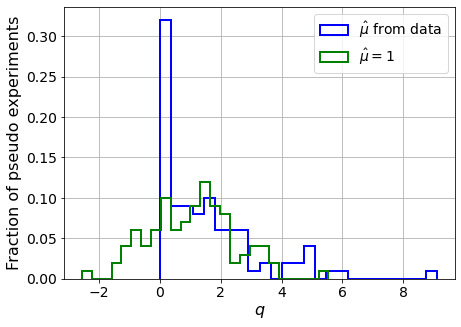

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  7547.19744118  7350.60994076
  7097.75140619  6790.18612514  6396.28076461  5912.25087966
  5312.3195311   4577.5199797   3695.94636253  2634.43970879
  1386.02933832   -76.31690224 -1704.81520944 -3832.74551661]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
IOStream.flush timed out
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  9642.1595434   9545

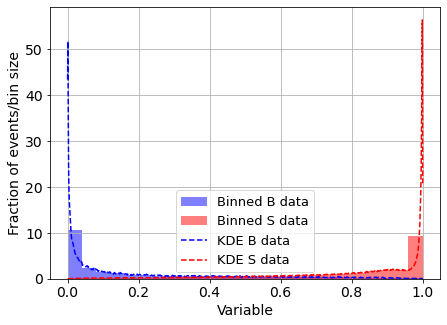

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


  0%|                                                                           | 0/2000 [00:00<?, ?it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21600987659933635
<p_{s}(Sdata)> = 8.941207417907462
<p_{b}(Bdata)> = 10.340444851717688
<p_{s}(Bdata)> = 0.29105623412674225


  0%|▎                                                                  | 8/2000 [00:02<08:57,  3.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23261872248431723
<p_{s}(Sdata)> = 10.50423244049398
<p_{b}(Bdata)> = 10.26708702914251
<p_{s}(Bdata)> = 0.2767182898696882


  1%|▌                                                                 | 17/2000 [00:04<08:35,  3.85it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20225065948909682
<p_{s}(Sdata)> = 8.730739927511436
<p_{b}(Bdata)> = 10.338495349739478
<p_{s}(Bdata)> = 0.29188600111627666


  1%|▋                                                                 | 20/2000 [00:05<07:40,  4.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2076778684909384
<p_{s}(Sdata)> = 9.997501690436648
<p_{b}(Bdata)> = 10.302683787587883
<p_{s}(Bdata)> = 0.27781301275689596


  1%|▊                                                                 | 25/2000 [00:06<05:22,  6.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23469665474721682
<p_{s}(Sdata)> = 7.14925911195742
<p_{b}(Bdata)> = 10.263284846345195
<p_{s}(Bdata)> = 0.2771083540567727
muhat = -0.1
<p_{b}(Sdata)> = 0.3082971282492559
<p_{s}(Sdata)> = 6.898793909714699
<p_{b}(Bdata)> = 10.277559320516893
<p_{s}(Bdata)> = 0.27537629531357966


  1%|▉                                                                 | 28/2000 [00:06<06:01,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.306091375627645
<p_{s}(Sdata)> = 3.0013502079605785
<p_{b}(Bdata)> = 10.212596031654888
<p_{s}(Bdata)> = 0.28492662183958767


  2%|█                                                                 | 31/2000 [00:07<07:09,  4.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4604509123349424
<p_{s}(Sdata)> = 8.941107357141133
<p_{b}(Bdata)> = 10.26249503498163
<p_{s}(Bdata)> = 0.28060864203828206


  2%|█▍                                                                | 43/2000 [00:10<08:44,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24841066721755384
<p_{s}(Sdata)> = 6.34090039133966
<p_{b}(Bdata)> = 10.224093469130583
<p_{s}(Bdata)> = 0.28086485393219224


  3%|█▋                                                                | 52/2000 [00:12<05:59,  5.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3815500004465517
<p_{s}(Sdata)> = 2.3305704402369605
<p_{b}(Bdata)> = 10.310404061807787
<p_{s}(Bdata)> = 0.270352544807321


  3%|█▊                                                                | 56/2000 [00:13<06:50,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4549469357047743
<p_{s}(Sdata)> = 5.314815235102051
<p_{b}(Bdata)> = 10.30685452423498
<p_{s}(Bdata)> = 0.2808519877125951


  3%|█▉                                                                | 58/2000 [00:13<06:35,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33628742982310755
<p_{s}(Sdata)> = 8.279079961511973
<p_{b}(Bdata)> = 10.249665187825753
<p_{s}(Bdata)> = 0.27595223118028217


  4%|██▍                                                               | 75/2000 [00:17<05:12,  6.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28508847932562115
<p_{s}(Sdata)> = 4.663877052025479
<p_{b}(Bdata)> = 10.232117682208122
<p_{s}(Bdata)> = 0.2762948928461432
muhat = -0.1
<p_{b}(Sdata)> = 0.2666426075646426
<p_{s}(Sdata)> = 3.5974892403997285
<p_{b}(Bdata)> = 10.407763522948825
<p_{s}(Bdata)> = 0.2823102331162303


  4%|██▌                                                               | 78/2000 [00:18<06:41,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20683330620843512
<p_{s}(Sdata)> = 6.836066768406041
<p_{b}(Bdata)> = 10.217321318694257
<p_{s}(Bdata)> = 0.275292629392689


  4%|██▉                                                               | 89/2000 [00:21<09:11,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2245422328281625
<p_{s}(Sdata)> = 6.84819524881739
<p_{b}(Bdata)> = 10.19656043415811
<p_{s}(Bdata)> = 0.27398599169563814


  5%|███                                                               | 93/2000 [00:22<08:39,  3.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.38327362564267775
<p_{s}(Sdata)> = 24.58542877653819
<p_{b}(Bdata)> = 10.324988891036817
<p_{s}(Bdata)> = 0.2882516518740603


  5%|███▎                                                             | 100/2000 [00:24<07:43,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21474322646935617
<p_{s}(Sdata)> = 8.049177785581772
<p_{b}(Bdata)> = 10.252751072314092
<p_{s}(Bdata)> = 0.2748819064046264


  5%|███▎                                                             | 103/2000 [00:25<07:50,  4.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20008532707813748
<p_{s}(Sdata)> = 7.1776070942961026
<p_{b}(Bdata)> = 10.113168387685642
<p_{s}(Bdata)> = 0.28071050964567346


  6%|███▋                                                             | 114/2000 [00:27<05:28,  5.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33525641321302785
<p_{s}(Sdata)> = 4.107999483409126
<p_{b}(Bdata)> = 10.437934590442827
<p_{s}(Bdata)> = 0.2795507332272256
muhat = -0.1
<p_{b}(Sdata)> = 0.3278734093533748
<p_{s}(Sdata)> = 8.044556031916528
<p_{b}(Bdata)> = 10.30588002483791
<p_{s}(Bdata)> = 0.27645897368504757


  6%|████▏                                                            | 130/2000 [00:32<10:44,  2.90it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20731368304246267
<p_{s}(Sdata)> = 14.835434722261754
<p_{b}(Bdata)> = 10.082709395267875
<p_{s}(Bdata)> = 0.2865701794070689


  7%|████▌                                                            | 141/2000 [00:35<07:32,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5371052100444325
<p_{s}(Sdata)> = 5.570633673312015
<p_{b}(Bdata)> = 10.123233148929838
<p_{s}(Bdata)> = 0.28646487419978506


  9%|██████                                                           | 187/2000 [00:48<07:40,  3.94it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23658366300247238
<p_{s}(Sdata)> = 12.860919772068188
<p_{b}(Bdata)> = 10.375573466717475
<p_{s}(Bdata)> = 0.292205630821055


 11%|███████                                                          | 218/2000 [00:55<05:26,  5.46it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2269478971341973
<p_{s}(Sdata)> = 11.915266826438595
<p_{b}(Bdata)> = 10.271785787458667
<p_{s}(Bdata)> = 0.29086568294449167
muhat = -0.1
<p_{b}(Sdata)> = 0.23542983483690272
<p_{s}(Sdata)> = 10.794112035020095
<p_{b}(Bdata)> = 10.41086689288656
<p_{s}(Bdata)> = 0.27614162121204683
muhat = -0.1
<p_{b}(Sdata)> = 0.5228384850925651
<p_{s}(Sdata)> = 7.12075313323199
<p_{b}(Bdata)> = 10.393098024541896
<p_{s}(Bdata)> = 0.27571829669892817


 11%|███████▏                                                         | 223/2000 [00:56<04:32,  6.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38500916819470127
<p_{s}(Sdata)> = 8.438176722800753
<p_{b}(Bdata)> = 10.178494021293815
<p_{s}(Bdata)> = 0.2794411353681402
muhat = -0.1
<p_{b}(Sdata)> = 0.4009625056932604
<p_{s}(Sdata)> = 10.529411201367978
<p_{b}(Bdata)> = 10.237008014393172
<p_{s}(Bdata)> = 0.2767681971577354


 11%|███████▎                                                         | 224/2000 [00:56<04:50,  6.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.285778810777345
<p_{s}(Sdata)> = 6.761488286074386
<p_{b}(Bdata)> = 10.249966045547554
<p_{s}(Bdata)> = 0.27084132597781574


 11%|███████▍                                                         | 228/2000 [00:57<07:34,  3.90it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18204617306636744
<p_{s}(Sdata)> = 13.707865587241182
<p_{b}(Bdata)> = 10.204190840968662
<p_{s}(Bdata)> = 0.29678752879064924


 12%|███████▉                                                         | 246/2000 [01:02<07:14,  4.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2187319229704494
<p_{s}(Sdata)> = 16.716004913417247
<p_{b}(Bdata)> = 10.09987390974724
<p_{s}(Bdata)> = 0.28861624194995217


 13%|████████▋                                                        | 267/2000 [01:07<06:11,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40145513571768926
<p_{s}(Sdata)> = 4.057794748319903
<p_{b}(Bdata)> = 10.253848123728423
<p_{s}(Bdata)> = 0.27087273551661295


 14%|████████▊                                                        | 270/2000 [01:08<08:35,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20919099859041165
<p_{s}(Sdata)> = 6.287505204282327
<p_{b}(Bdata)> = 10.26738620136744
<p_{s}(Bdata)> = 0.2789538323596131


 14%|████████▉                                                        | 274/2000 [01:09<04:44,  6.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3003210540159267
<p_{s}(Sdata)> = 4.452848537726497
<p_{b}(Bdata)> = 10.294198582941549
<p_{s}(Bdata)> = 0.28290603705974965
muhat = -0.1
<p_{b}(Sdata)> = 0.27978217749964823
<p_{s}(Sdata)> = 7.49594469012435
<p_{b}(Bdata)> = 10.293739508594335
<p_{s}(Bdata)> = 0.28714691531219155


 15%|█████████▍                                                       | 292/2000 [01:13<05:51,  4.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19093773994037694
<p_{s}(Sdata)> = 17.286938453237926
<p_{b}(Bdata)> = 10.190701447962823
<p_{s}(Bdata)> = 0.2880265418081765


 15%|█████████▊                                                       | 300/2000 [01:15<04:52,  5.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2580034653664172
<p_{s}(Sdata)> = 4.643079354263624
<p_{b}(Bdata)> = 10.340700588542152
<p_{s}(Bdata)> = 0.28176072921169626
muhat = -0.1
<p_{b}(Sdata)> = 0.5945343871399079
<p_{s}(Sdata)> = 4.011281397578463
<p_{b}(Bdata)> = 10.322404366823072
<p_{s}(Bdata)> = 0.2776879801956201


 15%|█████████▉                                                       | 307/2000 [01:16<05:30,  5.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26614814462050707
<p_{s}(Sdata)> = 8.845959782524913
<p_{b}(Bdata)> = 10.062637173286673
<p_{s}(Bdata)> = 0.28225180292815893


 16%|██████████                                                       | 310/2000 [01:17<05:04,  5.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17542918641624242
<p_{s}(Sdata)> = 4.989136070232222
<p_{b}(Bdata)> = 10.193119771611963
<p_{s}(Bdata)> = 0.2703148759334546
muhat = -0.1
<p_{b}(Sdata)> = 0.49671883839950254
<p_{s}(Sdata)> = 7.310142333782425
<p_{b}(Bdata)> = 10.445777240217351
<p_{s}(Bdata)> = 0.27997374687321136
muhat = -0.1
<p_{b}(Sdata)> = 0.22050881996913416
<p_{s}(Sdata)> = 5.426430716999314
<p_{b}(Bdata)> = 10.389704526572471
<p_{s}(Bdata)> = 0.2852152421362616


 16%|██████████▌                                                      | 324/2000 [01:21<09:05,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.439830871807994
<p_{s}(Sdata)> = 8.691327525580288
<p_{b}(Bdata)> = 10.356930950165372
<p_{s}(Bdata)> = 0.27482741551390666


 16%|██████████▋                                                      | 328/2000 [01:22<08:57,  3.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2607257628289694
<p_{s}(Sdata)> = 12.501322235912339
<p_{b}(Bdata)> = 10.394653206544854
<p_{s}(Bdata)> = 0.2732574255419156


 16%|██████████▋                                                      | 330/2000 [01:23<06:58,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20836690555146534
<p_{s}(Sdata)> = 13.16211847759642
<p_{b}(Bdata)> = 10.378254136730241
<p_{s}(Bdata)> = 0.27852478732734787


 17%|██████████▉                                                      | 337/2000 [01:24<05:49,  4.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30430129166223957
<p_{s}(Sdata)> = 8.014219558266682
<p_{b}(Bdata)> = 10.23220742287958
<p_{s}(Bdata)> = 0.273062777861913


 17%|███████████▏                                                     | 343/2000 [01:25<04:24,  6.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2966069965001345
<p_{s}(Sdata)> = 7.447652986953817
<p_{b}(Bdata)> = 10.264433116255784
<p_{s}(Bdata)> = 0.27790828925024347
muhat = 2.1
<p_{b}(Sdata)> = 0.21421270255884778
<p_{s}(Sdata)> = 14.937241654435825
<p_{b}(Bdata)> = 10.231304851145378
<p_{s}(Bdata)> = 0.2959096265740193


 17%|███████████▏                                                     | 346/2000 [01:26<06:00,  4.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3322477524832532
<p_{s}(Sdata)> = 7.607224211540161
<p_{b}(Bdata)> = 10.187410571106138
<p_{s}(Bdata)> = 0.28120099108476093


 18%|███████████▍                                                     | 350/2000 [01:26<04:23,  6.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30857764258149056
<p_{s}(Sdata)> = 4.183941712701418
<p_{b}(Bdata)> = 10.173536627299262
<p_{s}(Bdata)> = 0.2824272103341063
muhat = 2.1
<p_{b}(Sdata)> = 0.15215914206767023
<p_{s}(Sdata)> = 21.142865644513257
<p_{b}(Bdata)> = 10.297616783928282
<p_{s}(Bdata)> = 0.2976186625877588


 18%|███████████▍                                                     | 352/2000 [01:27<05:21,  5.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3356011192294844
<p_{s}(Sdata)> = 4.2049017209595565
<p_{b}(Bdata)> = 10.269545473527675
<p_{s}(Bdata)> = 0.27353216853166945


 18%|███████████▋                                                     | 359/2000 [01:29<08:22,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24005913015428354
<p_{s}(Sdata)> = 5.830625094308943
<p_{b}(Bdata)> = 10.347398158777548
<p_{s}(Bdata)> = 0.27891635296116546


 18%|███████████▊                                                     | 365/2000 [01:31<07:40,  3.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23745010423225987
<p_{s}(Sdata)> = 6.172450519994691
<p_{b}(Bdata)> = 10.244176843067722
<p_{s}(Bdata)> = 0.2780814876354005


 18%|███████████▉                                                     | 368/2000 [01:31<05:49,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24940560643084703
<p_{s}(Sdata)> = 2.514436763003111
<p_{b}(Bdata)> = 10.35222062647179
<p_{s}(Bdata)> = 0.2790145106830124


 19%|████████████                                                     | 372/2000 [01:32<05:27,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41196637242626327
<p_{s}(Sdata)> = 2.344239090642488
<p_{b}(Bdata)> = 10.33663280788695
<p_{s}(Bdata)> = 0.2764075778273887


 19%|████████████▏                                                    | 374/2000 [01:32<05:39,  4.80it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3174497105605801
<p_{s}(Sdata)> = 16.798422139189448
<p_{b}(Bdata)> = 10.450213238923721
<p_{s}(Bdata)> = 0.28703553990804465


 19%|████████████▎                                                    | 377/2000 [01:33<05:36,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.260708718557094
<p_{s}(Sdata)> = 11.44468747030058
<p_{b}(Bdata)> = 10.077321806684566
<p_{s}(Bdata)> = 0.27329223875346825


 19%|████████████▍                                                    | 383/2000 [01:34<05:35,  4.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24306755373662792
<p_{s}(Sdata)> = 12.791789499770765
<p_{b}(Bdata)> = 10.462986273764042
<p_{s}(Bdata)> = 0.27190819586136783


 19%|████████████▌                                                    | 386/2000 [01:35<05:28,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27001776866672794
<p_{s}(Sdata)> = 6.453968017382561
<p_{b}(Bdata)> = 10.355329390809107
<p_{s}(Bdata)> = 0.27451207124550553


 20%|████████████▉                                                    | 399/2000 [01:38<06:40,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43592721619085745
<p_{s}(Sdata)> = 5.671486630605572
<p_{b}(Bdata)> = 10.277214357625695
<p_{s}(Bdata)> = 0.28564924981044854


 21%|█████████████▉                                                   | 427/2000 [01:46<04:52,  5.38it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22622472523121387
<p_{s}(Sdata)> = 16.502832908597608
<p_{b}(Bdata)> = 10.26217906302661
<p_{s}(Bdata)> = 0.2869632153273114


 22%|██████████████▎                                                  | 439/2000 [01:49<05:56,  4.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21872651077356792
<p_{s}(Sdata)> = 9.42783635951061
<p_{b}(Bdata)> = 10.204837612540416
<p_{s}(Bdata)> = 0.2759583128941333


 22%|██████████████▎                                                  | 441/2000 [01:50<04:32,  5.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13170781488521363
<p_{s}(Sdata)> = 16.459062994152326
<p_{b}(Bdata)> = 10.28880457655479
<p_{s}(Bdata)> = 0.28272986812581663
muhat = 2.1
<p_{b}(Sdata)> = 0.1870034871176936
<p_{s}(Sdata)> = 15.410543517135022
<p_{b}(Bdata)> = 10.272977131527611
<p_{s}(Bdata)> = 0.2884027136866677


 22%|██████████████▌                                                  | 448/2000 [01:51<04:30,  5.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32846067847540494
<p_{s}(Sdata)> = 3.3803703069717184
<p_{b}(Bdata)> = 10.329894925420314
<p_{s}(Bdata)> = 0.28062247673628515
muhat = 2.1
<p_{b}(Sdata)> = 0.26985168286165506
<p_{s}(Sdata)> = 18.74482227297292
<p_{b}(Bdata)> = 10.08282015516921
<p_{s}(Bdata)> = 0.2871005840619379


 22%|██████████████▌                                                  | 449/2000 [01:51<05:55,  4.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28798400400796753
<p_{s}(Sdata)> = 2.660416096733708
<p_{b}(Bdata)> = 10.327189379593774
<p_{s}(Bdata)> = 0.28232809094860506


 23%|██████████████▉                                                  | 459/2000 [01:53<04:01,  6.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19942963922166518
<p_{s}(Sdata)> = 19.297638436640895
<p_{b}(Bdata)> = 10.12349203524658
<p_{s}(Bdata)> = 0.2857535503824724
muhat = -0.1
<p_{b}(Sdata)> = 0.2725178061803442
<p_{s}(Sdata)> = 7.254684874181819
<p_{b}(Bdata)> = 10.187173364057067
<p_{s}(Bdata)> = 0.27668189815336575
muhat = -0.1
<p_{b}(Sdata)> = 0.2584456494096085
<p_{s}(Sdata)> = 2.1366744888009874
<p_{b}(Bdata)> = 10.036876304163599
<p_{s}(Bdata)> = 0.2871809321589625


 24%|███████████████▋                                                 | 483/2000 [01:59<04:53,  5.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5419569833289108
<p_{s}(Sdata)> = 5.044194726212247
<p_{b}(Bdata)> = 10.157774607832804
<p_{s}(Bdata)> = 0.28789318608844977


 25%|███████████████▉                                                 | 492/2000 [02:01<05:24,  4.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31511415801745335
<p_{s}(Sdata)> = 5.480923153218733
<p_{b}(Bdata)> = 10.328070438706781
<p_{s}(Bdata)> = 0.28028251916815405


 25%|████████████████▏                                                | 498/2000 [02:02<05:02,  4.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26200920238742637
<p_{s}(Sdata)> = 6.0479024857750865
<p_{b}(Bdata)> = 10.216117841034428
<p_{s}(Bdata)> = 0.284273567261554


 26%|████████████████▌                                                | 510/2000 [02:05<04:32,  5.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32252124426106454
<p_{s}(Sdata)> = 10.442214206793969
<p_{b}(Bdata)> = 10.373312268704884
<p_{s}(Bdata)> = 0.27467532286630986
muhat = 2.1
<p_{b}(Sdata)> = 0.18899826347515647
<p_{s}(Sdata)> = 17.20518858528322
<p_{b}(Bdata)> = 10.255783614667836
<p_{s}(Bdata)> = 0.28463583930121206


 26%|████████████████▋                                                | 514/2000 [02:06<05:50,  4.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36393305797312875
<p_{s}(Sdata)> = 9.73561726931691
<p_{b}(Bdata)> = 10.256092601286044
<p_{s}(Bdata)> = 0.27752247035095895


 26%|████████████████▊                                                | 518/2000 [02:07<04:51,  5.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17929314240401212
<p_{s}(Sdata)> = 8.34380226172072
<p_{b}(Bdata)> = 10.300150683915344
<p_{s}(Bdata)> = 0.27352739376352875


 26%|████████████████▉                                                | 523/2000 [02:08<04:59,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46275330814043214
<p_{s}(Sdata)> = 6.719357693445549
<p_{b}(Bdata)> = 10.354375199651201
<p_{s}(Bdata)> = 0.2780189893365486


 26%|█████████████████                                                | 526/2000 [02:08<05:16,  4.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23293154961770576
<p_{s}(Sdata)> = 8.701950217542308
<p_{b}(Bdata)> = 10.100492481363265
<p_{s}(Bdata)> = 0.2801173365949651


 26%|█████████████████▏                                               | 529/2000 [02:09<04:40,  5.25it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2861048188686824
<p_{s}(Sdata)> = 8.534816412364224
<p_{b}(Bdata)> = 10.253133356349046
<p_{s}(Bdata)> = 0.30084466951654265


 28%|█████████████████▉                                               | 552/2000 [02:16<08:02,  3.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3885215446556238
<p_{s}(Sdata)> = 7.804744906088819
<p_{b}(Bdata)> = 10.395671910622092
<p_{s}(Bdata)> = 0.2766299139642722


 28%|██████████████████▍                                              | 566/2000 [02:19<05:16,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3109658732224727
<p_{s}(Sdata)> = 7.972193543896307
<p_{b}(Bdata)> = 10.38519129208523
<p_{s}(Bdata)> = 0.27175288613892407


 29%|██████████████████▊                                              | 579/2000 [02:22<04:06,  5.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35625042714266236
<p_{s}(Sdata)> = 2.146618397941404
<p_{b}(Bdata)> = 10.21276034764602
<p_{s}(Bdata)> = 0.27935975195807267


 29%|██████████████████▊                                              | 580/2000 [02:23<05:57,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32153808012661894
<p_{s}(Sdata)> = 9.160271531784707
<p_{b}(Bdata)> = 10.2055401417809
<p_{s}(Bdata)> = 0.2768102350385526


 30%|███████████████████▏                                             | 590/2000 [02:24<03:29,  6.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3291956921679405
<p_{s}(Sdata)> = 6.16891382705824
<p_{b}(Bdata)> = 10.070269327319135
<p_{s}(Bdata)> = 0.2836882604826666


 30%|███████████████████▎                                             | 596/2000 [02:26<04:13,  5.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3497811583900647
<p_{s}(Sdata)> = 8.83507602743398
<p_{b}(Bdata)> = 10.276551916576176
<p_{s}(Bdata)> = 0.27762460663361466


 30%|███████████████████▌                                             | 600/2000 [02:27<05:27,  4.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25538857491207967
<p_{s}(Sdata)> = 11.876446464046024
<p_{b}(Bdata)> = 10.421948204822188
<p_{s}(Bdata)> = 0.289837464448134


 30%|███████████████████▊                                             | 609/2000 [02:29<04:16,  5.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3390937611376598
<p_{s}(Sdata)> = 5.942985766479213
<p_{b}(Bdata)> = 10.149752292347404
<p_{s}(Bdata)> = 0.2870169461323828


 31%|████████████████████                                             | 616/2000 [02:30<04:48,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21730926348704865
<p_{s}(Sdata)> = 6.581683296100386
<p_{b}(Bdata)> = 10.29484904851158
<p_{s}(Bdata)> = 0.27775579390071503


 31%|████████████████████                                             | 619/2000 [02:31<04:44,  4.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3807075782898063
<p_{s}(Sdata)> = 8.152017475103392
<p_{b}(Bdata)> = 10.604877101977888
<p_{s}(Bdata)> = 0.2736321296386386
muhat = 2.1
<p_{b}(Sdata)> = 0.2819930989632167
<p_{s}(Sdata)> = 15.242181541942795
<p_{b}(Bdata)> = 10.329683867159957
<p_{s}(Bdata)> = 0.2916138886875059


 31%|████████████████████▎                                            | 624/2000 [02:32<05:25,  4.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28495271155823976
<p_{s}(Sdata)> = 7.096670515316653
<p_{b}(Bdata)> = 10.295343652406672
<p_{s}(Bdata)> = 0.278150527440605


 32%|████████████████████▍                                            | 630/2000 [02:34<05:33,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19482682147543084
<p_{s}(Sdata)> = 8.725288016469563
<p_{b}(Bdata)> = 10.33426728324136
<p_{s}(Bdata)> = 0.28167554675439277


 32%|█████████████████████                                            | 649/2000 [02:38<05:51,  3.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24276052094625913
<p_{s}(Sdata)> = 8.432461716332071
<p_{b}(Bdata)> = 10.44697794464174
<p_{s}(Bdata)> = 0.2683778445240734


 33%|█████████████████████▎                                           | 654/2000 [02:39<05:13,  4.30it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1737325857949389
<p_{s}(Sdata)> = 14.78765942387946
<p_{b}(Bdata)> = 10.244377928486141
<p_{s}(Bdata)> = 0.2884421087740576


 33%|█████████████████████▍                                           | 658/2000 [02:40<04:24,  5.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31613786792866305
<p_{s}(Sdata)> = 6.246490374358561
<p_{b}(Bdata)> = 10.33451662635216
<p_{s}(Bdata)> = 0.2782315104290539


 33%|█████████████████████▋                                           | 669/2000 [02:43<03:42,  5.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25070903153549257
<p_{s}(Sdata)> = 7.002065658053363
<p_{b}(Bdata)> = 10.354406039851943
<p_{s}(Bdata)> = 0.2781703141342117
muhat = -0.1
<p_{b}(Sdata)> = 0.2464408148182492
<p_{s}(Sdata)> = 7.1262174254946515
<p_{b}(Bdata)> = 10.24817712403251
<p_{s}(Bdata)> = 0.2746079338724219


 34%|█████████████████████▊                                           | 673/2000 [02:44<05:12,  4.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3963814815657532
<p_{s}(Sdata)> = 5.494961108122837
<p_{b}(Bdata)> = 10.240580320756395
<p_{s}(Bdata)> = 0.2740009602935744


 34%|██████████████████████                                           | 679/2000 [02:45<04:17,  5.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2641958265430667
<p_{s}(Sdata)> = 5.663984268228208
<p_{b}(Bdata)> = 10.105489823540841
<p_{s}(Bdata)> = 0.27219238604294677


 34%|██████████████████████▏                                          | 682/2000 [02:46<03:40,  5.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2287269174075066
<p_{s}(Sdata)> = 5.69964891444886
<p_{b}(Bdata)> = 10.182977487653979
<p_{s}(Bdata)> = 0.2788080364243008


 35%|██████████████████████▉                                          | 707/2000 [02:52<06:16,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35596974180086277
<p_{s}(Sdata)> = 6.600111351046446
<p_{b}(Bdata)> = 10.188138407002768
<p_{s}(Bdata)> = 0.28672490170566445


 36%|███████████████████████▎                                         | 718/2000 [02:54<03:47,  5.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26895104413887017
<p_{s}(Sdata)> = 6.060127586109955
<p_{b}(Bdata)> = 10.267372891804461
<p_{s}(Bdata)> = 0.2802201755130191


 37%|███████████████████████▊                                         | 731/2000 [02:58<06:55,  3.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25700810135718105
<p_{s}(Sdata)> = 9.288026171058402
<p_{b}(Bdata)> = 10.35345143408032
<p_{s}(Bdata)> = 0.27985194734117724


 38%|████████████████████████▋                                        | 759/2000 [03:05<05:04,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4928827333642
<p_{s}(Sdata)> = 4.296934762668841
<p_{b}(Bdata)> = 10.275093625137034
<p_{s}(Bdata)> = 0.2758433101468005


 38%|████████████████████████▊                                        | 762/2000 [03:06<04:37,  4.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14415691470153694
<p_{s}(Sdata)> = 6.540507297598694
<p_{b}(Bdata)> = 10.108819851411596
<p_{s}(Bdata)> = 0.28001401803775805


 38%|████████████████████████▉                                        | 769/2000 [03:07<04:24,  4.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.264689222649131
<p_{s}(Sdata)> = 4.020039973691759
<p_{b}(Bdata)> = 10.396924005336222
<p_{s}(Bdata)> = 0.27981288812033184


 39%|█████████████████████████                                        | 771/2000 [03:08<03:41,  5.54it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17601606113611135
<p_{s}(Sdata)> = 19.588121002420188
<p_{b}(Bdata)> = 10.461845935022406
<p_{s}(Bdata)> = 0.2802088910794821


 40%|██████████████████████████                                       | 800/2000 [03:15<03:28,  5.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1640355848965668
<p_{s}(Sdata)> = 19.826872460792124
<p_{b}(Bdata)> = 10.287724853416742
<p_{s}(Bdata)> = 0.28901972219815325


 42%|███████████████████████████                                      | 833/2000 [03:24<06:20,  3.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26133483427830556
<p_{s}(Sdata)> = 10.950689358985349
<p_{b}(Bdata)> = 10.30587725485923
<p_{s}(Bdata)> = 0.282721140906042


 42%|███████████████████████████▏                                     | 835/2000 [03:24<05:09,  3.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6544349471936305
<p_{s}(Sdata)> = 4.529103458995429
<p_{b}(Bdata)> = 10.293479982300902
<p_{s}(Bdata)> = 0.27989442409975207


 42%|███████████████████████████▎                                     | 840/2000 [03:25<03:51,  5.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29477052808238136
<p_{s}(Sdata)> = 7.0760478544337015
<p_{b}(Bdata)> = 10.205657873817207
<p_{s}(Bdata)> = 0.27652697666850584


 42%|███████████████████████████▍                                     | 846/2000 [03:26<04:06,  4.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.348278265579974
<p_{s}(Sdata)> = 13.56322263514122
<p_{b}(Bdata)> = 10.395874771532162
<p_{s}(Bdata)> = 0.291408895822498


 42%|███████████████████████████▋                                     | 850/2000 [03:27<03:57,  4.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2852147326497871
<p_{s}(Sdata)> = 4.881134658403157
<p_{b}(Bdata)> = 10.416165790826854
<p_{s}(Bdata)> = 0.27832597361609196


 43%|███████████████████████████▊                                     | 855/2000 [03:28<02:49,  6.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.250600426726177
<p_{s}(Sdata)> = 2.6620188080680434
<p_{b}(Bdata)> = 10.342294148428326
<p_{s}(Bdata)> = 0.2807454972136914
muhat = -0.1
<p_{b}(Sdata)> = 0.5474709672759978
<p_{s}(Sdata)> = 8.213889350095897
<p_{b}(Bdata)> = 10.306419265098695
<p_{s}(Bdata)> = 0.2787423737747358


 43%|████████████████████████████▏                                    | 867/2000 [03:31<02:43,  6.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30252554332687864
<p_{s}(Sdata)> = 6.409080104533105
<p_{b}(Bdata)> = 10.208641852363568
<p_{s}(Bdata)> = 0.2783905057990997
muhat = -0.1
<p_{b}(Sdata)> = 0.26287640025920855
<p_{s}(Sdata)> = 5.432998157330526
<p_{b}(Bdata)> = 10.408011514778622
<p_{s}(Bdata)> = 0.27569179919769743


 44%|████████████████████████████▎                                    | 873/2000 [03:32<04:24,  4.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41967749149784406
<p_{s}(Sdata)> = 4.355146312130339
<p_{b}(Bdata)> = 10.577136406041168
<p_{s}(Bdata)> = 0.27749523864247283


 44%|████████████████████████████▋                                    | 881/2000 [03:34<03:25,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2900421081960698
<p_{s}(Sdata)> = 2.011449434451047
<p_{b}(Bdata)> = 10.271161323375807
<p_{s}(Bdata)> = 0.2793266237581105


 44%|████████████████████████████▊                                    | 886/2000 [03:36<05:10,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2813885547996455
<p_{s}(Sdata)> = 3.732212490754747
<p_{b}(Bdata)> = 10.240978015466398
<p_{s}(Bdata)> = 0.2775739051534729


 45%|█████████████████████████████▎                                   | 901/2000 [03:40<06:47,  2.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6679236745980689
<p_{s}(Sdata)> = 7.879734991045718
<p_{b}(Bdata)> = 10.322954566980638
<p_{s}(Bdata)> = 0.2800480709913484


 46%|█████████████████████████████▋                                   | 915/2000 [03:43<03:54,  4.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25646651331047804
<p_{s}(Sdata)> = 11.5774952100283
<p_{b}(Bdata)> = 10.464489544212347
<p_{s}(Bdata)> = 0.2741022077995294


 46%|█████████████████████████████▊                                   | 917/2000 [03:44<03:59,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5405504591042474
<p_{s}(Sdata)> = 2.754816965333592
<p_{b}(Bdata)> = 10.253891550838835
<p_{s}(Bdata)> = 0.2802769035903655


 46%|██████████████████████████████                                   | 925/2000 [03:46<04:33,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21348631596251333
<p_{s}(Sdata)> = 7.3770426705059515
<p_{b}(Bdata)> = 10.334992566699139
<p_{s}(Bdata)> = 0.28162105647227614


 47%|██████████████████████████████▎                                  | 932/2000 [03:47<03:31,  5.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1322520358573532
<p_{s}(Sdata)> = 16.102858255635212
<p_{b}(Bdata)> = 10.086301424774925
<p_{s}(Bdata)> = 0.2868094277858854
muhat = 2.1
<p_{b}(Sdata)> = 0.32965038070633984
<p_{s}(Sdata)> = 12.17852269816066
<p_{b}(Bdata)> = 10.269751406817324
<p_{s}(Bdata)> = 0.28889221542966165


 47%|██████████████████████████████▍                                  | 936/2000 [03:48<03:40,  4.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22047089542151432
<p_{s}(Sdata)> = 9.3206047861548
<p_{b}(Bdata)> = 10.39216508102033
<p_{s}(Bdata)> = 0.269896967934575


 47%|██████████████████████████████▌                                  | 940/2000 [03:49<03:39,  4.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34564407222784016
<p_{s}(Sdata)> = 8.937507207216397
<p_{b}(Bdata)> = 10.072265377321573
<p_{s}(Bdata)> = 0.27598909213900324


 47%|██████████████████████████████▌                                  | 942/2000 [03:49<04:06,  4.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4550850154197399
<p_{s}(Sdata)> = 7.084905928365074
<p_{b}(Bdata)> = 10.367975653766168
<p_{s}(Bdata)> = 0.27417735864337195


 48%|███████████████████████████████▎                                 | 964/2000 [03:55<05:04,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49659412088097477
<p_{s}(Sdata)> = 4.390090397433243
<p_{b}(Bdata)> = 10.270890205431094
<p_{s}(Bdata)> = 0.2803971571208812


 49%|████████████████████████████████▏                                | 989/2000 [04:02<04:34,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21296993524387917
<p_{s}(Sdata)> = 11.572053390293966
<p_{b}(Bdata)> = 10.345106849140803
<p_{s}(Bdata)> = 0.2778583326411775


 50%|████████████████████████████████▎                                | 994/2000 [04:03<02:54,  5.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16726144065611492
<p_{s}(Sdata)> = 9.363645818275852
<p_{b}(Bdata)> = 10.42661145219415
<p_{s}(Bdata)> = 0.28195294674920723
muhat = -0.1
<p_{b}(Sdata)> = 0.23555705426353282
<p_{s}(Sdata)> = 7.774512568084653
<p_{b}(Bdata)> = 10.392880052697617
<p_{s}(Bdata)> = 0.27925680190145685


 50%|████████████████████████████████▏                               | 1006/2000 [04:06<03:29,  4.74it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22485797439434616
<p_{s}(Sdata)> = 23.38710185008243
<p_{b}(Bdata)> = 10.295245849174037
<p_{s}(Bdata)> = 0.2827942003316544
muhat = 2.1
<p_{b}(Sdata)> = 0.4244371299478308
<p_{s}(Sdata)> = 12.267983305587666
<p_{b}(Bdata)> = 10.281212286208767
<p_{s}(Bdata)> = 0.3004273906645606


 51%|████████████████████████████████▊                               | 1026/2000 [04:11<03:17,  4.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2852291856568668
<p_{s}(Sdata)> = 6.1284631684648385
<p_{b}(Bdata)> = 10.41018654752079
<p_{s}(Bdata)> = 0.27317122637907865
muhat = -0.1
<p_{b}(Sdata)> = 0.3235662956821792
<p_{s}(Sdata)> = 7.238286555323679
<p_{b}(Bdata)> = 10.189510689892309
<p_{s}(Bdata)> = 0.2761165755195532


 52%|█████████████████████████████████                               | 1033/2000 [04:13<03:57,  4.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2521837086244783
<p_{s}(Sdata)> = 14.973055057687054
<p_{b}(Bdata)> = 10.14023856348694
<p_{s}(Bdata)> = 0.2873694014102232


 52%|█████████████████████████████████▍                              | 1045/2000 [04:16<04:59,  3.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3135210806873492
<p_{s}(Sdata)> = 1.32372698493207
<p_{b}(Bdata)> = 10.361997876830895
<p_{s}(Bdata)> = 0.27914682283762615


 53%|█████████████████████████████████▊                              | 1056/2000 [04:19<04:19,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4297803403764836
<p_{s}(Sdata)> = 6.163534753888994
<p_{b}(Bdata)> = 10.367656464322065
<p_{s}(Bdata)> = 0.27109637910178586


 53%|█████████████████████████████████▊                              | 1058/2000 [04:19<03:26,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23311883157498983
<p_{s}(Sdata)> = 5.905757842529471
<p_{b}(Bdata)> = 10.349793512973148
<p_{s}(Bdata)> = 0.2830671459928158


 53%|██████████████████████████████████▏                             | 1067/2000 [04:22<04:04,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44450293859156215
<p_{s}(Sdata)> = 9.11307786578871
<p_{b}(Bdata)> = 10.322153934804565
<p_{s}(Bdata)> = 0.27673271388009435


 54%|██████████████████████████████████▏                             | 1070/2000 [04:22<03:25,  4.52it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2400247462913378
<p_{s}(Sdata)> = 10.508969414923058
<p_{b}(Bdata)> = 10.365325963663953
<p_{s}(Bdata)> = 0.2968715331688331


 54%|██████████████████████████████████▎                             | 1074/2000 [04:23<02:46,  5.57it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20428476206327634
<p_{s}(Sdata)> = 13.636292464839025
<p_{b}(Bdata)> = 10.1842120033634
<p_{s}(Bdata)> = 0.2896247094496729
muhat = 2.1
<p_{b}(Sdata)> = 0.17860648015240893
<p_{s}(Sdata)> = 17.775769797394556
<p_{b}(Bdata)> = 10.223441276582834
<p_{s}(Bdata)> = 0.2941570022443158


 54%|██████████████████████████████████▍                             | 1075/2000 [04:23<02:55,  5.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2798967050334039
<p_{s}(Sdata)> = 6.560246711042236
<p_{b}(Bdata)> = 10.403383062330207
<p_{s}(Bdata)> = 0.27462997864366656


 54%|██████████████████████████████████▊                             | 1087/2000 [04:26<04:10,  3.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31275301604485345
<p_{s}(Sdata)> = 5.202639148144056
<p_{b}(Bdata)> = 10.218110958878313
<p_{s}(Bdata)> = 0.285190842780716


 55%|███████████████████████████████████▏                            | 1101/2000 [04:30<03:03,  4.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27416538517540756
<p_{s}(Sdata)> = 20.945564784733673
<p_{b}(Bdata)> = 10.322971814475396
<p_{s}(Bdata)> = 0.281777281482415
muhat = -0.1
<p_{b}(Sdata)> = 0.20648445665010534
<p_{s}(Sdata)> = 5.517949817623937
<p_{b}(Bdata)> = 10.261477472216773
<p_{s}(Bdata)> = 0.2763086892626581


 56%|███████████████████████████████████▌                            | 1110/2000 [04:33<04:37,  3.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2872158571027737
<p_{s}(Sdata)> = 4.519495916830528
<p_{b}(Bdata)> = 10.279019882477376
<p_{s}(Bdata)> = 0.2842289869702483


 57%|████████████████████████████████████▎                           | 1135/2000 [04:39<02:34,  5.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23421252533413753
<p_{s}(Sdata)> = 6.293321533636634
<p_{b}(Bdata)> = 10.418175601613036
<p_{s}(Bdata)> = 0.2779787484276739


 57%|████████████████████████████████████▌                           | 1141/2000 [04:41<03:25,  4.19it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20072074476584006
<p_{s}(Sdata)> = 19.13258667522703
<p_{b}(Bdata)> = 10.208328238886208
<p_{s}(Bdata)> = 0.2947922137678172


 58%|█████████████████████████████████████                           | 1157/2000 [04:45<03:48,  3.69it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4332824002994532
<p_{s}(Sdata)> = 9.63827362286756
<p_{b}(Bdata)> = 10.307143133449685
<p_{s}(Bdata)> = 0.30144148760137335


 59%|█████████████████████████████████████▋                          | 1179/2000 [04:51<02:45,  4.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23346259853985732
<p_{s}(Sdata)> = 6.736273314013909
<p_{b}(Bdata)> = 10.44816133019995
<p_{s}(Bdata)> = 0.27819847419696464
muhat = -0.1
<p_{b}(Sdata)> = 0.2826444633833171
<p_{s}(Sdata)> = 3.227498841488771
<p_{b}(Bdata)> = 10.354687082189697
<p_{s}(Bdata)> = 0.2777807758771011


 59%|█████████████████████████████████████▉                          | 1187/2000 [04:53<03:47,  3.58it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.33035126174224666
<p_{s}(Sdata)> = 8.610161901385293
<p_{b}(Bdata)> = 10.081601228857167
<p_{s}(Bdata)> = 0.29786737272491703


 60%|██████████████████████████████████████                          | 1190/2000 [04:54<03:20,  4.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3996758886924163
<p_{s}(Sdata)> = 3.0756435671301596
<p_{b}(Bdata)> = 10.216413836212402
<p_{s}(Bdata)> = 0.2784651917150819


 60%|██████████████████████████████████████▍                         | 1201/2000 [04:56<02:08,  6.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.291537248882698
<p_{s}(Sdata)> = 5.628358100441186
<p_{b}(Bdata)> = 10.328082364721082
<p_{s}(Bdata)> = 0.27465664660901723
muhat = -0.1
<p_{b}(Sdata)> = 0.2130150208999954
<p_{s}(Sdata)> = 11.111497723090647
<p_{b}(Bdata)> = 10.324951565575235
<p_{s}(Bdata)> = 0.27834551600943475


 60%|██████████████████████████████████████▍                         | 1202/2000 [04:57<02:16,  5.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27181238693725546
<p_{s}(Sdata)> = 6.34878111788922
<p_{b}(Bdata)> = 10.365731070106563
<p_{s}(Bdata)> = 0.28058309307884305


 61%|███████████████████████████████████████                         | 1219/2000 [05:01<03:30,  3.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3058952885571599
<p_{s}(Sdata)> = 16.348236275645075
<p_{b}(Bdata)> = 10.362502177124536
<p_{s}(Bdata)> = 0.2826444718162752


 61%|███████████████████████████████████████                         | 1221/2000 [05:01<02:42,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23740847834404347
<p_{s}(Sdata)> = 5.824942434472574
<p_{b}(Bdata)> = 10.364339960245907
<p_{s}(Bdata)> = 0.28028452046003377


 61%|███████████████████████████████████████▏                        | 1225/2000 [05:02<03:07,  4.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46115255855490556
<p_{s}(Sdata)> = 1.6304927712252404
<p_{b}(Bdata)> = 10.190309883278317
<p_{s}(Bdata)> = 0.2866498833892521


 62%|███████████████████████████████████████▌                        | 1237/2000 [05:05<03:37,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22589126271485196
<p_{s}(Sdata)> = 5.008011690663185
<p_{b}(Bdata)> = 10.19618223770713
<p_{s}(Bdata)> = 0.27758795085972215


 63%|████████████████████████████████████████▏                       | 1256/2000 [05:10<02:45,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28245256228117266
<p_{s}(Sdata)> = 4.113710626842646
<p_{b}(Bdata)> = 10.436563404359614
<p_{s}(Bdata)> = 0.2856930655302649


 63%|████████████████████████████████████████▎                       | 1260/2000 [05:10<01:56,  6.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3843213160564132
<p_{s}(Sdata)> = 4.745008213419499
<p_{b}(Bdata)> = 10.407021348579025
<p_{s}(Bdata)> = 0.2743087744171595
muhat = -0.1
<p_{b}(Sdata)> = 0.23672155953456195
<p_{s}(Sdata)> = 10.689692514021878
<p_{b}(Bdata)> = 10.176954244629353
<p_{s}(Bdata)> = 0.275248807233759


 64%|████████████████████████████████████████▉                       | 1279/2000 [05:15<02:55,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36887833109684465
<p_{s}(Sdata)> = 4.4280716217789635
<p_{b}(Bdata)> = 10.089052910478413
<p_{s}(Bdata)> = 0.27857745793673716


 65%|█████████████████████████████████████████▍                      | 1294/2000 [05:19<02:48,  4.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.309916913404754
<p_{s}(Sdata)> = 15.686499821669825
<p_{b}(Bdata)> = 10.247431444501991
<p_{s}(Bdata)> = 0.2949834630410537


 65%|█████████████████████████████████████████▍                      | 1296/2000 [05:20<03:04,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18289199006214155
<p_{s}(Sdata)> = 14.257553842030491
<p_{b}(Bdata)> = 10.287056634409169
<p_{s}(Bdata)> = 0.27791810923992366


 65%|█████████████████████████████████████████▊                      | 1305/2000 [05:22<02:29,  4.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23418791630676858
<p_{s}(Sdata)> = 6.510850936058877
<p_{b}(Bdata)> = 10.136054551352219
<p_{s}(Bdata)> = 0.281022847559304


 66%|██████████████████████████████████████████                      | 1315/2000 [05:24<02:00,  5.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3532099980992581
<p_{s}(Sdata)> = 7.481445657041798
<p_{b}(Bdata)> = 10.190772927684357
<p_{s}(Bdata)> = 0.28024469096566235
muhat = -0.1
<p_{b}(Sdata)> = 0.34671323318665437
<p_{s}(Sdata)> = 11.500426420945777
<p_{b}(Bdata)> = 10.265643367199951
<p_{s}(Bdata)> = 0.27682880567316487


 66%|██████████████████████████████████████████▎                     | 1321/2000 [05:26<03:13,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4073573738541318
<p_{s}(Sdata)> = 7.155152310664379
<p_{b}(Bdata)> = 10.34267878427589
<p_{s}(Bdata)> = 0.27529891147786417


 67%|██████████████████████████████████████████▊                     | 1338/2000 [05:30<02:06,  5.22it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19041668450561142
<p_{s}(Sdata)> = 14.618941873582166
<p_{b}(Bdata)> = 10.370001383798343
<p_{s}(Bdata)> = 0.2804744965774644
muhat = -0.1
<p_{b}(Sdata)> = 0.24845106272161982
<p_{s}(Sdata)> = 6.616809059742184
<p_{b}(Bdata)> = 10.462236781237069
<p_{s}(Bdata)> = 0.27880342393526825


 67%|███████████████████████████████████████████                     | 1347/2000 [05:32<01:43,  6.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34100308657467987
<p_{s}(Sdata)> = 2.5379275309797626
<p_{b}(Bdata)> = 10.42646576867065
<p_{s}(Bdata)> = 0.27548396690894994


 68%|███████████████████████████████████████████▊                    | 1370/2000 [05:38<03:07,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2836276469886023
<p_{s}(Sdata)> = 6.975665794306694
<p_{b}(Bdata)> = 10.225322123197508
<p_{s}(Bdata)> = 0.27584228449567194


 69%|████████████████████████████████████████████▏                   | 1382/2000 [05:41<02:58,  3.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28011343150229395
<p_{s}(Sdata)> = 6.851631943996157
<p_{b}(Bdata)> = 10.24444263776425
<p_{s}(Bdata)> = 0.27889447107355414


 69%|████████████████████████████████████████████▎                   | 1386/2000 [05:42<02:50,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2741358605869745
<p_{s}(Sdata)> = 6.872032621120987
<p_{b}(Bdata)> = 10.221570532751759
<p_{s}(Bdata)> = 0.2817960206083969


 70%|████████████████████████████████████████████▌                   | 1391/2000 [05:43<02:59,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21537834319768512
<p_{s}(Sdata)> = 14.099060314852654
<p_{b}(Bdata)> = 10.416923813745385
<p_{s}(Bdata)> = 0.2744962253068306


 70%|████████████████████████████████████████████▊                   | 1399/2000 [05:45<02:27,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24222535167831524
<p_{s}(Sdata)> = 4.1713420681659805
<p_{b}(Bdata)> = 10.273100740531655
<p_{s}(Bdata)> = 0.28233823444190886


 70%|█████████████████████████████████████████████                   | 1408/2000 [05:47<02:33,  3.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31640121227408036
<p_{s}(Sdata)> = 4.154753435729757
<p_{b}(Bdata)> = 10.457513371459571
<p_{s}(Bdata)> = 0.27840385407930834


 71%|█████████████████████████████████████████████▏                  | 1411/2000 [05:48<02:29,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37296400485050424
<p_{s}(Sdata)> = 7.794689270806787
<p_{b}(Bdata)> = 10.172586202941469
<p_{s}(Bdata)> = 0.2824241368040703


 71%|█████████████████████████████████████████████▍                  | 1421/2000 [05:51<02:44,  3.52it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26693689154714423
<p_{s}(Sdata)> = 11.770733766321877
<p_{b}(Bdata)> = 10.198582448239556
<p_{s}(Bdata)> = 0.29019244629938995


 71%|█████████████████████████████████████████████▋                  | 1429/2000 [05:52<01:51,  5.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30306464695938606
<p_{s}(Sdata)> = 5.732363452660275
<p_{b}(Bdata)> = 10.151614576145358
<p_{s}(Bdata)> = 0.28404928301003407


 72%|██████████████████████████████████████████████                  | 1441/2000 [05:55<02:46,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2575703258655955
<p_{s}(Sdata)> = 3.516759065616666
<p_{b}(Bdata)> = 10.465027450144424
<p_{s}(Bdata)> = 0.27428492578780744


 72%|██████████████████████████████████████████████▎                 | 1446/2000 [05:56<01:43,  5.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24470650066204377
<p_{s}(Sdata)> = 6.743553613493027
<p_{b}(Bdata)> = 10.20236688723805
<p_{s}(Bdata)> = 0.2804244691797189
muhat = -0.1
<p_{b}(Sdata)> = 0.25394158577488957
<p_{s}(Sdata)> = 6.2731766528853
<p_{b}(Bdata)> = 10.199428305661481
<p_{s}(Bdata)> = 0.2826954932259718


 73%|██████████████████████████████████████████████▌                 | 1455/2000 [05:58<02:07,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2168480150894921
<p_{s}(Sdata)> = 9.781345236717423
<p_{b}(Bdata)> = 10.250700766533228
<p_{s}(Bdata)> = 0.27282923048497637


 73%|██████████████████████████████████████████████▊                 | 1464/2000 [06:00<01:38,  5.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17679481473196082
<p_{s}(Sdata)> = 11.601408016059164
<p_{b}(Bdata)> = 10.241498102490846
<p_{s}(Bdata)> = 0.28840031283915113


 74%|███████████████████████████████████████████████▏                | 1474/2000 [06:03<01:53,  4.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2675825585196093
<p_{s}(Sdata)> = 15.309625103947631
<p_{b}(Bdata)> = 10.267251991383452
<p_{s}(Bdata)> = 0.29034039221914365


 74%|███████████████████████████████████████████████▍                | 1484/2000 [06:05<01:35,  5.38it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12757674538754069
<p_{s}(Sdata)> = 21.224741125360822
<p_{b}(Bdata)> = 10.288243586113081
<p_{s}(Bdata)> = 0.2933813860112873


 74%|███████████████████████████████████████████████▌                | 1486/2000 [06:05<01:39,  5.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2761585723711475
<p_{s}(Sdata)> = 1.759080612299066
<p_{b}(Bdata)> = 10.118759300835102
<p_{s}(Bdata)> = 0.2820775356296291


 75%|████████████████████████████████████████████████▏               | 1506/2000 [06:10<01:37,  5.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3717897562599816
<p_{s}(Sdata)> = 7.0626616594701375
<p_{b}(Bdata)> = 10.462463083730503
<p_{s}(Bdata)> = 0.2797646949686134
muhat = -0.1
<p_{b}(Sdata)> = 0.27763050862348765
<p_{s}(Sdata)> = 7.832880551686354
<p_{b}(Bdata)> = 10.270806375856237
<p_{s}(Bdata)> = 0.27797753527974384


 76%|████████████████████████████████████████████████▉               | 1529/2000 [06:16<02:13,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24145162064356043
<p_{s}(Sdata)> = 11.954546425317163
<p_{b}(Bdata)> = 10.49506428449314
<p_{s}(Bdata)> = 0.27197736910129683


 77%|█████████████████████████████████████████████████               | 1535/2000 [06:18<02:03,  3.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2642564919233727
<p_{s}(Sdata)> = 6.705492381938604
<p_{b}(Bdata)> = 10.366754368322674
<p_{s}(Bdata)> = 0.2732403257258305


 77%|█████████████████████████████████████████████████▍              | 1544/2000 [06:19<01:32,  4.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22503073637915275
<p_{s}(Sdata)> = 3.8674437216296775
<p_{b}(Bdata)> = 10.35777124227751
<p_{s}(Bdata)> = 0.2782921515825755


 77%|█████████████████████████████████████████████████▌              | 1547/2000 [06:20<01:15,  6.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2885778765439494
<p_{s}(Sdata)> = 6.763048086304631
<p_{b}(Bdata)> = 10.23348328038721
<p_{s}(Bdata)> = 0.27457929013225774
muhat = 2.1
<p_{b}(Sdata)> = 0.20357573694884804
<p_{s}(Sdata)> = 17.69822508931481
<p_{b}(Bdata)> = 10.381678302279722
<p_{s}(Bdata)> = 0.284993066790771


 78%|█████████████████████████████████████████████████▊              | 1555/2000 [06:22<01:44,  4.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13483835720432943
<p_{s}(Sdata)> = 10.523115056372623
<p_{b}(Bdata)> = 10.36960320276195
<p_{s}(Bdata)> = 0.2801699096430409


 78%|█████████████████████████████████████████████████▊              | 1558/2000 [06:23<01:44,  4.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4397201775206208
<p_{s}(Sdata)> = 2.25324686306467
<p_{b}(Bdata)> = 10.314667957499964
<p_{s}(Bdata)> = 0.27813740122263975


 78%|█████████████████████████████████████████████████▉              | 1560/2000 [06:23<01:43,  4.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4547276567329979
<p_{s}(Sdata)> = 4.0864006742040075
<p_{b}(Bdata)> = 10.319127072773384
<p_{s}(Bdata)> = 0.28509866821669144


 78%|██████████████████████████████████████████████████              | 1563/2000 [06:24<01:29,  4.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3465320404798046
<p_{s}(Sdata)> = 5.522253531050065
<p_{b}(Bdata)> = 10.47638449954102
<p_{s}(Bdata)> = 0.2812867662978826


 78%|██████████████████████████████████████████████████▏             | 1569/2000 [06:25<01:11,  6.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33219343145385194
<p_{s}(Sdata)> = 3.6887646172014676
<p_{b}(Bdata)> = 10.43458097010906
<p_{s}(Bdata)> = 0.27313077234877303


 80%|██████████████████████████████████████████████████▉             | 1592/2000 [06:31<01:30,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18668400450478842
<p_{s}(Sdata)> = 6.985661344069492
<p_{b}(Bdata)> = 10.185585423301973
<p_{s}(Bdata)> = 0.2752831706467369


 80%|███████████████████████████████████████████████████▏            | 1599/2000 [06:33<02:07,  3.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23984126174514098
<p_{s}(Sdata)> = 5.876550105480304
<p_{b}(Bdata)> = 10.215197009715897
<p_{s}(Bdata)> = 0.28119790123891186


 81%|███████████████████████████████████████████████████▌            | 1613/2000 [06:36<01:43,  3.75it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2446971798554891
<p_{s}(Sdata)> = 13.355171348682537
<p_{b}(Bdata)> = 10.255414438759109
<p_{s}(Bdata)> = 0.29533106906421536


 81%|███████████████████████████████████████████████████▋            | 1615/2000 [06:37<01:41,  3.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27241405045109235
<p_{s}(Sdata)> = 2.868651628494294
<p_{b}(Bdata)> = 10.458401971728698
<p_{s}(Bdata)> = 0.2733754882228556


 81%|███████████████████████████████████████████████████▉            | 1622/2000 [06:39<01:36,  3.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9591967551891339
<p_{s}(Sdata)> = 10.07214517935405
<p_{b}(Bdata)> = 10.308720062471112
<p_{s}(Bdata)> = 0.2742228240061496


 81%|███████████████████████████████████████████████████▉            | 1624/2000 [06:39<01:18,  4.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2877963271802486
<p_{s}(Sdata)> = 12.488977947009353
<p_{b}(Bdata)> = 10.310118695147745
<p_{s}(Bdata)> = 0.29036899868771576


 82%|████████████████████████████████████████████████████▏           | 1630/2000 [06:40<01:07,  5.52it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2908543355453591
<p_{s}(Sdata)> = 10.788742741868154
<p_{b}(Bdata)> = 10.412225675868454
<p_{s}(Bdata)> = 0.2939340972767615
muhat = -0.1
<p_{b}(Sdata)> = 0.2979435189775907
<p_{s}(Sdata)> = 7.336046664474897
<p_{b}(Bdata)> = 10.144818575675735
<p_{s}(Bdata)> = 0.2769284019763612


 82%|████████████████████████████████████████████████████▊           | 1649/2000 [06:46<01:42,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16857558817932045
<p_{s}(Sdata)> = 10.39266744904231
<p_{b}(Bdata)> = 10.621100605840207
<p_{s}(Bdata)> = 0.27675089090080945


 84%|█████████████████████████████████████████████████████▌          | 1675/2000 [06:52<01:20,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2859775233370124
<p_{s}(Sdata)> = 3.928616921300471
<p_{b}(Bdata)> = 10.326613157216457
<p_{s}(Bdata)> = 0.2800772469284294


 84%|█████████████████████████████████████████████████████▉          | 1686/2000 [06:55<01:15,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20391750287195973
<p_{s}(Sdata)> = 6.64099787530399
<p_{b}(Bdata)> = 10.197261919700361
<p_{s}(Bdata)> = 0.2806193263608354


 85%|██████████████████████████████████████████████████████▏         | 1695/2000 [06:57<00:57,  5.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2637534462963052
<p_{s}(Sdata)> = 6.894847338277576
<p_{b}(Bdata)> = 10.19365132811889
<p_{s}(Bdata)> = 0.2827585784409398
muhat = -0.1
<p_{b}(Sdata)> = 0.37446934927848347
<p_{s}(Sdata)> = 3.772874310937484
<p_{b}(Bdata)> = 10.143861324703119
<p_{s}(Bdata)> = 0.27757447085582837


 85%|██████████████████████████████████████████████████████▎         | 1698/2000 [06:58<01:32,  3.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27491239705672643
<p_{s}(Sdata)> = 5.732867806051344
<p_{b}(Bdata)> = 10.29751041955024
<p_{s}(Bdata)> = 0.28167010685534105


 85%|██████████████████████████████████████████████████████▍         | 1702/2000 [06:59<00:59,  5.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.349584009270584
<p_{s}(Sdata)> = 4.174417593499307
<p_{b}(Bdata)> = 10.213251386556276
<p_{s}(Bdata)> = 0.2833032753109824


 85%|██████████████████████████████████████████████████████▌         | 1705/2000 [06:59<00:40,  7.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25777776088211524
<p_{s}(Sdata)> = 7.842943289545709
<p_{b}(Bdata)> = 10.319717629402032
<p_{s}(Bdata)> = 0.2834472603851668
muhat = -0.1
<p_{b}(Sdata)> = 0.2903982402561404
<p_{s}(Sdata)> = 7.60954836024711
<p_{b}(Bdata)> = 10.304546647292
<p_{s}(Bdata)> = 0.27970205143625626


 86%|██████████████████████████████████████████████████████▊         | 1712/2000 [07:00<00:53,  5.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21522000892006943
<p_{s}(Sdata)> = 6.9862397278896085
<p_{b}(Bdata)> = 10.302874690193573
<p_{s}(Bdata)> = 0.27615084108876464


 87%|███████████████████████████████████████████████████████▋        | 1740/2000 [07:08<00:58,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2565232346808681
<p_{s}(Sdata)> = 6.215213869517282
<p_{b}(Bdata)> = 10.457431650074406
<p_{s}(Bdata)> = 0.27348206165767164


 89%|████████████████████████████████████████████████████████▋       | 1771/2000 [07:16<00:54,  4.22it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17234805782654722
<p_{s}(Sdata)> = 16.307687030895558
<p_{b}(Bdata)> = 10.197614558177808
<p_{s}(Bdata)> = 0.2833684125071106


 89%|█████████████████████████████████████████████████████████       | 1784/2000 [07:18<00:44,  4.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40263401395395737
<p_{s}(Sdata)> = 6.727650261529018
<p_{b}(Bdata)> = 10.37646456162245
<p_{s}(Bdata)> = 0.2772206272570698


 90%|█████████████████████████████████████████████████████████▌      | 1798/2000 [07:22<00:44,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2997039532258806
<p_{s}(Sdata)> = 5.049927214485409
<p_{b}(Bdata)> = 10.145262734163811
<p_{s}(Bdata)> = 0.2786468456220943


 90%|█████████████████████████████████████████████████████████▊      | 1806/2000 [07:24<00:37,  5.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2842538840810876
<p_{s}(Sdata)> = 8.62483860640897
<p_{b}(Bdata)> = 10.364880781970315
<p_{s}(Bdata)> = 0.2809427911245033


 91%|██████████████████████████████████████████████████████████▎     | 1823/2000 [07:28<00:28,  6.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22880114404389792
<p_{s}(Sdata)> = 6.981683684530519
<p_{b}(Bdata)> = 10.34944919321357
<p_{s}(Bdata)> = 0.27621461447335727


 92%|██████████████████████████████████████████████████████████▉     | 1842/2000 [07:33<00:40,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.252088753748187
<p_{s}(Sdata)> = 8.703201767843312
<p_{b}(Bdata)> = 10.321423905872589
<p_{s}(Bdata)> = 0.2748681911943226


 93%|███████████████████████████████████████████████████████████▎    | 1854/2000 [07:36<00:38,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2732105103229228
<p_{s}(Sdata)> = 7.688255641528485
<p_{b}(Bdata)> = 10.28207462793817
<p_{s}(Bdata)> = 0.27590516594388315


 93%|███████████████████████████████████████████████████████████▋    | 1865/2000 [07:39<00:38,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4065204984674331
<p_{s}(Sdata)> = 2.792730933117113
<p_{b}(Bdata)> = 10.291174795863398
<p_{s}(Bdata)> = 0.2813109008992039


 94%|███████████████████████████████████████████████████████████▉    | 1873/2000 [07:41<00:34,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.257299819534231
<p_{s}(Sdata)> = 11.520498623244501
<p_{b}(Bdata)> = 10.25790476812523
<p_{s}(Bdata)> = 0.2790323505970138


 94%|████████████████████████████████████████████████████████████    | 1878/2000 [07:42<00:23,  5.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3103656775622927
<p_{s}(Sdata)> = 5.095990079304566
<p_{b}(Bdata)> = 10.20663838849911
<p_{s}(Bdata)> = 0.2790095829089161


 94%|████████████████████████████████████████████████████████████▏   | 1879/2000 [07:42<00:25,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2648031025992524
<p_{s}(Sdata)> = 6.09921885415769
<p_{b}(Bdata)> = 10.201844622933342
<p_{s}(Bdata)> = 0.2782908978811383


 94%|████████████████████████████████████████████████████████████▏   | 1881/2000 [07:42<00:24,  4.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28488762357104114
<p_{s}(Sdata)> = 4.969375146924115
<p_{b}(Bdata)> = 10.281433210070377
<p_{s}(Bdata)> = 0.27503932545604115


 95%|████████████████████████████████████████████████████████████▌   | 1891/2000 [07:45<00:20,  5.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21744585415718792
<p_{s}(Sdata)> = 11.693815390973548
<p_{b}(Bdata)> = 10.225135667290036
<p_{s}(Bdata)> = 0.2774370183491657
muhat = -0.1
<p_{b}(Sdata)> = 0.4662862687169127
<p_{s}(Sdata)> = 4.997859873395989
<p_{b}(Bdata)> = 10.0767155892937
<p_{s}(Bdata)> = 0.28418256198357156


 95%|████████████████████████████████████████████████████████████▊   | 1899/2000 [07:47<00:25,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3631425542838189
<p_{s}(Sdata)> = 2.2864134933047437
<p_{b}(Bdata)> = 10.196252073629584
<p_{s}(Bdata)> = 0.2811685945293071


 95%|████████████████████████████████████████████████████████████▉   | 1903/2000 [07:48<00:22,  4.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2372623440283718
<p_{s}(Sdata)> = 14.360454692777509
<p_{b}(Bdata)> = 10.322673216318856
<p_{s}(Bdata)> = 0.28945581738514475


 96%|█████████████████████████████████████████████████████████████▏  | 1914/2000 [07:50<00:22,  3.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18904576105050738
<p_{s}(Sdata)> = 10.277681876871853
<p_{b}(Bdata)> = 10.39307208964183
<p_{s}(Bdata)> = 0.27520991719272697


 96%|█████████████████████████████████████████████████████████████▋  | 1926/2000 [07:53<00:18,  4.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3187645969172263
<p_{s}(Sdata)> = 6.1839284611275405
<p_{b}(Bdata)> = 10.37718725840039
<p_{s}(Bdata)> = 0.28101435126442526


 97%|█████████████████████████████████████████████████████████████▊  | 1933/2000 [07:55<00:20,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26926543207011805
<p_{s}(Sdata)> = 6.6431558692411015
<p_{b}(Bdata)> = 10.324855999927875
<p_{s}(Bdata)> = 0.2740127509373034


 97%|██████████████████████████████████████████████████████████████  | 1938/2000 [07:56<00:11,  5.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31871298558170313
<p_{s}(Sdata)> = 6.753757941322981
<p_{b}(Bdata)> = 10.352637790138678
<p_{s}(Bdata)> = 0.27425864027629016


 97%|██████████████████████████████████████████████████████████████  | 1940/2000 [07:56<00:12,  4.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4064284487338907
<p_{s}(Sdata)> = 9.91653807389109
<p_{b}(Bdata)> = 10.231526382975856
<p_{s}(Bdata)> = 0.27552250807143225


 97%|██████████████████████████████████████████████████████████████▏ | 1945/2000 [07:57<00:11,  4.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31976879206729725
<p_{s}(Sdata)> = 5.089774807315734
<p_{b}(Bdata)> = 10.281871868992086
<p_{s}(Bdata)> = 0.28227474021872895


 97%|██████████████████████████████████████████████████████████████▎ | 1949/2000 [07:58<00:11,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5215233733669754
<p_{s}(Sdata)> = 6.132344311918579
<p_{b}(Bdata)> = 10.426391628396004
<p_{s}(Bdata)> = 0.27160256815985356


 98%|██████████████████████████████████████████████████████████████▌ | 1954/2000 [07:59<00:06,  7.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.285580703273296
<p_{s}(Sdata)> = 7.947900674374378
<p_{b}(Bdata)> = 10.368660725825617
<p_{s}(Bdata)> = 0.27462986617740914
muhat = -0.1
<p_{b}(Sdata)> = 0.22921635984360952
<p_{s}(Sdata)> = 7.771027078542907
<p_{b}(Bdata)> = 10.388726926835172
<p_{s}(Bdata)> = 0.2785859035813022


 98%|██████████████████████████████████████████████████████████████▋ | 1958/2000 [07:59<00:05,  8.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23786996869405255
<p_{s}(Sdata)> = 6.42872442111747
<p_{b}(Bdata)> = 10.049073496449916
<p_{s}(Bdata)> = 0.27597226688476073
muhat = -0.1
<p_{b}(Sdata)> = 0.4581477464675247
<p_{s}(Sdata)> = 3.8913366586084805
<p_{b}(Bdata)> = 10.485064132785844
<p_{s}(Bdata)> = 0.2814868236375477
muhat = -0.1
<p_{b}(Sdata)> = 0.24492266173480381
<p_{s}(Sdata)> = 7.774974723090064
<p_{b}(Bdata)> = 10.32218133273002
<p_{s}(Bdata)> = 0.2793841256430371


 98%|██████████████████████████████████████████████████████████████▉ | 1968/2000 [08:01<00:04,  7.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3204895250010284
<p_{s}(Sdata)> = 7.074019399176419
<p_{b}(Bdata)> = 10.336329596974112
<p_{s}(Bdata)> = 0.2719623232325722


 99%|███████████████████████████████████████████████████████████████ | 1972/2000 [08:02<00:07,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3257004890773732
<p_{s}(Sdata)> = 3.7753041011778
<p_{b}(Bdata)> = 10.317695243998104
<p_{s}(Bdata)> = 0.27952872964773506


100%|████████████████████████████████████████████████████████████████| 2000/2000 [08:10<00:00,  4.08it/s]


Z BL:(1.0509442000275229, 0.7809382042191384, 1.0599999999999998, 1.0628074618948657, 0.6634262027324626)
Z:1.571320070103674
Z_std:1.2692274566085737
Z_1:1.4899211522059186
Z_std_1:1.508594298781113
2
AUC:0.9394518496084889
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

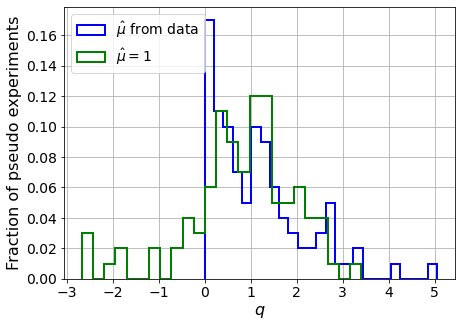

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  8130.5441856   7958.61218425  7727.83674494
  7432.62292281  7074.12430647  6625.6495413   6074.95157956
  5421.84408806  4643.70933414  3729.60843554  2646.50206068
  1382.94531696   -90.40069843 -1738.50924899 -3847.90924298]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 10106.67893664  9862.56880931


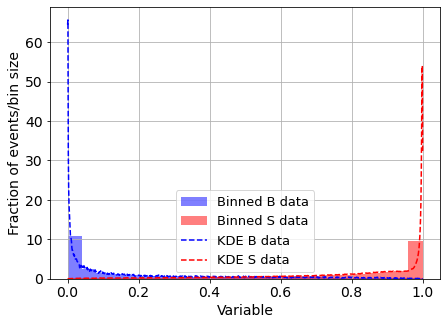

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done


In [ ]:
Z_BL        = []

Z_MLL        = []
Z_MLL_std    = []
Z_MLL_mu     = []
Z_MLL_std_mu = []

auc_total   = []
auc_wgamma  = []
auc_wjets   = []
auc_ttgamma = []
for iloop in range(10):
    
    print(iloop)
    nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
    df = pd.DataFrame()


    #np.random.seed(28890)

    SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

    df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
    df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
    df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
    df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

    df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
    df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
    df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

    df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
    df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
    df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
    df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
    df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

    df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
    df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

    df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
    df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
    df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

    df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
    df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
    #df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

    df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
    df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
    df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])


    df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

    df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

    df_array = np.asarray(df)
    
    df_test = pd.DataFrame()

    SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

    df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
    df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
    df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
    df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

    df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
    df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
    df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

    df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
    df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
    df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
    df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
    df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

    df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
    df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

    df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
    df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
    df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

    df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
    df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
    #df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

    df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
    df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
    df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])


    df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

    df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

    df_test_array = np.asarray(df_test)
    
    nobs = len(df_array)

    train_size = int(0.80 * nobs)
    val_size   = nobs - train_size #%- test_size 

    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    val_indices   = random_indices[train_size:]
    
    
    X_train        = df_array[train_indices, :22]
    bkg_flag_train = df_array[train_indices, 22]
    y_mon_train    = df_array[train_indices, -1]

    X_test        = df_test_array[:, :22]
    bkg_flag_test = df_test_array[:, 22]
    y_mon_test    = df_test_array[:, -1]

    X_val        = df_array[val_indices, :22]
    bkg_flag_val = df_array[val_indices, 22]
    y_mon_val    = df_array[val_indices, -1]
    
    # to normalize
    x_scaler = preprocessing.MinMaxScaler()
    x_scaler = x_scaler.fit(X_train)

    X_mon_train = x_scaler.transform(X_train)
    X_mon_test  = x_scaler.transform(X_test)
    X_mon_val   = x_scaler.transform(X_val)
    
    
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators  = 500,
        learning_rate = 0.1,
        reg_lambda    = 0.0, reg_alpha = 0.0,
        early_stopping_rounds = 50,#early stopping
        eval_metric = 'logloss',
        gamma = 0.0, objective = 'binary:logistic',
        max_depth = 5)

    # FIT
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose  = False)

    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

    pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
    pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
    
    
    # Let's estimate the ROC Curve
    nvals = 50
    tpr_total   = np.zeros(nvals) 
    fpr_total   = np.zeros(nvals) 
    tpr_ttgamma = np.zeros(nvals) 
    fpr_ttgamma = np.zeros(nvals) 
    tpr_wgamma  = np.zeros(nvals) 
    fpr_wgamma  = np.zeros(nvals) 
    tpr_wjets   = np.zeros(nvals) 
    fpr_wjets   = np.zeros(nvals) 

    for ith, th in enumerate(np.linspace(0,1, nvals)):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_total[ith] = len(tp) / (len(tp) + len(fn))
        fpr_total[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma.append( auc(fpr_ttgamma, tpr_ttgamma) )
    auc_wjets.append( auc(fpr_wjets, tpr_wjets) )
    auc_wgamma.append( auc(fpr_wgamma, tpr_wgamma) )
    auc_total.append( auc(fpr_total, tpr_total) )
    
    
    print('AUC:' + str(auc_total[iloop]))
    
    Z_BL.append( BL_test_fast('discovery', pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, 5, linear_bins=True) )

    
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(2000)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])


        if np.min(prob_x_given_B) == 0:
            print('There are events with p(s)=0')
            prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])

        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )
    
    plt.hist(np.asarray(muhat_selected_MLL_list))
    plt.xlabel(r'$\hat{\mu}$')
    plt.savefig('../graph/BP' + str(bp+1) + '/muhat_hist_' + str(iloop) + '_MET200.pdf')
    plt.clf()
    
    plt.hist(np.asarray(q_muhat_MLL))
    plt.xlabel(r'$q_{0}$')
    plt.savefig('../graph/BP' + str(bp+1) + '/q0_hist_' + str(iloop) + '_MET200.pdf')
    plt.clf()
    print('Z BL:' + str(Z_BL[iloop]))
    print('Z:' + str(Z_MLL[iloop]))
    print('Z_std:' + str(Z_MLL_std[iloop]))
    print('Z_1:' + str(Z_MLL_mu[iloop]))
    print('Z_std_1:' + str(Z_MLL_std_mu[iloop]))

In [ ]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.text(0.5,0.08, 'Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + 
         '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(Z_MLL_std)),
         transform = plt.gca().transAxes)
plt.text(0.5,0.02, 'Z BL = ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,0])) + ' +/- ' + 
         '{:.2f}'.format(np.std(np.asarray(Z_BL)[:,0])) + ' +/- ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,1])), transform = plt.gca().transAxes)
plt.title('BP' + str(bp+1))
plt.xlabel('Iteration')
plt.savefig('../graph/loopBP' + str(bp+1) + '_50000_MLLvariable_MET200.pdf')

In [ ]:
Z_MLL

In [ ]:
np.asarray(Z_BL)[:,0]

In [ ]:
print('Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(Z_MLL_std)))
print('Z BL = ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,0])) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_BL)[:,0]))  + ' +/- ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,1])) )

In [ ]:
print('AUC : ' + str(np.mean(np.asarray(auc_total))) + ' +/- ' + str(np.std(np.asarray(auc_total))))